In [1]:
import os
import random
import collections

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from skimage import exposure, img_as_float
#plt.style.use('dark_background')
#plt.style.use('seaborn-deep')
plt.style.use('Solarize_Light2')
%matplotlib inline

In [2]:
print(plt.style.available)

['seaborn-bright', 'tableau-colorblind10', 'seaborn-dark-palette', 'seaborn-notebook', 'seaborn-muted', 'fivethirtyeight', 'seaborn-talk', 'seaborn-deep', 'grayscale', '_classic_test', 'seaborn', 'seaborn-colorblind', 'bmh', 'seaborn-pastel', 'seaborn-whitegrid', 'classic', 'Solarize_Light2', 'seaborn-darkgrid', 'seaborn-paper', 'seaborn-dark', 'dark_background', 'seaborn-ticks', 'fast', 'seaborn-poster', 'seaborn-white', 'ggplot']


In [3]:
IMAGE_DIMENSIONS_NUM = 3
images_dir = '../input/train'
train_images_description_file_path = '../input/train.csv'
full_cwd_path = os.getcwd()
path_prefix, cwd_itself = os.path.split(full_cwd_path)
if cwd_itself != 'code':
    os.chdir(os.path.join(path_prefix, 'code'))
    print(os.getcwd())

In [4]:
train_images_names = os.listdir(images_dir)

In [5]:
#len(train_images_names)
print("train_images_names len: {}".format(len(train_images_names)))
#print("train_images_masks_names len: {}".format(len(train_images_masks_names)))
print(train_images_names[:10]) # Is an image name and mask name with the same index matd_df = pd.read_csv(segmentation_file_path)
#print(train_images_masks_names[:10])
train_images_description_df = pd.read_csv(train_images_description_file_path)
print(train_images_description_df.head())
print(train_images_description_df.shape)

train_images_names len: 25361
['4fa457dc6.jpg', '47a1e0a6e.jpg', 'f1484122e.jpg', '534284730.jpg', '8d7319156.jpg', 'bf06deacf.jpg', 'cf43c77e8.jpg', 'a0611b54a.jpg', 'efb089722.jpg', 'f20d6c29e.jpg']
           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale
(25361, 2)


In [6]:
train_images_description_df.describe()

Image         Id
count           25361      25361
unique          25361       5005
top     6a42b0e31.jpg  new_whale
freq                1       9664

In [7]:
train_images_description_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25361 entries, 0 to 25360
Data columns (total 2 columns):
Image    25361 non-null object
Id       25361 non-null object
dtypes: object(2)
memory usage: 396.3+ KB


In [8]:
train_images_description_df['Id'].unique().shape

(5005,)

In [9]:
print(train_images_description_df['Id'].unique())

['w_f48451c' 'w_c3d896a' 'w_20df2c5' ... 'w_2807565' 'w_17a108a'
 'w_9f30885']


In [10]:
def select_objects(indexes_list, objects_names):
    return tuple(objects_names[i] for i in indexes_list)

In [11]:
def select_random_indexses_subset(size, subset_size):
    return random.sample(tuple(range(size)), subset_size)

In [12]:
def random_objects_select(objects_names, subset_size):
    objects_names_len = len(objects_names)
    indexes = select_random_indexses_subset(objects_names_len, subset_size)
    return select_objects(indexes, objects_names)

In [13]:
def select_offset_indexses_subset(size, subset_size, offset):
    return tuple(range(size))[offset:offset + subset_size]

In [14]:
def offset_objects_select(objects_names, subset_size, offset):
    objects_names_len = len(objects_names)
    indexes = select_offset_indexses_subset(objects_names_len, subset_size, offset)
    return select_objects(indexes, objects_names)

In [15]:
def show_images_grid(images_list, columns_num, figsize, images_names_list=None):
    rows_num = len(images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    images_list_len = len(images_list)
    slice_len = columns_num
    images_list_slices_len = images_list_len // slice_len
    images_names_list_slices = []
    images_list_slices = [
        images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(images_list_slices_len)
    ]
    if images_names_list:
        images_names_list_slices = [
            images_names_list[i * slice_len:(i+1) * slice_len]\
            for i in range(images_list_slices_len)
        ]
    #print("show_images_grid, images_names_list_slices:\n", images_names_list_slices)
    for i in range(ax.shape[0]):
        images_list_slice = images_list_slices[i]
        images_names_list_slice = []
        if images_names_list:
            images_names_list_slice = images_names_list_slices[i]
        #images_list_0 = [images_pair[0] for images_pair in paired_images_list_slice]
        #images_list_1 = [images_pair[1] for images_pair in paired_images_list_slice]
        for j in range(columns_num):
            if images_names_list:
                #print("show_images_grid, images_names_list_slice[{}]:\n".format(j), images_names_list_slice[j])
                ax[i, j].set_title(images_names_list_slice[j])            
            ax[i, j].imshow(images_list_slice[j])

            #ax[2 * i + 1, j].imshow(images_list_1[j])
    plt.tight_layout()
    plt.show()

In [16]:
def draw_images_with_histograms(images_list, columns_num, figsize, nbins):
    rows_num = 3 * len(images_list) // columns_num
    fig, ax = plt.subplots(rows_num, columns_num, figsize=figsize)
    images_list_len = len(images_list)
    slice_len = columns_num
    images_list_slices_len = images_list_len // slice_len
    images_list_slices = [
    images_list[i * slice_len:(i+1) * slice_len]\
        for i in range(images_list_slices_len)
    ]
    for i in range(ax.shape[0] // 3):
        images_list_slice = images_list_slices[i]
        for j in range(columns_num):
            ax[3 * i, j].imshow(images_list_slice[j])
            ax[3 * i, j].grid(False)
            img_cdf, cdf_bins = exposure.cumulative_distribution(images_list_slice[j].flatten())
            ax[3 * i + 1, j].hist(exposure.histogram(images_list_slice[j].flatten(), nbins=nbins))
            ax[3 * i + 2, j].plot(cdf_bins, img_cdf, color='green')
    plt.show()

In [17]:
def extract_object_pixels_by_mask(image, mask):
    return image * mask
apply_mask_to_color_channel = extract_object_pixels_by_mask

In [18]:
def extract_not_object_pixels_by_mask(image, mask):
    #return image * (np.ones(mask.shape) - mask)
    not_object_pixels = image * (np.ones(mask.shape) - mask)
    #print("extract_non_salt_pixels_by_mask:\n", non_salt_pixels)
    return not_object_pixels
apply_negative_mask_to_color_channel = extract_not_object_pixels_by_mask

In [19]:
def get_mask_complement(mask):
    return np.ones(mask.shape) - mask

In [20]:
def compute_object_pixels_num(mask):
    return mask.sum()

def compute_not_object_pixels_num(mask):
    return mask.size - mask.sum()

In [21]:
def compute_whole_image_mean_brightnes(image):
    return image.mean()

In [22]:
def compute_color_channel_mean_brightness(color_channel):
    return color_channel.mean()

In [23]:
def compute_color_channels_mean_brightness(color_channels):
    return [
        compute_color_channel_mean_brightness(color_channel) for color_channel in color_channels
    ]

In [24]:
def compute_images_list_color_channels_mean_brightness(images_color_channels_list):
    return [
        compute_color_channels_mean_brightness(
            image_color_channels
        ) for image_color_channels in images_color_channels_list
    ]

In [25]:
def divide_color_channels_values(color_channels_values):
    return (
        [color_channel_value[0] for color_channel_value in color_channels_values],
        [color_channel_value[1] for color_channel_value in color_channels_values],
        [color_channel_value[2] for color_channel_value in color_channels_values],
    )


In [26]:
def compute_object_pixels_mean_brightness(image, mask):
    full_color_image_salt_pixels = apply_mask_to_full_color_image(image, mask)
    #print(compute_salt_pixels_num(mask))
    salt_pixels_num = compute_salt_pixels_num(mask) * IMAGE_DIMENSIONS_NUM
    salt_pixels_sum = full_color_image_salt_pixels.sum()
    return 0.0 if salt_pixels_num == 0 else salt_pixels_sum / salt_pixels_num

In [27]:
def get_image_color_channels(image):
    return [image[:, :, i] for i in range(IMAGE_DIMENSIONS_NUM)]

def collapse_color_channels_to_image(color_components):
    return np.array([color_components[i].T for i in range(IMAGE_DIMENSIONS_NUM)]).T

In [28]:
def get_images_color_channels(images):
    return [get_image_color_channels(image) for image in images]

In [29]:
def apply_mask_to_color_channels(color_channels, mask):
    return [apply_mask_to_color_channel(color_channel, mask) for color_channel in color_channels]

In [30]:
def apply_negative_mask_to_color_channels(color_channels, mask):
    #print("apply_negative_mask_to_color_channels, color_channels:\n", color_channels)
    return [apply_negative_mask_to_color_channel(color_channel, mask) for color_channel in color_channels]

In [31]:
def apply_mask_to_full_color_image(image, mask):
    color_channels = get_image_color_channels(image)
    masked_color_channels = apply_mask_to_color_channels(
        color_channels,
        mask
    )
    return collapse_color_channels_to_image(masked_color_channels)

In [32]:
def apply_negative_mask_to_full_color_image(image, mask):
    color_channels = get_image_color_channels(image)
    masked_color_channels = apply_negative_mask_to_color_channels(
        color_channels,
        mask
    )
    return collapse_color_channels_to_image(masked_color_channels)

In [33]:
def calculate_mode(sample):
    flatten_sample = sample.flatten()
    counter = collections.Counter(sample.flatten())
    most_common = counter.most_common()
    if len(most_common) > 0:
        if len(most_common) == 1:
            return most_common[0]
        else:
            if most_common[0][0] == 0:
                return most_common[1]
            else:
                return most_common[0]
    else:
        return None
compute_color_channel_mode = calculate_mode

In [34]:
def collect_modes_and_frequencies(modes):
    modes_frequencies_dict = {}
    print("collect_modes_and_frequencies,  modes:\n", modes)
    for color_channels_modes in modes:
        mode_value, frequency = color_channels_modes[0]
        if mode_value in modes_frequencies_dict:
            modes_frequencies_dict[mode_value] += frequency
        else:
            modes_frequencies_dict[mode_value] = frequency
    return modes_frequencies_dict

In [35]:
def gather_color_channel_modes_and_frequencies(modes):
    modes_frequencies_dict = {}
    for color_channels_modes in modes:
        mode_value, frequency = color_channels_modes
        if mode_value in modes_frequencies_dict:
            modes_frequencies_dict[mode_value] += frequency
        else:
            modes_frequencies_dict[mode_value] = frequency
    return modes_frequencies_dict

In [36]:
def gather_objects_and_frequencies(objects_list):
    return collections.Counter(objects_list)

In [37]:
def gather_objects_and_frequencies(objects_list):
    frequencies_dict = {}
    for obj in objects_list:
        if obj in frequencies_dict:
            frequencies_dict[obj] += 1
        else:
            frequencies_dict[obj] = 1
    return frequencies_dict

In [38]:
def sort_gathered_objects(objects):
    objects_sorted = sorted(objects)
    objects_frequencies_sorted = []
    for obj in objects_sorted:
        objects_frequencies_sorted.append(objects[obj])
    return objects_sorted, objects_frequencies_sorted

In [39]:
def compute_color_channels_modes(color_channels):
    return [compute_color_channel_mode(color_channel) for color_channel in color_channels]

In [40]:
def compute_images_color_channels_modes(images_color_channels):
    return [
        compute_color_channels_modes(image_color_channels)\
        for image_color_channels in images_color_channels
    ]

In [41]:
def get_image_pixels(color_channels):
    return [
        (channel0value, channel1value, channel2value) for channel0value, channel1value, channel2value
           in zip(color_channels[0], color_channels[1], color_channels[2])
    ]

In [42]:
def get_image_pixels(image):
    color_channel0 = image[:, :, 0].ravel()
    color_channel1 = image[:, :, 1].ravel()
    color_channel2 = image[:, :, 2].ravel()
    return [(x, y, z) for x, y, z in zip(color_channel0, color_channel1, color_channel2)]

In [43]:
def compare_color_channels_by_pixels(image):
    image_pixels = get_image_pixels(image)
    return [compare_pixel_color_channels_values(pixel) for pixel in image_pixels]

In [44]:
def compare_images_color_channels(images):
    return [compare_color_channels_by_pixels(image) for image in images]

In [45]:
def count_image_color_channels(image):
    if len(image.shape) == 2:
        return 1
    else:
        return 3

In [46]:
whales_train_images_num = train_images_description_df.shape[0]
whales_train_images_names_sample = random_objects_select(train_images_names, int(whales_train_images_num / 4))

In [47]:
'''
whales_train_images = [
    mpimg.imread(os.path.join(images_dir, image_name)) for image_name in whales_train_images_names_sample
]
'''

'''
whales_train_images = [
    mpimg.imread(os.path.join(images_dir, image_name)) for image_name in train_images_names
]
'''

'\nwhales_train_images = [\n    mpimg.imread(os.path.join(images_dir, image_name)) for image_name in train_images_names\n]\n'

In [48]:
whales_train_images_dict = {
    image_name: mpimg.imread(os.path.join(images_dir, image_name)) for image_name in train_images_names
}

In [49]:
print(len(whales_train_images_dict))

25361


In [50]:
print("whales_train_images_dict.values()[0].shape: ", tuple(whales_train_images_dict.values())[0].shape)

whales_train_images_dict.values()[0].shape:  (631, 1050, 3)


In [51]:
img = next(iter(whales_train_images_dict.values()))

In [52]:
img

array([[[ 60,  98, 135],
        [ 59,  97, 134],
        [ 53,  91, 128],
        ...,
        [132, 130, 151],
        [131, 129, 151],
        [130, 128, 150]],

       [[ 61,  99, 136],
        [ 61,  99, 136],
        [ 57,  95, 132],
        ...,
        [134, 132, 153],
        [135, 133, 154],
        [135, 133, 154]],

       [[ 58,  96, 133],
        [ 59,  97, 134],
        [ 57,  95, 132],
        ...,
        [140, 139, 157],
        [138, 136, 157],
        [138, 136, 157]],

       ...,

       [[  3,  52,  66],
        [  4,  53,  67],
        [  6,  55,  69],
        ...,
        [ 61, 107, 141],
        [ 63, 107, 142],
        [ 64, 108, 143]],

       [[  0,  50,  61],
        [  0,  52,  63],
        [  2,  54,  65],
        ...,
        [ 47,  96, 128],
        [ 47,  96, 128],
        [ 50,  99, 132]],

       [[  0,  50,  61],
        [  1,  53,  64],
        [  2,  54,  65],
        ...,
        [ 42,  93, 124],
        [ 41,  92, 123],
        [ 45,  96, 127]]

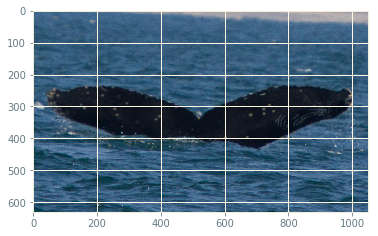

In [53]:
plt.imshow(img)
plt.show()

In [54]:
whales_train_images = tuple(whales_train_images_dict.values())

In [55]:
print("whales_train_images[3471].shape: ", whales_train_images[3471].shape)

whales_train_images[3471].shape:  (667, 1000, 3)


In [56]:
whales_train_images[3471]

array([[[ 67,  98, 145],
        [ 66,  96, 146],
        [ 63,  95, 144],
        ...,
        [ 78, 115, 168],
        [ 75, 112, 165],
        [ 73, 110, 163]],

       [[ 97, 129, 176],
        [ 91, 123, 170],
        [ 82, 116, 162],
        ...,
        [101, 141, 192],
        [ 93, 133, 184],
        [ 87, 127, 178]],

       [[108, 145, 190],
        [ 99, 136, 181],
        [ 90, 127, 172],
        ...,
        [102, 145, 190],
        [101, 142, 188],
        [100, 141, 187]],

       ...,

       [[ 94, 132, 179],
        [ 93, 131, 178],
        [ 93, 131, 178],
        ...,
        [ 25,  61,  93],
        [ 24,  60,  92],
        [ 23,  59,  91]],

       [[ 88, 126, 173],
        [ 88, 126, 173],
        [ 90, 128, 175],
        ...,
        [ 21,  60,  91],
        [ 20,  59,  90],
        [ 18,  57,  88]],

       [[106, 144, 191],
        [105, 143, 190],
        [105, 143, 190],
        ...,
        [ 20,  61,  93],
        [ 18,  59,  91],
        [ 16,  57,  89]]

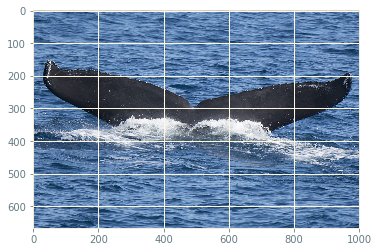

In [57]:

plt.imshow(whales_train_images[3471])
plt.show()

In [58]:
#whales_images_subsample = whales_train_images[:40]
whales_images_subsample = [whales_train_images_dict[img_name] for img_name in whales_train_images_names_sample[:40]]

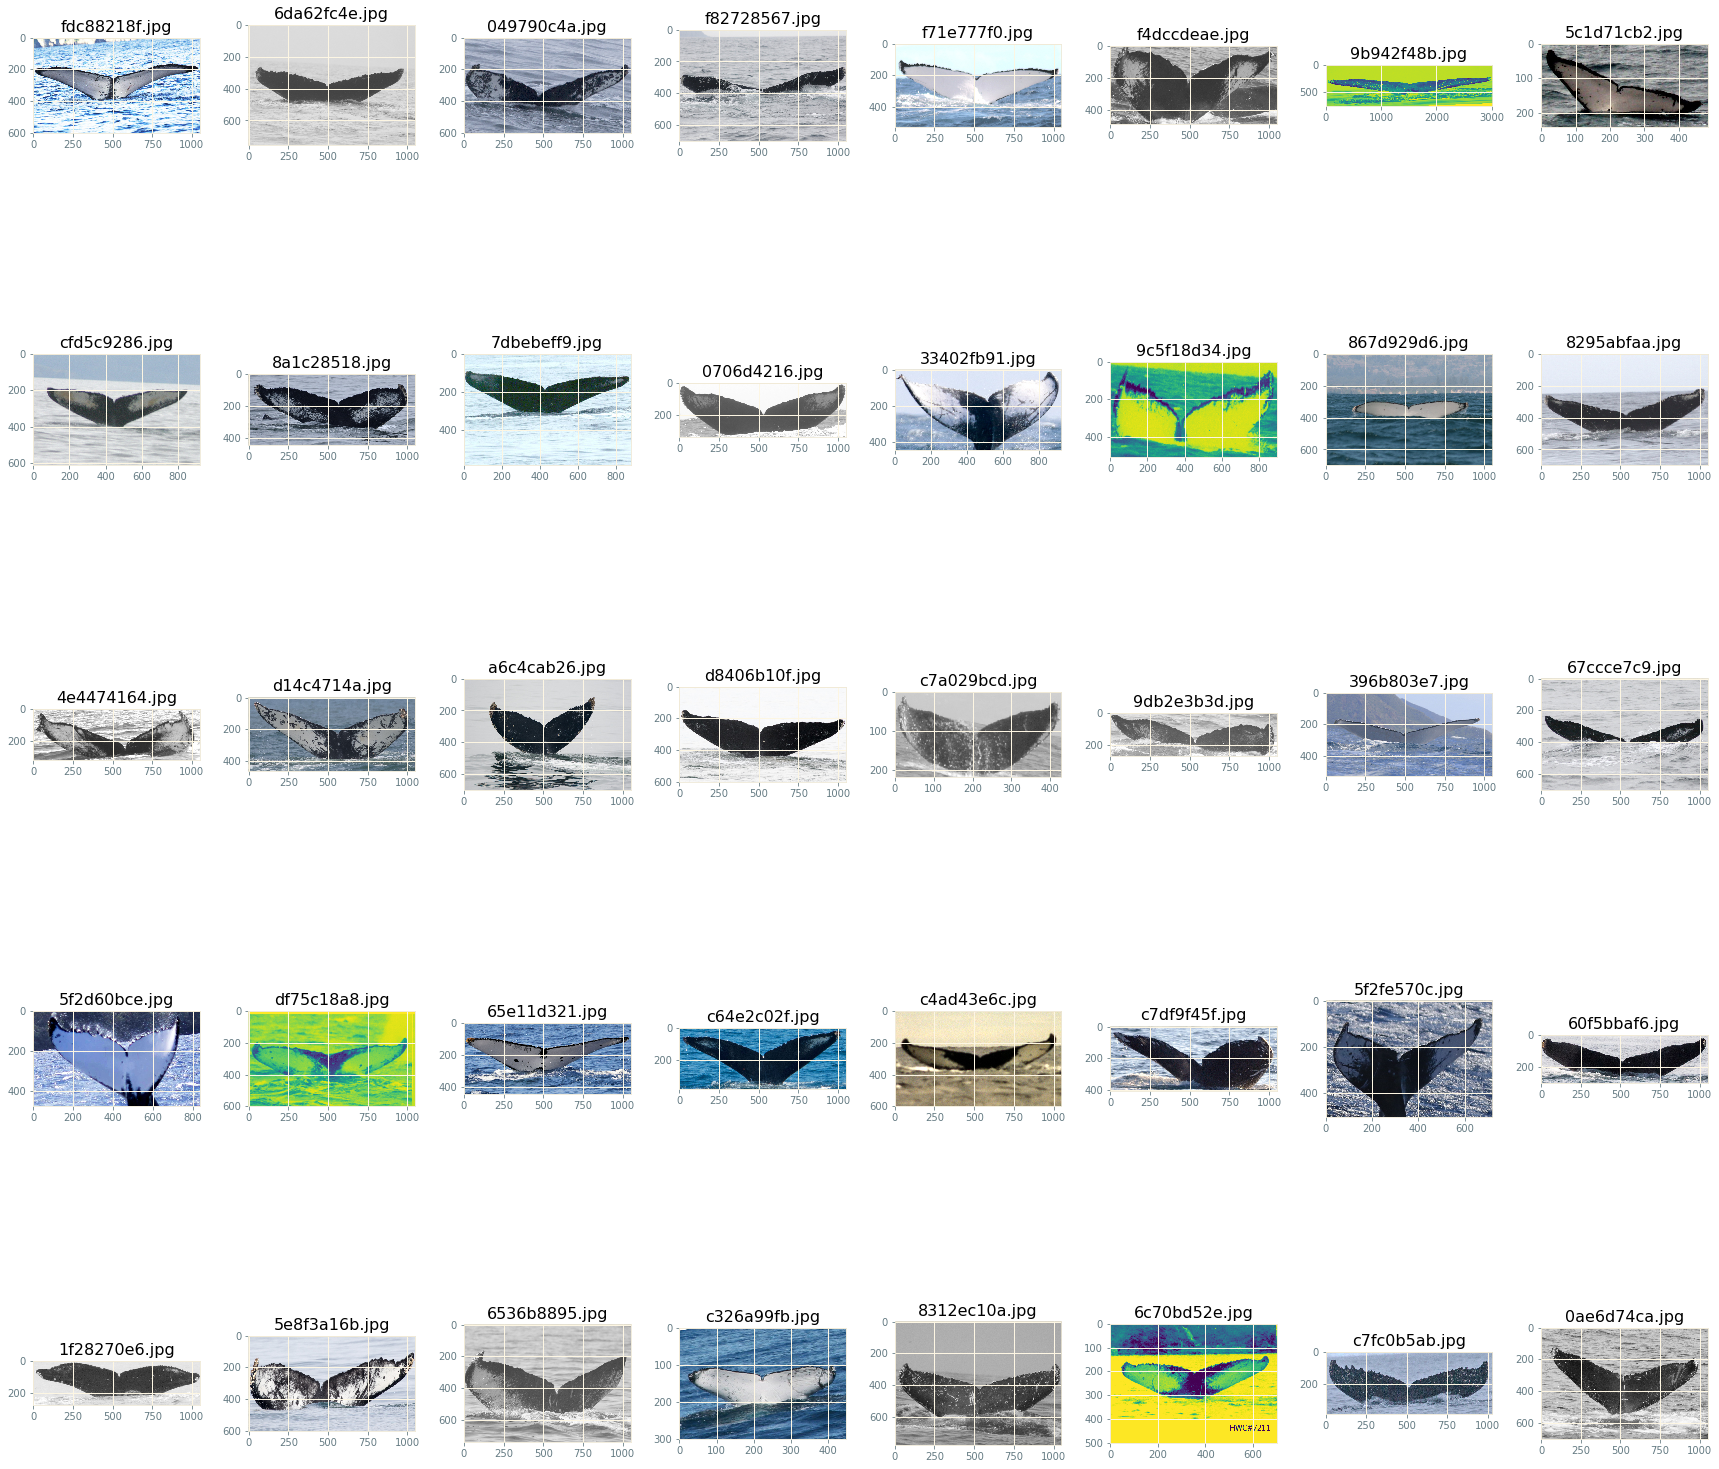

In [59]:
show_images_grid(whales_images_subsample, 8, (24, 24), images_names_list=whales_train_images_names_sample[:40])

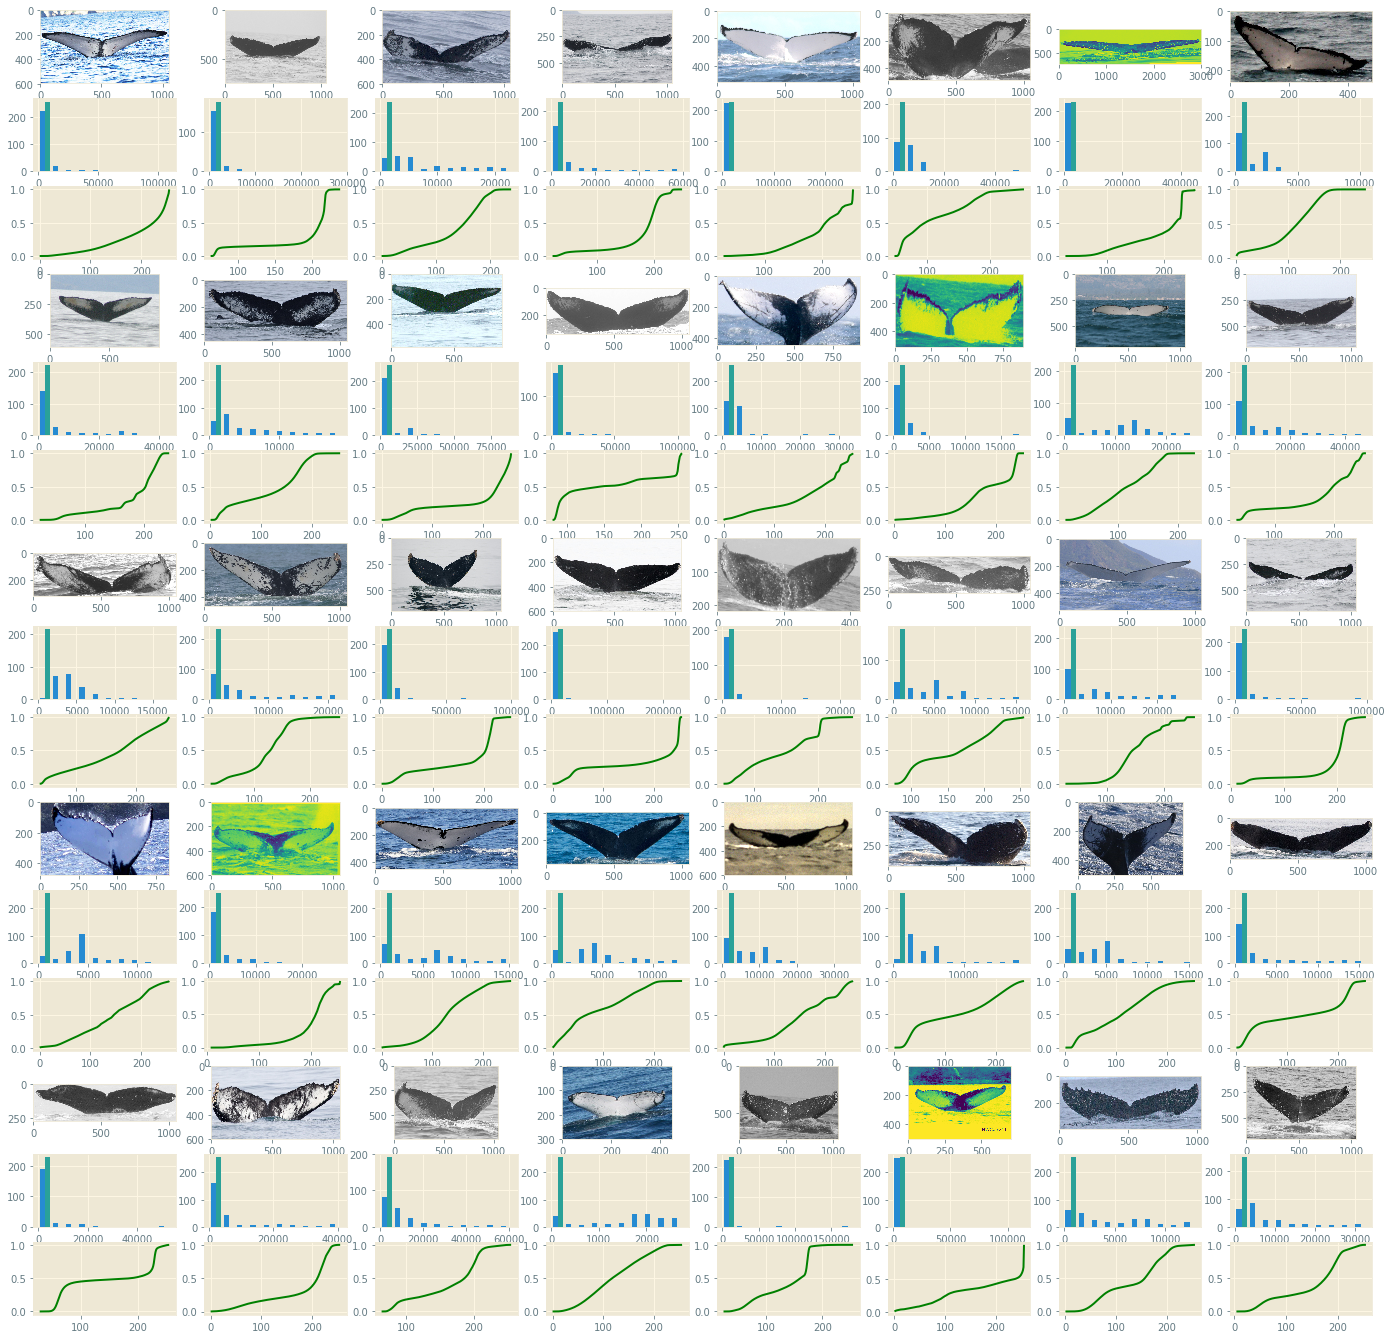

In [60]:
draw_images_with_histograms(whales_images_subsample[:40], 8, (24, 24), 20)

In [61]:
whales_train_images_mean_brightness = [
    compute_whole_image_mean_brightnes(image) for image in whales_train_images
]

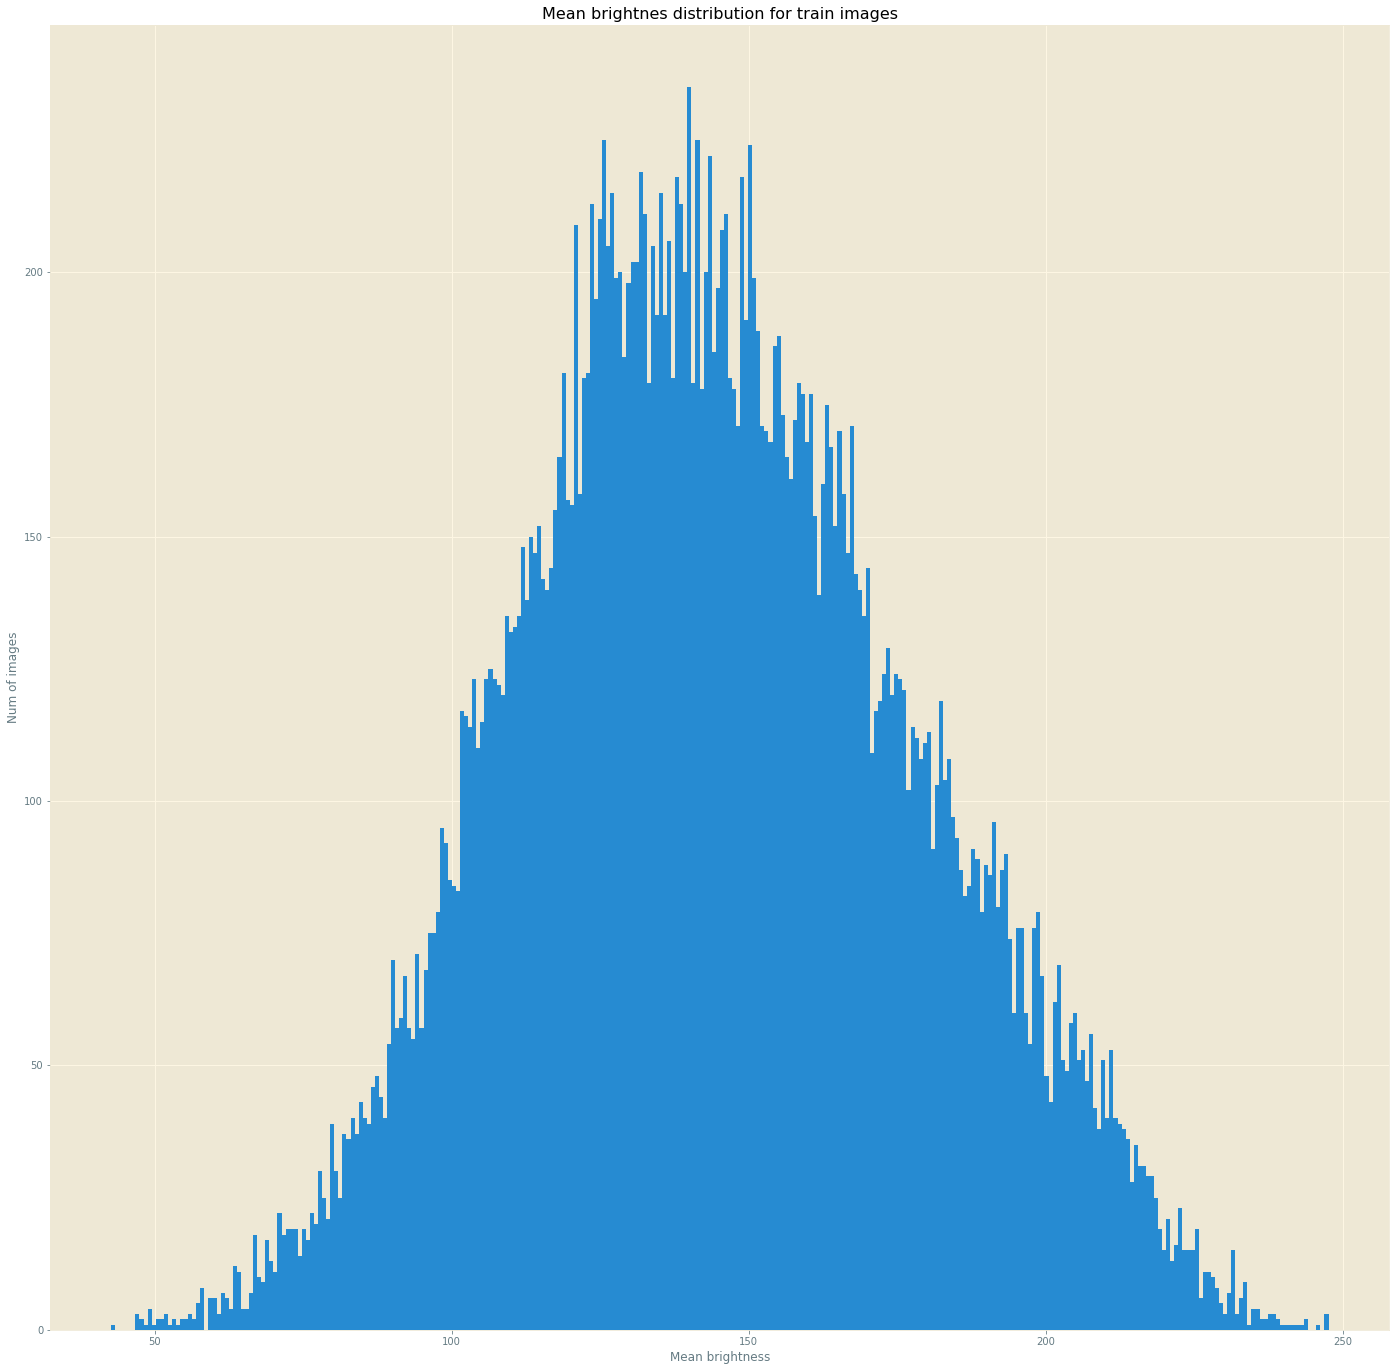

In [62]:
fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)
ax.hist(whales_train_images_mean_brightness, bins=300)
ax.set_title("Mean brightnes distribution for train images")
#ax.set(title="Mean brightnes distribution for images with chips")
ax.set_xlabel("Mean brightness")
ax.set_ylabel("Num of images")
plt.show()

In [63]:
#random_selected_train_images = random_objects_select(train_images, 9000)

In [64]:
#print(type(random_selected_train_images[0]))
#print(random_selected_train_images[0])

In [65]:
#random_selected_train_images_mean_brightness = [
#    compute_whole_image_mean_brightnes(image) for image in random_selected_train_images
#]

In [66]:
#fig = plt.figure(figsize=(24, 24))
#ax = fig.add_subplot(111)
#ax.hist(random_selected_train_images_mean_brightness, bins=100)
#plt.show()

In [67]:
print(whales_train_images_mean_brightness[0])

80.43945664478153


In [68]:
print((sum(whales_train_images_mean_brightness)) / len(whales_train_images_mean_brightness))

144.7314920318592


In [69]:
print(type(whales_train_images[8].shape))

<class 'tuple'>


In [70]:
whales_train_images_shapes_counter_dict = {}
for image in whales_train_images:
    if image.shape in whales_train_images_shapes_counter_dict:
        whales_train_images_shapes_counter_dict[image.shape] += 1
    else:
        whales_train_images_shapes_counter_dict[image.shape] = 1

In [71]:
len(whales_train_images_shapes_counter_dict)

5803

In [72]:
for key, value in whales_train_images_shapes_counter_dict.items():
    print(key, value)

(631, 1050, 3) 14
(361, 1050, 3) 22
(600, 1050, 3) 1724
(555, 729, 3) 1
(304, 533, 3) 1
(299, 1050, 3) 20
(328, 917, 3) 1
(472, 707, 3) 2
(621, 932, 3) 1
(652, 1000, 3) 112
(266, 720, 3) 1
(351, 818, 3) 1
(571, 1050, 3) 7
(418, 1050, 3) 17
(397, 596, 3) 1
(317, 758, 3) 1
(700, 1050, 3) 3330
(525, 1050, 3) 1303
(538, 1019) 1
(512, 697, 3) 1
(408, 816, 3) 2
(632, 1050, 3) 4
(697, 1050, 3) 25
(207, 634, 3) 1
(600, 1050) 825
(302, 1050, 3) 19
(555, 852, 3) 1
(709, 1050, 3) 8
(500, 700) 667
(674, 1050, 3) 7
(565, 1022, 3) 1
(335, 1050, 3) 27
(331, 1050, 3) 20
(190, 443, 3) 1
(775, 1050, 3) 9
(450, 1050, 3) 1556
(267, 1050, 3) 18
(394, 920, 3) 1
(525, 2700) 15
(692, 1036, 3) 1
(591, 1050, 3) 280
(449, 1050, 3) 45
(412, 1050, 3) 28
(581, 1016, 3) 2
(262, 393, 3) 2
(404, 1050, 3) 25
(311, 1050, 3) 11
(603, 1041, 3) 1
(541, 1050, 3) 9
(610, 915, 3) 1
(224, 1050, 3) 6
(207, 758, 3) 1
(355, 1050, 3) 21
(810, 1050, 3) 3
(773, 1050, 3) 4
(785, 1050, 3) 3
(451, 1050, 3) 47
(163, 1050, 3) 1
(240, 105

(436, 1017, 3) 3
(152, 266, 3) 1
(498, 1050, 3) 8
(377, 880, 3) 2
(499, 699) 2
(677, 1050, 3) 11
(582, 1050, 3) 4
(546, 808, 3) 1
(332, 1348) 1
(464, 992) 1
(293, 810) 1
(608, 979, 3) 1
(353, 1050, 3) 17
(462, 1018, 3) 1
(282, 675, 3) 1
(167, 292, 3) 1
(301, 1050, 3) 22
(585, 884, 3) 1
(491, 1050) 2
(322, 624, 3) 1
(482, 843) 1
(616, 1050) 1
(806, 1050, 3) 7
(474, 840) 4
(359, 539, 3) 1
(377, 775, 3) 1
(401, 935, 3) 2
(555, 1050, 3) 7
(427, 1027, 3) 1
(179, 418, 3) 2
(441, 1050, 3) 23
(191, 1050, 3) 5
(735, 1050, 3) 11
(764, 1050, 3) 3
(421, 1050, 3) 15
(892, 1050, 3) 3
(445, 1050, 3) 17
(389, 1050, 3) 14
(670, 848, 3) 1
(537, 974, 3) 1
(275, 1050, 3) 15
(451, 790, 3) 2
(233, 1050, 3) 6
(618, 994, 3) 1
(468, 819, 3) 1
(482, 1035) 1
(303, 1050, 3) 16
(395, 1050, 3) 23
(191, 562, 3) 1
(212, 687, 3) 1
(477, 834, 3) 2
(533, 933, 3) 4
(694, 1050, 3) 11
(391, 1050, 3) 24
(333, 1050, 3) 35
(453, 680, 3) 1
(347, 579) 1
(534, 1050, 3) 7
(620, 1050, 3) 5
(307, 673, 3) 1
(735, 1050) 7
(325, 758, 

(640, 960, 3) 4
(723, 1557) 1
(386, 902, 3) 1
(528, 720, 3) 3
(487, 852, 3) 4
(560, 1050, 3) 12
(221, 756, 3) 1
(449, 728) 1
(673, 1050, 3) 2
(506, 1005) 1
(239, 1050, 3) 14
(573, 885, 3) 1
(464, 840) 2
(450, 630) 3
(356, 830, 3) 7
(515, 901) 1
(587, 1027, 3) 1
(283, 709, 3) 1
(387, 784, 3) 1
(644, 1020) 1
(246, 1011, 3) 1
(439, 1050, 3) 18
(579, 1012, 3) 1
(479, 791, 3) 1
(673, 1010, 3) 3
(431, 1050, 3) 17
(185, 431, 3) 2
(754, 1050, 3) 10
(333, 582, 3) 1
(95, 222, 3) 1
(450, 675, 3) 1
(172, 439, 3) 1
(419, 1629) 1
(289, 1654) 1
(559, 979, 3) 1
(629, 1050, 3) 13
(647, 1050, 3) 6
(549, 915, 3) 1
(181, 693, 3) 1
(494, 855, 3) 1
(510, 980) 1
(530, 1050, 3) 6
(275, 862, 3) 1
(687, 1050, 3) 13
(444, 777, 3) 1
(416, 1005, 3) 1
(476, 951, 3) 1
(426, 746, 3) 1
(206, 481, 3) 1
(411, 822, 3) 1
(288, 701, 3) 1
(581, 500, 3) 1
(434, 764, 3) 1
(339, 626, 3) 1
(399, 930, 3) 1
(349, 978, 3) 1
(465, 698, 3) 2
(344, 802, 3) 3
(500, 1050, 3) 5
(575, 1006, 3) 2
(564, 849, 3) 1
(676, 1050, 3) 8
(350, 640

(304, 822, 3) 1
(508, 699, 3) 1
(699, 923, 3) 1
(375, 525, 3) 1
(236, 1050, 3) 3
(675, 1012, 3) 3
(522, 869, 3) 1
(187, 620, 3) 1
(484, 968, 3) 1
(280, 828, 3) 1
(581, 1016) 1
(354, 619, 3) 1
(638, 957, 3) 2
(187, 436, 3) 1
(263, 1838) 1
(725, 1016, 3) 1
(560, 942, 3) 1
(319, 743, 3) 2
(108, 299, 3) 1
(714, 1000) 6
(371, 557, 3) 2
(600, 1020) 1
(163, 780, 3) 1
(723, 1050, 3) 8
(459, 840) 1
(517, 776, 3) 1
(630, 1124) 1
(491, 1038) 1
(592, 1050) 1
(421, 842, 3) 1
(372, 744, 3) 1
(325, 568, 3) 2
(317, 1536) 1
(454, 944, 3) 1
(573, 999, 3) 1
(640, 981, 3) 1
(711, 568, 3) 1
(284, 568, 3) 1
(391, 987, 3) 1
(545, 1037) 1
(605, 908, 3) 2
(1476, 1050, 3) 1
(345, 806, 3) 1
(305, 641, 3) 1
(177, 809, 3) 1
(308, 716, 3) 1
(899, 1050, 3) 1
(89, 520, 3) 1
(475, 694) 1
(422, 739) 1
(631, 1174) 1
(640, 2495) 1
(375, 741, 3) 1
(734, 1015) 1
(291, 682, 3) 1
(397, 927, 3) 2
(578, 1050, 3) 4
(223, 894, 3) 1
(230, 460, 3) 1
(328, 679, 3) 1
(188, 1050, 3) 2
(404, 1001, 3) 1
(379, 983, 3) 1
(730, 1061) 1
(3

(466, 1000) 1
(268, 2644) 1
(286, 704, 3) 1
(565, 988, 3) 2
(714, 968, 3) 1
(596, 2115) 3
(735, 1029, 3) 1
(778, 1050, 3) 4
(415, 967, 3) 1
(388, 681, 3) 1
(563, 1094) 1
(405, 943, 3) 1
(576, 789, 3) 1
(654, 981, 3) 2
(421, 1026, 3) 1
(375, 701, 3) 1
(447, 894, 3) 1
(692, 1038, 3) 4
(543, 1068) 1
(353, 1000) 1
(598, 1036, 3) 1
(322, 751, 3) 2
(292, 1027, 3) 1
(668, 1024, 3) 1
(188, 438, 3) 1
(680, 1500) 1
(646, 772, 3) 1
(593, 889, 3) 2
(255, 595, 3) 2
(124, 297, 3) 1
(275, 888, 3) 1
(204, 356, 3) 1
(385, 752, 3) 1
(469, 820, 3) 1
(88, 206) 1
(260, 606, 3) 2
(582, 640, 3) 1
(466, 840) 2
(521, 993) 1
(209, 2245) 1
(569, 979, 3) 1
(445, 778, 3) 2
(444, 666, 3) 1
(338, 492, 3) 1
(495, 968, 3) 1
(798, 1050, 3) 4
(276, 968, 3) 1
(555, 972) 3
(199, 721, 3) 1
(393, 750, 3) 1
(239, 639) 1
(337, 787, 3) 1
(161, 391, 3) 1
(582, 873, 3) 1
(538, 1006) 1
(315, 736, 3) 1
(276, 568, 3) 1
(265, 956) 1
(427, 1324) 1
(345, 603, 3) 2
(519, 1015) 1
(209, 872, 3) 1
(293, 899, 3) 1
(487, 747, 3) 1
(599, 105

(196, 704, 3) 1
(578, 1022, 3) 1
(347, 607, 3) 1
(274, 639, 3) 1
(287, 1436) 1
(279, 836, 3) 1
(657, 2290) 1
(317, 740, 3) 1
(241, 562, 3) 1
(643, 948, 3) 1
(224, 529, 3) 1
(358, 834, 3) 1
(229, 868, 3) 1
(427, 886, 3) 1
(496, 699) 2
(620, 930, 3) 3
(273, 605, 3) 1
(524, 1048, 3) 1
(543, 574, 3) 1
(588, 882, 3) 2
(517, 708, 3) 1
(1500, 1000, 3) 1
(509, 693) 1
(418, 627, 3) 1
(196, 1050, 3) 4
(466, 699, 3) 2
(273, 963, 3) 1
(667, 1348) 1
(487, 730, 3) 2
(264, 463, 3) 1
(155, 1050, 3) 1
(528, 2697) 1
(264, 3501) 1
(179, 696, 3) 1
(468, 936, 3) 3
(417, 827, 3) 1
(570, 949, 3) 1
(517, 983, 3) 1
(690, 2017) 1
(532, 1000) 1
(458, 1020) 1
(549, 1000) 1
(500, 703) 2
(100, 1050, 3) 1
(267, 603, 3) 1
(508, 1004) 1
(166, 1050, 3) 1
(265, 935, 3) 1
(405, 968) 1
(183, 360, 3) 1
(648, 1697) 1
(454, 791) 1
(269, 1915) 1
(228, 399, 3) 1
(612, 939, 3) 1
(355, 549, 3) 1
(632, 2690) 1
(427, 878, 3) 1
(277, 647, 3) 2
(430, 753, 3) 1
(614, 2780) 1
(430, 961, 3) 1
(346, 617, 3) 1
(153, 358, 3) 1
(329, 636, 

(598, 1050) 2
(313, 547, 3) 1
(461, 807, 3) 2
(561, 1006, 3) 1
(332, 845, 3) 1
(380, 887, 3) 1
(470, 819) 1
(833, 1050, 3) 1
(170, 942, 3) 1
(535, 803, 3) 1
(330, 822, 3) 1
(585, 883, 3) 1
(519, 776, 3) 1
(157, 321, 3) 1
(403, 706, 3) 2
(286, 901, 3) 1
(566, 2115) 1
(504, 997, 3) 1
(331, 962, 3) 1
(616, 681, 3) 1
(588, 2091) 1
(485, 848, 3) 2
(520, 820, 3) 1
(716, 3155) 1
(211, 725, 3) 1
(592, 1238) 1
(430, 775, 3) 1
(80, 170, 3) 1
(500, 680, 3) 1
(498, 746, 3) 1
(282, 794, 3) 1
(549, 921, 3) 1
(204, 477, 3) 1
(324, 952, 3) 1
(282, 659, 3) 2
(609, 1053) 1
(302, 652, 3) 1
(174, 407, 3) 1
(268, 845, 3) 1
(289, 640, 3) 2
(463, 840) 1
(238, 555, 3) 1
(376, 867, 3) 1
(267, 653, 3) 1
(538, 1014) 1
(365, 771, 3) 1
(572, 902, 3) 1
(319, 854, 3) 1
(399, 665, 3) 1
(289, 789, 3) 1
(442, 1030, 3) 1
(460, 638, 3) 1
(542, 3865) 1
(602, 1047, 3) 2
(587, 887, 3) 1
(389, 640, 3) 1
(284, 758, 3) 1
(582, 998) 1
(386, 578) 1
(462, 912, 3) 1
(499, 873) 2
(389, 909, 3) 1
(700, 1369) 1
(313, 770, 3) 1
(527, 

(334, 819, 3) 1
(510, 1004) 1
(513, 1026, 3) 1
(270, 873, 3) 1
(436, 1013, 3) 1
(615, 1076) 1
(582, 883, 3) 1
(384, 2639) 1
(363, 811, 3) 1
(663, 1043) 1
(273, 447, 3) 1
(295, 994, 3) 1
(637, 955, 3) 1
(302, 525) 2
(310, 943, 3) 1
(416, 624, 3) 1
(561, 1774) 1
(577, 1014, 3) 1
(497, 1019, 3) 1
(562, 1000) 1
(180, 426, 3) 1
(183, 784, 3) 1
(421, 734, 3) 1
(382, 1050) 1
(331, 578, 3) 1
(168, 831) 1
(361, 810, 3) 1
(585, 1050) 2
(655, 982, 3) 2
(120, 398, 3) 1
(402, 798, 3) 1
(453, 906, 3) 1
(698, 1024, 3) 1
(457, 933, 3) 1
(520, 911, 3) 2
(624, 960) 1
(540, 828, 3) 1
(126, 294, 3) 1
(314, 1015, 3) 1
(274, 641, 3) 1
(552, 1029, 3) 1
(435, 1348) 1
(187, 575, 3) 1
(227, 651, 3) 1
(1379, 1050, 3) 1
(601, 1400) 1
(422, 844, 3) 1
(172, 786, 3) 1
(296, 954, 3) 1
(602, 1004, 3) 1
(226, 526, 3) 1
(177, 551, 3) 1
(505, 883) 1
(535, 1006) 1
(519, 727, 3) 1
(162, 543, 3) 1
(541, 1008, 3) 1
(155, 361, 3) 1
(160, 415, 3) 1
(470, 996, 3) 1
(506, 886, 3) 1
(291, 601) 1
(571, 999) 1
(466, 776, 3) 1
(240,

In [73]:
whales_train_images_shapes_len_dict = {1: 0, 2: 0, 3: 0, 4: 0}
for key in whales_train_images_shapes_counter_dict.keys():
    whales_train_images_shapes_len_dict[len(key)] += 1

In [74]:
print(whales_train_images_shapes_len_dict)

{1: 0, 2: 1185, 3: 4618, 4: 0}


In [75]:
whales_train_images_color_channels_counter_dict = {1: 0, 3: 0}
for image in whales_train_images:
    if len(image.shape) == 2:
        whales_train_images_color_channels_counter_dict[1] += 1
    elif len(image.shape) == 3 and image.shape[2] == 3:
        whales_train_images_color_channels_counter_dict[3] += 1

In [76]:
print(whales_train_images_color_channels_counter_dict)

{1: 3386, 3: 21975}


In [77]:
whales_train_images_color_channels_counter_dict[1] + whales_train_images_color_channels_counter_dict[3] == len(whales_train_images)

True

In [78]:
print(type(whales_train_images))
print(len(whales_train_images))

<class 'tuple'>
25361


In [79]:
#whales_train_images_color_channels = [get_image_color_channels(image) for image in whales_train_images]

In [80]:
group_by_id_train_images_description_df = train_images_description_df.groupby('Id')

In [81]:
example_of_grouped_objects = list(group_by_id_train_images_description_df)[:3]

In [82]:
for grouped_object in example_of_grouped_objects:
    print("\n*******\ntype(grouped_object): ", type(grouped_object))
    print("\ngrouped_object:\n", grouped_object)
    '''
    print("\ntype(grouped_object[0]): {}, type(grouped_object[1]): {}, type(grouped_object[2]): {} \n\n".format(
            type(grouped_object[0]),
            type(grouped_object[1]),
            type(grouped_object[2])
        )
    )
    '''
    print("\ntype(grouped_object[0]): {}, type(grouped_object[1]): {}\n\n".format(
            type(grouped_object[0]),
            type(grouped_object[1])
        )
    )


*******
type(grouped_object):  <class 'tuple'>

grouped_object:
 ('new_whale',                Image         Id
3      00050a15a.jpg  new_whale
4      0005c1ef8.jpg  new_whale
5      0006e997e.jpg  new_whale
7      000f0f2bf.jpg  new_whale
11     001d7450c.jpg  new_whale
12     00200e115.jpg  new_whale
13     00245a598.jpg  new_whale
14     002b4615d.jpg  new_whale
15     002f99f01.jpg  new_whale
18     003795857.jpg  new_whale
19     0041880bf.jpg  new_whale
20     0043da555.jpg  new_whale
22     00464ff65.jpg  new_whale
24     004ae9e26.jpg  new_whale
25     004c0f43b.jpg  new_whale
33     005ce3100.jpg  new_whale
34     00600ce17.jpg  new_whale
38     006506edf.jpg  new_whale
40     006bdc6ff.jpg  new_whale
42     007218187.jpg  new_whale
49     0085064af.jpg  new_whale
50     0085a6bd0.jpg  new_whale
51     00869b59e.jpg  new_whale
55     00917baa4.jpg  new_whale
59     0095fe89c.jpg  new_whale
65     00a46c559.jpg  new_whale
67     00a70e649.jpg  new_whale
69     00aae723d.jpg  ne

In [83]:
count_of_images_with_particular_id = group_by_id_train_images_description_df.count()

In [84]:
type(count_of_images_with_particular_id)

pandas.core.frame.DataFrame

In [85]:
count_of_images_with_particular_id.shape

(5005, 1)

In [86]:
count_of_images_with_particular_id.head()

Image
Id              
new_whale   9664
w_0003639      1
w_0003c59      1
w_0027efa     10
w_00289b1      2

In [87]:
sorted_count_of_images_with_particular_id = count_of_images_with_particular_id.sort_values(by="Image")

In [88]:
type(sorted_count_of_images_with_particular_id)

pandas.core.frame.DataFrame

In [89]:
sorted_count_of_images_with_particular_id.tail()

Image
Id              
w_0369a5c     61
w_9c506f6     62
w_9b5109b     65
w_23a388d     73
new_whale   9664

In [90]:
id_with_many_images_df = sorted_count_of_images_with_particular_id[sorted_count_of_images_with_particular_id['Image'] > 1]

In [91]:
id_with_many_images_df.shape

(2932, 1)

In [92]:
id_with_one_image_df = sorted_count_of_images_with_particular_id[sorted_count_of_images_with_particular_id['Image'] == 1]

In [93]:
id_with_one_image_df.shape

(2073, 1)

In [94]:
id_with_many_images_df.shape[0] + id_with_one_image_df.shape[0] == count_of_images_with_particular_id.shape[0]

True

In [95]:
type(group_by_id_train_images_description_df)

pandas.core.groupby.groupby.DataFrameGroupBy

In [96]:
type(whales_train_images)

tuple

In [97]:
whales_train_images[0]

array([[[ 60,  98, 135],
        [ 59,  97, 134],
        [ 53,  91, 128],
        ...,
        [132, 130, 151],
        [131, 129, 151],
        [130, 128, 150]],

       [[ 61,  99, 136],
        [ 61,  99, 136],
        [ 57,  95, 132],
        ...,
        [134, 132, 153],
        [135, 133, 154],
        [135, 133, 154]],

       [[ 58,  96, 133],
        [ 59,  97, 134],
        [ 57,  95, 132],
        ...,
        [140, 139, 157],
        [138, 136, 157],
        [138, 136, 157]],

       ...,

       [[  3,  52,  66],
        [  4,  53,  67],
        [  6,  55,  69],
        ...,
        [ 61, 107, 141],
        [ 63, 107, 142],
        [ 64, 108, 143]],

       [[  0,  50,  61],
        [  0,  52,  63],
        [  2,  54,  65],
        ...,
        [ 47,  96, 128],
        [ 47,  96, 128],
        [ 50,  99, 132]],

       [[  0,  50,  61],
        [  1,  53,  64],
        [  2,  54,  65],
        ...,
        [ 42,  93, 124],
        [ 41,  92, 123],
        [ 45,  96, 127]]

In [98]:
train_images_description_df_extend = train_images_description_df.copy()

In [99]:
train_images_description_df_extend is train_images_description_df

False

In [100]:
train_images_description_df_extend == train_images_description_df

Image    Id
0       True  True
1       True  True
2       True  True
3       True  True
4       True  True
5       True  True
6       True  True
7       True  True
8       True  True
9       True  True
10      True  True
11      True  True
12      True  True
13      True  True
14      True  True
15      True  True
16      True  True
17      True  True
18      True  True
19      True  True
20      True  True
21      True  True
22      True  True
23      True  True
24      True  True
25      True  True
26      True  True
27      True  True
28      True  True
29      True  True
...      ...   ...
25331   True  True
25332   True  True
25333   True  True
25334   True  True
25335   True  True
25336   True  True
25337   True  True
25338   True  True
25339   True  True
25340   True  True
25341   True  True
25342   True  True
25343   True  True
25344   True  True
25345   True  True
25346   True  True
25347   True  True
25348   True  True
25349   True  True
25350   True  True
25351   True  True
25352   True  True
25353   True  True
25354   True  True
25355   True  True
25356   True  True
25357   True  True
25358   True  True
25359   True  True
25360   True  True

[25361 rows x 2 columns]

In [101]:
train_images_description_df_extend['new_whale_feature'] = 1

In [102]:
train_images_description_df_extend.loc[train_images_description_df_extend['Id'] != 'new_whale', 'new_whale_feature'] = 0 

In [103]:
train_images_description_df_extend[train_images_description_df_extend['new_whale_feature'] == 0].shape[0]

15697

In [104]:
train_images_description_df_extend[train_images_description_df_extend['new_whale_feature'] == 1].shape[0]

9664

In [105]:
train_images_description_df_extend.head()

Image         Id  new_whale_feature
0  0000e88ab.jpg  w_f48451c                  0
1  0001f9222.jpg  w_c3d896a                  0
2  00029d126.jpg  w_20df2c5                  0
3  00050a15a.jpg  new_whale                  1
4  0005c1ef8.jpg  new_whale                  1

In [106]:
new_whale_image_names = train_images_description_df_extend.loc[train_images_description_df_extend['new_whale_feature'] == 1, 'Image']

In [107]:
new_whale_image_names.head()

3     00050a15a.jpg
4     0005c1ef8.jpg
5     0006e997e.jpg
7     000f0f2bf.jpg
11    001d7450c.jpg
Name: Image, dtype: object

In [108]:
for item in new_whale_image_names.head():
    print(item)

00050a15a.jpg
0005c1ef8.jpg
0006e997e.jpg
000f0f2bf.jpg
001d7450c.jpg


In [109]:
new_whales_train_images_mean_brightness = [
    compute_whole_image_mean_brightnes(image) for image in (
        whales_train_images_dict[img_name] for img_name in new_whale_image_names
    )
]

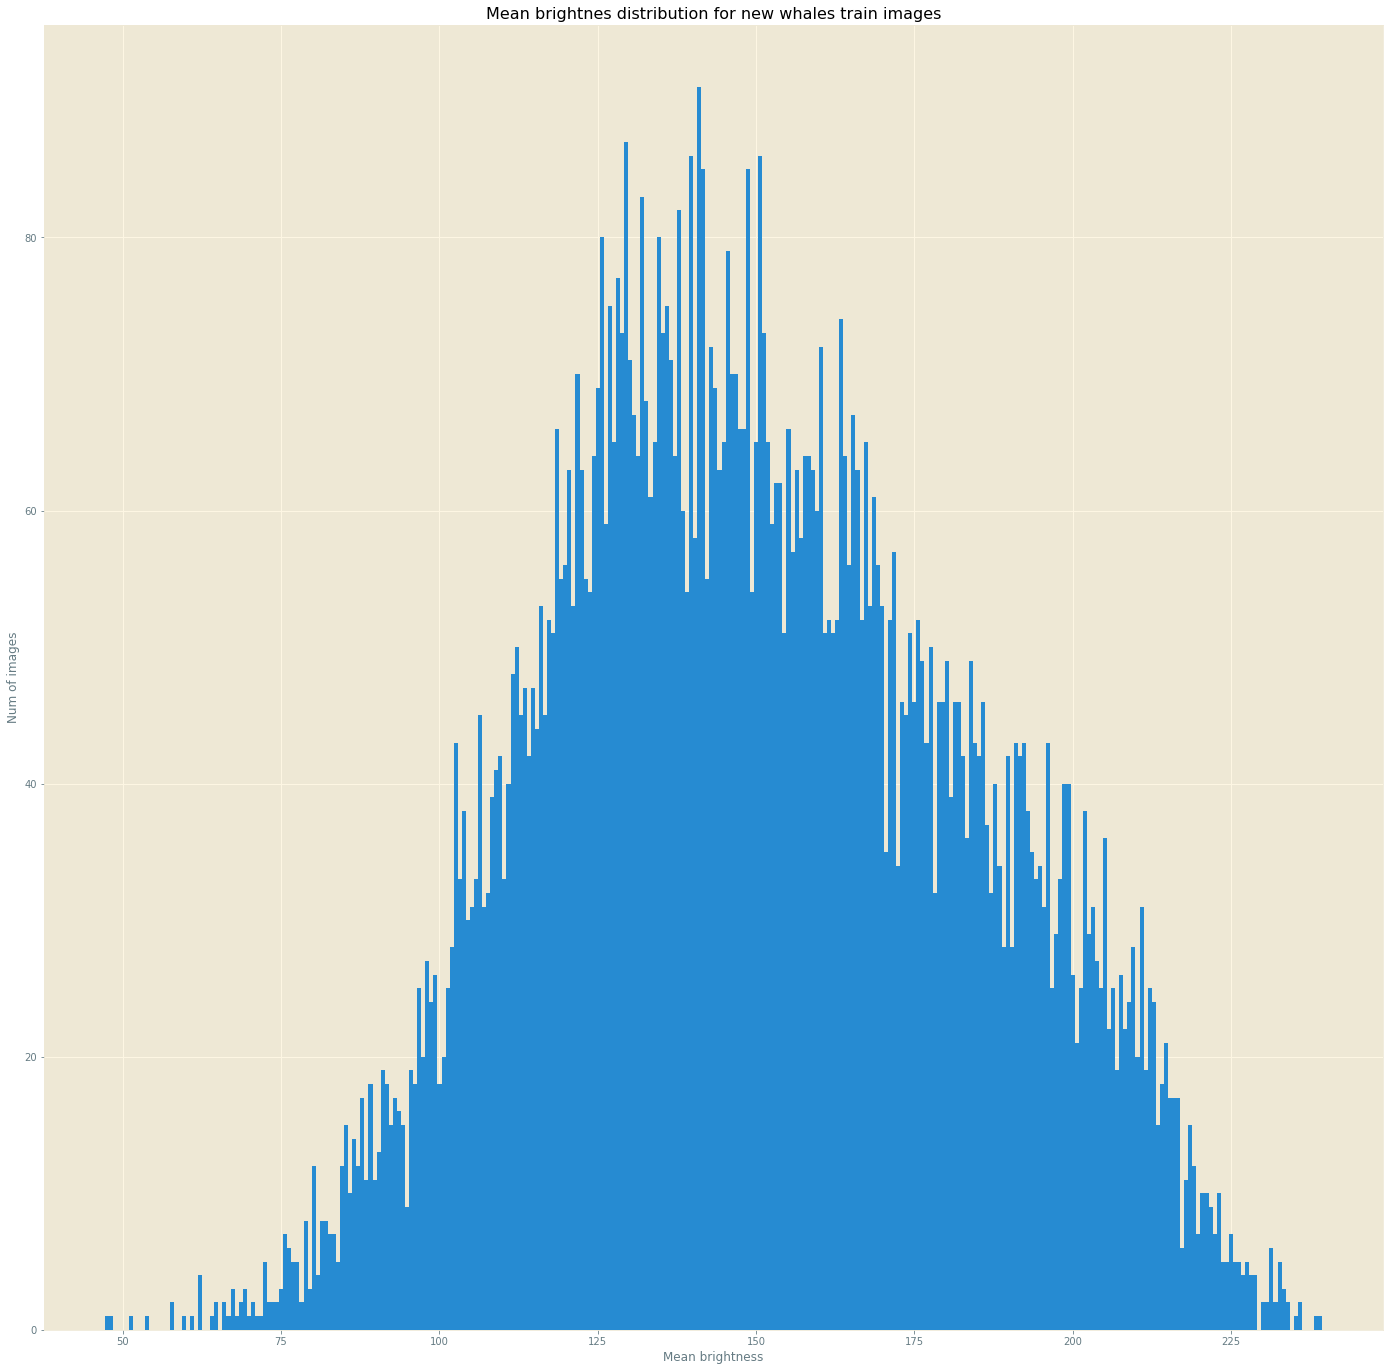

In [110]:
fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)
ax.hist(new_whales_train_images_mean_brightness, bins=300)
ax.set_title("Mean brightnes distribution for new whales train images")
#ax.set(title="Mean brightnes distribution for images with chips")
ax.set_xlabel("Mean brightness")
ax.set_ylabel("Num of images")
plt.show()

In [111]:
type(group_by_id_train_images_description_df)

pandas.core.groupby.groupby.DataFrameGroupBy

In [115]:
#group_by_id_train_images_description_df

In [117]:
tuple(whales_train_images_dict.items())[:4]

(('4fa457dc6.jpg', array([[[ 60,  98, 135],
          [ 59,  97, 134],
          [ 53,  91, 128],
          ...,
          [132, 130, 151],
          [131, 129, 151],
          [130, 128, 150]],
  
         [[ 61,  99, 136],
          [ 61,  99, 136],
          [ 57,  95, 132],
          ...,
          [134, 132, 153],
          [135, 133, 154],
          [135, 133, 154]],
  
         [[ 58,  96, 133],
          [ 59,  97, 134],
          [ 57,  95, 132],
          ...,
          [140, 139, 157],
          [138, 136, 157],
          [138, 136, 157]],
  
         ...,
  
         [[  3,  52,  66],
          [  4,  53,  67],
          [  6,  55,  69],
          ...,
          [ 61, 107, 141],
          [ 63, 107, 142],
          [ 64, 108, 143]],
  
         [[  0,  50,  61],
          [  0,  52,  63],
          [  2,  54,  65],
          ...,
          [ 47,  96, 128],
          [ 47,  96, 128],
          [ 50,  99, 132]],
  
         [[  0,  50,  61],
          [  1,  53,  64],
       

In [118]:
image_sizes_list = []
for image_name, image in whales_train_images_dict.items():
    image_sizes_list.append(
        [
            image_name,
            image.shape[0],
            image.shape[1],
            1 if len(image.shape) == 2 else image.shape[2]
        ]
    )
    

In [119]:
image_sizes_list[:4]

[['4fa457dc6.jpg', 631, 1050, 3],
 ['47a1e0a6e.jpg', 361, 1050, 3],
 ['f1484122e.jpg', 600, 1050, 3],
 ['534284730.jpg', 555, 729, 3]]

In [120]:
image_sizes_df = pd.DataFrame(columns=['Image', 'Height', 'Width', 'ColorChannelsNum'], data=image_sizes_list)

In [121]:
image_sizes_df.head()

Image  Height  Width  ColorChannelsNum
0  4fa457dc6.jpg     631   1050                 3
1  47a1e0a6e.jpg     361   1050                 3
2  f1484122e.jpg     600   1050                 3
3  534284730.jpg     555    729                 3
4  8d7319156.jpg     600   1050                 3

In [122]:
image_sizes_df.tail()

Image  Height  Width  ColorChannelsNum
25356  8087f2535.jpg     450   1050                 3
25357  20642425b.jpg     700   1800                 1
25358  f0d040632.jpg     304   1050                 3
25359  da83595c8.jpg     436   1050                 3
25360  61e1df060.jpg     384    671                 3

In [123]:
train_images_description_df.shape

(25361, 2)

In [124]:
image_sizes_df.shape

(25361, 4)

In [125]:
train_images_extended_description_df = pd.merge(train_images_description_df, image_sizes_df, on='Image')

In [126]:
train_images_extended_description_df.shape

(25361, 5)

In [127]:
train_images_extended_description_df.head()

Image         Id  Height  Width  ColorChannelsNum
0  0000e88ab.jpg  w_f48451c     700   1050                 3
1  0001f9222.jpg  w_c3d896a     325    758                 3
2  00029d126.jpg  w_20df2c5     497   1050                 3
3  00050a15a.jpg  new_whale     525   1050                 3
4  0005c1ef8.jpg  new_whale     525   1050                 3

In [128]:
train_images_extended_description_df.tail()

Image         Id  Height  Width  ColorChannelsNum
25356  ffef89eed.jpg  w_9c506f6     600   1050                 3
25357  fff7faf61.jpg  w_9cf0388     469   1050                 3
25358  fff9002e0.jpg  w_bd1c3d5     700   1050                 3
25359  fffcde6fe.jpg  w_9f30885     600    900                 1
25360  fffde072b.jpg  new_whale     652   1000                 3

In [132]:
train_images_grouped_by_size = train_images_extended_description_df.groupby(['Height', 'Width', 'ColorChannelsNum'])

In [133]:
train_images_grouped_by_size_count_df = train_images_grouped_by_size.count()

In [134]:
train_images_grouped_by_size_count_df.head()

Image  Id
Height Width ColorChannelsNum           
30     77    3                     1   1
47     152   3                     1   1
57     305   1                     1   1
70     231   3                     1   1
72     327   3                     1   1

In [135]:
train_images_grouped_by_size_count_df.tail()

Image  Id
Height Width ColorChannelsNum           
1379   1050  3                     1   1
1476   1050  3                     1   1
1500   1000  3                     1   1
1572   1050  3                     1   1
1575   1050  3                     1   1

In [136]:
train_images_grouped_by_id = train_images_extended_description_df.groupby('Id')

In [146]:
for item in train_images_grouped_by_id:
    #print(type(item[1]))
    print(item)
    print("Id: ", item[0])
    print(item[1].groupby(['Height', 'Width', 'ColorChannelsNum']).count())

('new_whale',                Image         Id  Height  Width  ColorChannelsNum
3      00050a15a.jpg  new_whale     525   1050                 3
4      0005c1ef8.jpg  new_whale     525   1050                 3
5      0006e997e.jpg  new_whale     276    980                 3
7      000f0f2bf.jpg  new_whale     700   1050                 3
11     001d7450c.jpg  new_whale     600   1050                 1
12     00200e115.jpg  new_whale     600   1050                 1
13     00245a598.jpg  new_whale     450   1050                 3
14     002b4615d.jpg  new_whale     492   1050                 3
15     002f99f01.jpg  new_whale     590    886                 3
18     003795857.jpg  new_whale     329   1050                 3
19     0041880bf.jpg  new_whale     500    700                 1
20     0043da555.jpg  new_whale     717    984                 3
22     00464ff65.jpg  new_whale     768   1050                 3
24     004ae9e26.jpg  new_whale     305   1050                 3
25     004c

('w_00b3dc2',              Image         Id  Height  Width  ColorChannelsNum
383  03be3723c.jpg  w_00b3dc2     450   1050                 3)
Image:  w_00b3dc2
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_00d50c9',                Image         Id  Height  Width  ColorChannelsNum
2799   1cc6523fc.jpg  w_00d50c9     719   1050                 3
7085   47d9ad983.jpg  w_00d50c9     672   1050                 3
9905   645300669.jpg  w_00d50c9     701   1050                 3
18428  b94450f8e.jpg  w_00d50c9     293   1050                 3
18787  bd3f7ba02.jpg  w_00d50c9     255    375                 3
19982  c938f9d6f.jpg  w_00d50c9     402   1050                 3)
Image:  w_00d50c9
                               Image  Id
Height Width ColorChannelsNum           
255    375   3                     1   1
293    1050  3                     1   1
402    1050  3                     1   1
672    1050  3           

                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1
('w_01cb0c4',                Image         Id  Height  Width  ColorChannelsNum
10057  65d9f620f.jpg  w_01cb0c4     357   1536                 1
18174  b6918b6a7.jpg  w_01cb0c4     280   1050                 3
19634  c5ea2206c.jpg  w_01cb0c4     742   1045                 1)
Image:  w_01cb0c4
                               Image  Id
Height Width ColorChannelsNum           
280    1050  3                     1   1
357    1536  1                     1   1
742    1045  1                     1   1
('w_01cbbbd',                Image         Id  Height  Width  ColorChannelsNum
554    056472b40.jpg  w_01cbbbd     274   1050                 3
972    0988577d9.jpg  w_01cbbbd     301   1050                 3
7259   49ae08129.jpg  w_01cbbbd     522   1050                 3
10899  6eb58cbba.jpg  w_01cbbbd     198   1050                 3
15267  99b7c75cf.jpg  w_01cbbbd     347 

('w_0292e15',                Image         Id  Height  Width  ColorChannelsNum
5632   39a3458a3.jpg  w_0292e15     700   1050                 3
7355   4aa059911.jpg  w_0292e15     700   1050                 3
15776  9ef9d541e.jpg  w_0292e15     701   1050                 3
16942  aa5331a49.jpg  w_0292e15     701   1050                 3)
Image:  w_0292e15
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
701    1050  3                     2   2
('w_02aa597',                Image         Id  Height  Width  ColorChannelsNum
3217   2110619d0.jpg  w_02aa597     312   1050                 3
4821   315b78d9a.jpg  w_02aa597     462   1050                 3
8766   5918c5af2.jpg  w_02aa597     699   1050                 3
13859  8ba2a856c.jpg  w_02aa597     700   1050                 3
17238  ad1a1eaeb.jpg  w_02aa597     282   1050                 3
23511  ecad60b15.jpg  w_02aa597     400   1050                 3
24450  f6

                               Image  Id
Height Width ColorChannelsNum           
548    1050  3                     1   1
('w_048bc73',                Image         Id  Height  Width  ColorChannelsNum
17430  aec907ad2.jpg  w_048bc73     700   1050                 3)
Image:  w_048bc73
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_049ae2e',                Image         Id  Height  Width  ColorChannelsNum
9613   615e056f1.jpg  w_049ae2e     600   1050                 3
21728  da76d0dc4.jpg  w_049ae2e     700   1050                 3
24634  f7d525070.jpg  w_049ae2e     432   1050                 3)
Image:  w_049ae2e
                               Image  Id
Height Width ColorChannelsNum           
432    1050  3                     1   1
600    1050  3                     1   1
700    1050  3                     1   1
('w_04acf95',                Image         Id  Height  Width  ColorChannelsNum
6317   409e078

                               Image  Id
Height Width ColorChannelsNum           
251    1050  3                     1   1
609    1218  1                     1   1
628    1050  3                     1   1
('w_06313c8',                Image         Id  Height  Width  ColorChannelsNum
21173  d53a5dedc.jpg  w_06313c8     450   1050                 3)
Image:  w_06313c8
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_063282e',                Image         Id  Height  Width  ColorChannelsNum
25019  fc3c3dd2d.jpg  w_063282e     525   1050                 3)
Image:  w_063282e
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_0637181',                Image         Id  Height  Width  ColorChannelsNum
1674   10d70d58b.jpg  w_0637181     392   1050                 3
5132   34b2265fe.jpg  w_0637181     477   1050                 3
20377  cd520d8

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_0729126',                Image         Id  Height  Width  ColorChannelsNum
14260  8f947b924.jpg  w_0729126     450    900                 3)
Image:  w_0729126
                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1
('w_072f593',                Image         Id  Height  Width  ColorChannelsNum
252    027f1594f.jpg  w_072f593     529    792                 3
15357  9abdda709.jpg  w_072f593     700   1050                 3)
Image:  w_072f593
                               Image  Id
Height Width ColorChannelsNum           
529    792   3                     1   1
700    1050  3                     1   1
('w_0741282',                Image         Id  Height  Width  ColorChannelsNum
24294  f49347c85.jpg  w_0741282     700   1050                 3)
Image:  w_0741282
                               Image

                               Image  Id
Height Width ColorChannelsNum           
561    841   3                     1   1
700    1050  3                     1   1
('w_08d5864',                Image         Id  Height  Width  ColorChannelsNum
10567  6b0e212e6.jpg  w_08d5864     525   1050                 3)
Image:  w_08d5864
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_08d62ee',                Image         Id  Height  Width  ColorChannelsNum
1270   0c8fc7db6.jpg  w_08d62ee     700   1050                 3
8899   5a795fffa.jpg  w_08d62ee     698   1050                 3
10443  69bb4fef3.jpg  w_08d62ee     700   1050                 3
14978  96d5ea6ed.jpg  w_08d62ee     700   1050                 3
15575  9d1331572.jpg  w_08d62ee     700   1050                 3
18150  b64dfd7dc.jpg  w_08d62ee     700   1050                 3
21021  d3c7bdeeb.jpg  w_08d62ee     700   1050                 3
22968  e76e9abec

                               Image  Id
Height Width ColorChannelsNum           
227    611   3                     1   1
389    1050  3                     1   1
('w_0a87ea4',                Image         Id  Height  Width  ColorChannelsNum
1388   0dd099302.jpg  w_0a87ea4     600   1050                 3
3431   2358c2bf1.jpg  w_0a87ea4     775   1050                 3
11739  773c603c1.jpg  w_0a87ea4     700   1050                 3
13091  841f38152.jpg  w_0a87ea4     600   1050                 3
20188  cb3450880.jpg  w_0a87ea4     500    701                 1)
Image:  w_0a87ea4
                               Image  Id
Height Width ColorChannelsNum           
500    701   1                     1   1
600    1050  3                     2   2
700    1050  3                     1   1
775    1050  3                     1   1
('w_0a8a451',                Image         Id  Height  Width  ColorChannelsNum
13264  85b20c974.jpg  w_0a8a451     450   1050                 3)
Image:  w_0a8a451
    

('w_0bbc3cb',               Image         Id  Height  Width  ColorChannelsNum
9253  5dea14a9b.jpg  w_0bbc3cb     700   1050                 3)
Image:  w_0bbc3cb
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_0bc078c',                Image         Id  Height  Width  ColorChannelsNum
2846   1d30841d4.jpg  w_0bc078c     788   1050                 3
3019   1ef169d52.jpg  w_0bc078c     124    260                 3
4877   3216ee4c5.jpg  w_0bc078c     263    439                 3
6512   4275b9298.jpg  w_0bc078c     389   1025                 3
6635   438cd2452.jpg  w_0bc078c     700   1050                 3
7767   4e824e5c5.jpg  w_0bc078c     566    663                 3
8665   57fab41e5.jpg  w_0bc078c     375   1050                 3
9334   5e8bd31a3.jpg  w_0bc078c     700   1050                 3
10474  6a0cd4d60.jpg  w_0bc078c     497    901                 3
10855  6e37cdae9.jpg  w_0bc078c     473   1050      

                               Image  Id
Height Width ColorChannelsNum           
547    1050  3                     1   1
600    1050  3                     3   3
('w_0d11fa9',               Image         Id  Height  Width  ColorChannelsNum
2188  16565e831.jpg  w_0d11fa9     525   1050                 3)
Image:  w_0d11fa9
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_0d145d4',                Image         Id  Height  Width  ColorChannelsNum
11871  785aba89d.jpg  w_0d145d4     768   1050                 3
14197  8edef7e0d.jpg  w_0d145d4     675   1050                 3
16387  a505313ac.jpg  w_0d145d4     701   1050                 3)
Image:  w_0d145d4
                               Image  Id
Height Width ColorChannelsNum           
675    1050  3                     1   1
701    1050  3                     1   1
768    1050  3                     1   1
('w_0d1b964',                Image         Id  Height 

                               Image  Id
Height Width ColorChannelsNum           
396    1050  3                     1   1
('w_0e34e76',                Image         Id  Height  Width  ColorChannelsNum
15832  9f7b01613.jpg  w_0e34e76     700   1050                 3)
Image:  w_0e34e76
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_0e35358',                Image         Id  Height  Width  ColorChannelsNum
6662   43c903a46.jpg  w_0e35358     525   1050                 3
17789  b2879be60.jpg  w_0e35358     525   1050                 3)
Image:  w_0e35358
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     2   2
('w_0e4b65e',                Image         Id  Height  Width  ColorChannelsNum
16568  a6b521a21.jpg  w_0e4b65e     700   1050                 3
23611  edb042956.jpg  w_0e4b65e     600   1050                 3)
Image:  w_0e4b65e
            

('w_0f73f48',                Image         Id  Height  Width  ColorChannelsNum
4013   294d8eedc.jpg  w_0f73f48     676   1050                 3
5670   3a05a393f.jpg  w_0f73f48     269   1915                 1
5922   3cc817781.jpg  w_0f73f48     445   1050                 3
7596   4cfcb1a58.jpg  w_0f73f48     390   1050                 3
10100  664014fcc.jpg  w_0f73f48     416   1005                 3
19773  c765f23ab.jpg  w_0f73f48     158    282                 3)
Image:  w_0f73f48
                               Image  Id
Height Width ColorChannelsNum           
158    282   3                     1   1
269    1915  1                     1   1
390    1050  3                     1   1
416    1005  3                     1   1
445    1050  3                     1   1
676    1050  3                     1   1
('w_0f84e7c',                Image         Id  Height  Width  ColorChannelsNum
21477  d802a3f4b.jpg  w_0f84e7c     351   1050                 3)
Image:  w_0f84e7c
                     

                               Image  Id
Height Width ColorChannelsNum           
414    1050  3                     1   1
490    695   3                     1   1
('w_10a4e10',               Image         Id  Height  Width  ColorChannelsNum
9597  61364fc83.jpg  w_10a4e10     525   1050                 3)
Image:  w_10a4e10
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_10b4603',                Image         Id  Height  Width  ColorChannelsNum
4324   2c7666acf.jpg  w_10b4603     700   1050                 3
15173  98b9720b2.jpg  w_10b4603     685   1027                 3)
Image:  w_10b4603
                               Image  Id
Height Width ColorChannelsNum           
685    1027  3                     1   1
700    1050  3                     1   1
('w_10bb1ba',                Image         Id  Height  Width  ColorChannelsNum
2310   17931c6b7.jpg  w_10bb1ba     464   1050                 3
5594   393a27ead

('w_122e247',                Image         Id  Height  Width  ColorChannelsNum
11947  78f9e3201.jpg  w_122e247     380   1003                 3
12594  7f47c615d.jpg  w_122e247     300    525                 3
16562  a69136e45.jpg  w_122e247     313    548                 3)
Image:  w_122e247
                               Image  Id
Height Width ColorChannelsNum           
300    525   3                     1   1
313    548   3                     1   1
380    1003  3                     1   1
('w_122eec1',                Image         Id  Height  Width  ColorChannelsNum
24504  f6b8f1488.jpg  w_122eec1     450   1050                 3)
Image:  w_122eec1
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_1247b8c',                Image         Id  Height  Width  ColorChannelsNum
13488  87e5c449d.jpg  w_1247b8c     700   1050                 3
14346  907556216.jpg  w_1247b8c     600   1050                 3)
Image:

('w_12fdac7',                Image         Id  Height  Width  ColorChannelsNum
2021   145a19d34.jpg  w_12fdac7     380   1050                 3
2304   17821bbd2.jpg  w_12fdac7     455   1050                 3
14511  9203a9ac1.jpg  w_12fdac7     348    765                 3
21880  dc1e92200.jpg  w_12fdac7     524   1050                 3
25100  fd3412716.jpg  w_12fdac7     453   1050                 3)
Image:  w_12fdac7
                               Image  Id
Height Width ColorChannelsNum           
348    765   3                     1   1
380    1050  3                     1   1
453    1050  3                     1   1
455    1050  3                     1   1
524    1050  3                     1   1
('w_12fe3a8',               Image         Id  Height  Width  ColorChannelsNum
4542  2e7383da5.jpg  w_12fe3a8     450   1050                 3)
Image:  w_12fe3a8
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_13

('w_13ca7e8',                Image         Id  Height  Width  ColorChannelsNum
6416   417bd3b34.jpg  w_13ca7e8     297   1050                 3
9411   5f4977d49.jpg  w_13ca7e8     179   1050                 3
9925   6485d9653.jpg  w_13ca7e8     181    721                 3
10740  6cfa2ae33.jpg  w_13ca7e8     203    700                 3
23845  f02fb50df.jpg  w_13ca7e8     240   1050                 3)
Image:  w_13ca7e8
                               Image  Id
Height Width ColorChannelsNum           
179    1050  3                     1   1
181    721   3                     1   1
203    700   3                     1   1
240    1050  3                     1   1
297    1050  3                     1   1
('w_13d4fd0',                Image         Id  Height  Width  ColorChannelsNum
12771  811039b8d.jpg  w_13d4fd0     478   1050                 3
14930  964fe80d3.jpg  w_13d4fd0     260    606                 3)
Image:  w_13d4fd0
                               Image  Id
Height Width ColorCha

('w_1554173',                Image         Id  Height  Width  ColorChannelsNum
1081   0aba2f75b.jpg  w_1554173     525   1050                 3
3504   23f938c11.jpg  w_1554173     525   1050                 3
21142  d4e2a1b48.jpg  w_1554173     525   1050                 3)
Image:  w_1554173
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     3   3
('w_1574bd1',                Image         Id  Height  Width  ColorChannelsNum
11749  774b9f306.jpg  w_1574bd1     700   1050                 3
20300  cc7cf1458.jpg  w_1574bd1     700   1050                 3)
Image:  w_1574bd1
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_1579152',                Image         Id  Height  Width  ColorChannelsNum
23749  ef2e08f19.jpg  w_1579152     700   1800                 1)
Image:  w_1579152
                               Image  Id
Height Width ColorChannelsNum

                               Image  Id
Height Width ColorChannelsNum           
233    592   3                     1   1
589    841   3                     1   1
666    1050  3                     1   1
('w_16c264e',                Image         Id  Height  Width  ColorChannelsNum
7607   4d1c3fcb1.jpg  w_16c264e     600    900                 3
10759  6d24966ed.jpg  w_16c264e     700   1050                 3
23108  e8f67de5b.jpg  w_16c264e     598    897                 3)
Image:  w_16c264e
                               Image  Id
Height Width ColorChannelsNum           
598    897   3                     1   1
600    900   3                     1   1
700    1050  3                     1   1
('w_16dba74',                Image         Id  Height  Width  ColorChannelsNum
5255   35d66a26d.jpg  w_16dba74     600   1050                 1
20125  cab8c05c2.jpg  w_16dba74     600   1050                 1)
Image:  w_16dba74
                               Image  Id
Height Width ColorChannelsNu

('w_17e8846',                Image         Id  Height  Width  ColorChannelsNum
23465  ec464a3c2.jpg  w_17e8846     700   1050                 3)
Image:  w_17e8846
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_17f5d1d',                Image         Id  Height  Width  ColorChannelsNum
11372  7373f47a8.jpg  w_17f5d1d     492    984                 3)
Image:  w_17f5d1d
                               Image  Id
Height Width ColorChannelsNum           
492    984   3                     1   1
('w_17fef9b',                Image         Id  Height  Width  ColorChannelsNum
15724  9e8984392.jpg  w_17fef9b     323    754                 3)
Image:  w_17fef9b
                               Image  Id
Height Width ColorChannelsNum           
323    754   3                     1   1
('w_180e241',                Image         Id  Height  Width  ColorChannelsNum
1129   0b19b0929.jpg  w_180e241     557   1050                 

('w_193bf22',                Image         Id  Height  Width  ColorChannelsNum
10921  6eeb776c2.jpg  w_193bf22     700   1050                 3
16307  a441f2df5.jpg  w_193bf22     700   1050                 3)
Image:  w_193bf22
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_193f83c',               Image         Id  Height  Width  ColorChannelsNum
2723  1bef9ce28.jpg  w_193f83c     600   1050                 3
9088  5c4493c78.jpg  w_193f83c     740   1050                 3)
Image:  w_193f83c
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
740    1050  3                     1   1
('w_19410fe',               Image         Id  Height  Width  ColorChannelsNum
9633  61a53f99c.jpg  w_19410fe     700   1050                 3)
Image:  w_19410fe
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3   

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_1b04c3c',               Image         Id  Height  Width  ColorChannelsNum
7048  477539719.jpg  w_1b04c3c     500    702                 1)
Image:  w_1b04c3c
                               Image  Id
Height Width ColorChannelsNum           
500    702   1                     1   1
('w_1b0c4b7',                Image         Id  Height  Width  ColorChannelsNum
10721  6cd4154a9.jpg  w_1b0c4b7     552   1050                 3
16230  a3880658b.jpg  w_1b0c4b7     638   2253                 1
21334  d6c06bad4.jpg  w_1b0c4b7     654   1900                 1
24844  fa1806d91.jpg  w_1b0c4b7     700   1050                 3)
Image:  w_1b0c4b7
                               Image  Id
Height Width ColorChannelsNum           
552    1050  3                     1   1
638    2253  1                     1   1
654    1900  1                     1   1
700    1050  3                

('w_1c63738',                Image         Id  Height  Width  ColorChannelsNum
6406   415df5ca0.jpg  w_1c63738     414   1050                 3
12627  7fa7b9cd9.jpg  w_1c63738     409   1050                 3)
Image:  w_1c63738
                               Image  Id
Height Width ColorChannelsNum           
409    1050  3                     1   1
414    1050  3                     1   1
('w_1c6465a',                Image         Id  Height  Width  ColorChannelsNum
7551   4c816b397.jpg  w_1c6465a     700   1050                 3
10335  6878f63a6.jpg  w_1c6465a     679   1050                 3
15863  9fcd6e04d.jpg  w_1c6465a     441   1050                 3
16565  a6ad1b8df.jpg  w_1c6465a     121    276                 3
17553  b0142ebe2.jpg  w_1c6465a     578   1050                 3
24206  f3bcd2538.jpg  w_1c6465a     355   1050                 3)
Image:  w_1c6465a
                               Image  Id
Height Width ColorChannelsNum           
121    276   3                     1  

                               Image  Id
Height Width ColorChannelsNum           
396    693   3                     1   1
562    1050  3                     1   1
564    1050  3                     1   1
600    1050  3                     4   4
700    1050  3                     1   1
749    1050  3                     1   1
('w_1d55e83',                Image         Id  Height  Width  ColorChannelsNum
23054  e85760f33.jpg  w_1d55e83     563    875                 3)
Image:  w_1d55e83
                               Image  Id
Height Width ColorChannelsNum           
563    875   3                     1   1
('w_1d6a51b',                Image         Id  Height  Width  ColorChannelsNum
10030  6598ec053.jpg  w_1d6a51b     477   1050                 3)
Image:  w_1d6a51b
                               Image  Id
Height Width ColorChannelsNum           
477    1050  3                     1   1
('w_1d6a9f7',                Image         Id  Height  Width  ColorChannelsNum
18197  b6bfd09f1.jpg 

('w_1ecca2d',                Image         Id  Height  Width  ColorChannelsNum
3107   1fdbd120c.jpg  w_1ecca2d     349   1050                 3
4305   2c597eb8e.jpg  w_1ecca2d     700   1050                 3
5278   360a3a9d0.jpg  w_1ecca2d     429   1050                 3
13669  89b141bdb.jpg  w_1ecca2d     358   1050                 3
24172  f3720cc40.jpg  w_1ecca2d     317   1050                 3)
Image:  w_1ecca2d
                               Image  Id
Height Width ColorChannelsNum           
317    1050  3                     1   1
349    1050  3                     1   1
358    1050  3                     1   1
429    1050  3                     1   1
700    1050  3                     1   1
('w_1ee38d5',                Image         Id  Height  Width  ColorChannelsNum
13817  8b4441e20.jpg  w_1ee38d5     500    700                 1)
Image:  w_1ee38d5
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
('w_

('w_1ff410a',               Image         Id  Height  Width  ColorChannelsNum
7822  4efac1c0c.jpg  w_1ff410a     584    879                 3)
Image:  w_1ff410a
                               Image  Id
Height Width ColorChannelsNum           
584    879   3                     1   1
('w_1ffc4ab',               Image         Id  Height  Width  ColorChannelsNum
3332  225fc829e.jpg  w_1ffc4ab     442   1050                 3
5869  3c3393e26.jpg  w_1ffc4ab     326   1050                 3)
Image:  w_1ffc4ab
                               Image  Id
Height Width ColorChannelsNum           
326    1050  3                     1   1
442    1050  3                     1   1
('w_2009f8b',                Image         Id  Height  Width  ColorChannelsNum
9091   5c4f42de0.jpg  w_2009f8b     374   1050                 3
21053  d414e6318.jpg  w_2009f8b     700   1050                 3
22464  e237e3c09.jpg  w_2009f8b     433   1050                 3
23180  e984b9920.jpg  w_2009f8b     496   1050       

('w_21591ba',               Image         Id  Height  Width  ColorChannelsNum
7068  47af8181e.jpg  w_21591ba     600   1050                 3)
Image:  w_21591ba
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_21666ad',                Image         Id  Height  Width  ColorChannelsNum
23247  ea2631dca.jpg  w_21666ad     700   1800                 1)
Image:  w_21666ad
                               Image  Id
Height Width ColorChannelsNum           
700    1800  1                     1   1
('w_217fc01',                Image         Id  Height  Width  ColorChannelsNum
15911  a05716867.jpg  w_217fc01     450    900                 3
19937  c8baf072e.jpg  w_217fc01     450   1050                 3)
Image:  w_217fc01
                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1
       1050  3                     1   1
('w_218fe4a',                Image    

                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1
('w_234713b',                Image         Id  Height  Width  ColorChannelsNum
393    03e23d88f.jpg  w_234713b     700   1800                 1
885    08cb88f53.jpg  w_234713b     702   1050                 3
3110   1fe16b155.jpg  w_234713b     700   1050                 3
3556   247285a8d.jpg  w_234713b     700   1369                 1
6397   414db13ab.jpg  w_234713b     700   1050                 3
8041   5151783ee.jpg  w_234713b     423    635                 3
8796   596f341e5.jpg  w_234713b     700   1621                 1
10054  65d0f57cf.jpg  w_234713b     700   1800                 1
12137  7af353505.jpg  w_234713b     700   2153                 1
12611  7f6cffd58.jpg  w_234713b     700   1050                 3
13389  86f19621f.jpg  w_234713b     700   1621                 1
14011  8d130aa35.jpg  w_234713b     695   5959                 1
14266  8fa5b069f.j

('w_240cbf9',               Image         Id  Height  Width  ColorChannelsNum
4520  2e2e6b089.jpg  w_240cbf9     585   1050                 3
5979  3d41a8ea2.jpg  w_240cbf9     771   1050                 3)
Image:  w_240cbf9
                               Image  Id
Height Width ColorChannelsNum           
585    1050  3                     1   1
771    1050  3                     1   1
('w_2424e82',                Image         Id  Height  Width  ColorChannelsNum
2994   1eb8eff24.jpg  w_2424e82     450   1050                 3
23448  ec1176e31.jpg  w_2424e82     297   1050                 3)
Image:  w_2424e82
                               Image  Id
Height Width ColorChannelsNum           
297    1050  3                     1   1
450    1050  3                     1   1
('w_242fb46',                Image         Id  Height  Width  ColorChannelsNum
2385   1883237ff.jpg  w_242fb46     600   1050                 3
4173   2aea3c3da.jpg  w_242fb46     714   1050                 3
4530   2e4

                               Image  Id
Height Width ColorChannelsNum           
240    857   3                     1   1
('w_25f1a4e',                Image         Id  Height  Width  ColorChannelsNum
3252   217931746.jpg  w_25f1a4e     450   1050                 3
3273   21bc40388.jpg  w_25f1a4e     473   1050                 3
5509   384e301c8.jpg  w_25f1a4e     600   1050                 3
13232  8574d7725.jpg  w_25f1a4e     425   1050                 3
19580  c562a7f92.jpg  w_25f1a4e     700   1050                 3
20967  d34ff0af0.jpg  w_25f1a4e     469   1050                 3
22527  e2cd8774b.jpg  w_25f1a4e     250    693                 3
23811  efc2b4f77.jpg  w_25f1a4e     196   1050                 3)
Image:  w_25f1a4e
                               Image  Id
Height Width ColorChannelsNum           
196    1050  3                     1   1
250    693   3                     1   1
425    1050  3                     1   1
450    1050  3                     1   1
469    1050  

                               Image  Id
Height Width ColorChannelsNum           
341    1050  3                     1   1
429    1050  3                     1   1
450    1050  3                     3   3
475    1050  3                     1   1
495    940   3                     1   1
525    788   3                     2   2
700    1050  3                     6   6
('w_26db444',                Image         Id  Height  Width  ColorChannelsNum
6402   4158e6b4c.jpg  w_26db444     600   1050                 3
16363  a4c079512.jpg  w_26db444     674    957                 3
21674  d9f052261.jpg  w_26db444     362   1050                 3)
Image:  w_26db444
                               Image  Id
Height Width ColorChannelsNum           
362    1050  3                     1   1
600    1050  3                     1   1
674    957   3                     1   1
('w_26e4f44',              Image         Id  Height  Width  ColorChannelsNum
235  02568e465.jpg  w_26e4f44     754   1050            

                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     2   2
('w_277d911',                Image         Id  Height  Width  ColorChannelsNum
11811  77d56f499.jpg  w_277d911     525   1050                 3)
Image:  w_277d911
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_27a6304',                Image         Id  Height  Width  ColorChannelsNum
1653   10a2e6007.jpg  w_27a6304     700   1050                 3
1675   10d7b878a.jpg  w_27a6304     600   1050                 3
3927   281fcf995.jpg  w_27a6304     600   1050                 3
13182  84e0b393f.jpg  w_27a6304     600   1050                 3
13587  88da7d67a.jpg  w_27a6304     236    413                 3
15994  a1027a724.jpg  w_27a6304     600   1050                 3
18747  bcb33a263.jpg  w_27a6304     474    829                 3
21356  d6e78e123.jpg  w_27a6304     562    985           

                               Image  Id
Height Width ColorChannelsNum           
350    1050  3                     1   1
578    877   3                     1   1
('w_291cba5',               Image         Id  Height  Width  ColorChannelsNum
5804  3b6294a2e.jpg  w_291cba5     495   1050                 3)
Image:  w_291cba5
                               Image  Id
Height Width ColorChannelsNum           
495    1050  3                     1   1
('w_2926c77',                Image         Id  Height  Width  ColorChannelsNum
5683   3a182a63c.jpg  w_2926c77     527   1050                 3
13448  878197fb3.jpg  w_2926c77     525   1050                 3)
Image:  w_2926c77
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
527    1050  3                     1   1
('w_292956e',               Image         Id  Height  Width  ColorChannelsNum
8791  5963f163c.jpg  w_292956e     450   1050                 3)
Image:  w_292956e

('w_2a7603f',                Image         Id  Height  Width  ColorChannelsNum
14995  96fbb9e3e.jpg  w_2a7603f     383    574                 3)
Image:  w_2a7603f
                               Image  Id
Height Width ColorChannelsNum           
383    574   3                     1   1
('w_2a7c1af',                Image         Id  Height  Width  ColorChannelsNum
6933   466c0102b.jpg  w_2a7c1af     359    640                 3
23863  f0572d3af.jpg  w_2a7c1af     196   1050                 3)
Image:  w_2a7c1af
                               Image  Id
Height Width ColorChannelsNum           
196    1050  3                     1   1
359    640   3                     1   1
('w_2a7f00f',                Image         Id  Height  Width  ColorChannelsNum
5465   37e6b4237.jpg  w_2a7f00f     701   1050                 3
15939  a08c83d9e.jpg  w_2a7f00f     700   1050                 3
19264  c218025b8.jpg  w_2a7f00f     700   1050                 3
21485  d810d0079.jpg  w_2a7f00f     700   1050  

('w_2b1b04e',               Image         Id  Height  Width  ColorChannelsNum
8717  5884c7434.jpg  w_2b1b04e     700   1050                 3)
Image:  w_2b1b04e
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_2b388fe',                Image         Id  Height  Width  ColorChannelsNum
5856   3bfde7c49.jpg  w_2b388fe     307   1046                 3
15455  9bbe5297c.jpg  w_2b388fe     463   1050                 3
20245  cbd894388.jpg  w_2b388fe     379   1050                 3)
Image:  w_2b388fe
                               Image  Id
Height Width ColorChannelsNum           
307    1046  3                     1   1
379    1050  3                     1   1
463    1050  3                     1   1
('w_2b39f31',                Image         Id  Height  Width  ColorChannelsNum
7510   4c1eaaf70.jpg  w_2b39f31     700   1050                 3
21985  dd214a972.jpg  w_2b39f31     700   1050                 3
24398  f5

('w_2d3ef19',                Image         Id  Height  Width  ColorChannelsNum
11744  7742e489f.jpg  w_2d3ef19     699   1050                 3)
Image:  w_2d3ef19
                               Image  Id
Height Width ColorChannelsNum           
699    1050  3                     1   1
('w_2d5492b',                Image         Id  Height  Width  ColorChannelsNum
15764  9ee24c7c6.jpg  w_2d5492b     553   1050                 3)
Image:  w_2d5492b
                               Image  Id
Height Width ColorChannelsNum           
553    1050  3                     1   1
('w_2d5b0e1',                Image         Id  Height  Width  ColorChannelsNum
12722  80ab3c372.jpg  w_2d5b0e1     586    879                 3
20785  d141fb396.jpg  w_2d5b0e1     588    882                 3)
Image:  w_2d5b0e1
                               Image  Id
Height Width ColorChannelsNum           
586    879   3                     1   1
588    882   3                     1   1
('w_2d5dc31',                Image  

('w_2e54183',                Image         Id  Height  Width  ColorChannelsNum
10805  6da232ada.jpg  w_2e54183     675   1050                 3
18403  b8ef3a245.jpg  w_2e54183     600   1050                 3)
Image:  w_2e54183
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
675    1050  3                     1   1
('w_2e5ad54',               Image         Id  Height  Width  ColorChannelsNum
6497  425b445da.jpg  w_2e5ad54     700   1050                 3)
Image:  w_2e5ad54
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_2e5d992',                Image         Id  Height  Width  ColorChannelsNum
10917  6ee4e7f28.jpg  w_2e5d992     600   1050                 1)
Image:  w_2e5d992
                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     1   1
('w_2e69752',                Image    

('w_2f79ae3',                Image         Id  Height  Width  ColorChannelsNum
13377  86d724807.jpg  w_2f79ae3     527   1050                 3)
Image:  w_2f79ae3
                               Image  Id
Height Width ColorChannelsNum           
527    1050  3                     1   1
('w_2f841ea',                Image         Id  Height  Width  ColorChannelsNum
13502  87fc2e6d7.jpg  w_2f841ea     700   1050                 3)
Image:  w_2f841ea
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_2f87cc7',                Image         Id  Height  Width  ColorChannelsNum
6846   457016b50.jpg  w_2f87cc7     388   1050                 3
12764  8106d9d50.jpg  w_2f87cc7     727   1050                 3
17322  add261afe.jpg  w_2f87cc7     455    758                 3
22380  e137ae989.jpg  w_2f87cc7     537   1050                 3)
Image:  w_2f87cc7
                               Image  Id
Height Width ColorChannelsNum

('w_30f2f0f',                Image         Id  Height  Width  ColorChannelsNum
1248   0c5537f22.jpg  w_30f2f0f     420   1050                 3
2292   174b35e73.jpg  w_30f2f0f     411    954                 3
8442   559706d7e.jpg  w_30f2f0f     384   1050                 3
10809  6dabeae0e.jpg  w_30f2f0f     396   1050                 3
12340  7ccb46ea2.jpg  w_30f2f0f     368    769                 3
13675  89bf0987d.jpg  w_30f2f0f     393    817                 3
14705  93ee3c598.jpg  w_30f2f0f     602   1050                 3
16171  a2f8ca3b7.jpg  w_30f2f0f     450   1050                 3
17578  b05092be9.jpg  w_30f2f0f     597   1050                 3
18751  bcbd5b4bc.jpg  w_30f2f0f     450   1050                 3
22955  e730e6d24.jpg  w_30f2f0f     425   1050                 3
23291  ea925b05b.jpg  w_30f2f0f     464   1050                 3)
Image:  w_30f2f0f
                               Image  Id
Height Width ColorChannelsNum           
368    769   3                     1   1

                               Image  Id
Height Width ColorChannelsNum           
351    1050  3                     1   1
('w_3224f68',                Image         Id  Height  Width  ColorChannelsNum
855    087499d68.jpg  w_3224f68     701   1050                 3
18234  b728ef1e9.jpg  w_3224f68     701   1050                 3
21953  dce1870cc.jpg  w_3224f68     700   1050                 3)
Image:  w_3224f68
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
701    1050  3                     2   2
('w_3250a08',                Image         Id  Height  Width  ColorChannelsNum
5536   3884b7082.jpg  w_3250a08     342   1050                 3
9915   646aba3d6.jpg  w_3250a08     383    895                 3
18971  bf14686c7.jpg  w_3250a08     596    894                 3)
Image:  w_3250a08
                               Image  Id
Height Width ColorChannelsNum           
342    1050  3                     1   1
383 

('w_3384715',                Image         Id  Height  Width  ColorChannelsNum
16341  a49aead12.jpg  w_3384715     700   1050                 3)
Image:  w_3384715
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_33979b1',               Image         Id  Height  Width  ColorChannelsNum
3509  240995a47.jpg  w_33979b1     327    640                 3)
Image:  w_33979b1
                               Image  Id
Height Width ColorChannelsNum           
327    640   3                     1   1
('w_33aaa44',               Image         Id  Height  Width  ColorChannelsNum
3278  21cca731e.jpg  w_33aaa44     497   1050                 3)
Image:  w_33aaa44
                               Image  Id
Height Width ColorChannelsNum           
497    1050  3                     1   1
('w_33eb301',                Image         Id  Height  Width  ColorChannelsNum
24060  f244178e4.jpg  w_33eb301     624    946                 3)
I

                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_3499014',                Image         Id  Height  Width  ColorChannelsNum
17413  aea74e88d.jpg  w_3499014     524    804                 3
25133  fda0d1f39.jpg  w_3499014     700   1050                 3)
Image:  w_3499014
                               Image  Id
Height Width ColorChannelsNum           
524    804   3                     1   1
700    1050  3                     1   1
('w_349c277',                Image         Id  Height  Width  ColorChannelsNum
12881  821760206.jpg  w_349c277     600   1050                 3)
Image:  w_349c277
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_34afc43',                Image         Id  Height  Width  ColorChannelsNum
1383   0dc377531.jpg  w_34afc43     363   1050                 3
22635  e3d9aeff1.jpg  w_34afc43     470   1050         

('w_363a5aa',                Image         Id  Height  Width  ColorChannelsNum
24977  fbabfb18c.jpg  w_363a5aa     700   1050                 3)
Image:  w_363a5aa
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_3643be7',                Image         Id  Height  Width  ColorChannelsNum
7878   4f75c32a6.jpg  w_3643be7     600   1050                 3
8151   5291a96ea.jpg  w_3643be7     445   1050                 3
12782  812634571.jpg  w_3643be7     750   1050                 3
19474  c462e902f.jpg  w_3643be7     750   1050                 3
20898  d2a18b724.jpg  w_3643be7     700   1050                 3
22548  e2f802201.jpg  w_3643be7     600   1050                 3
24910  fae8fb4ce.jpg  w_3643be7     244   1050                 3)
Image:  w_3643be7
                               Image  Id
Height Width ColorChannelsNum           
244    1050  3                     1   1
445    1050  3                     1  

                               Image  Id
Height Width ColorChannelsNum           
268    1050  3                     1   1
354    1050  3                     1   1
481    792   3                     1   1
('w_37d2f3a',                Image         Id  Height  Width  ColorChannelsNum
506    04d275a05.jpg  w_37d2f3a     412   1050                 3
1420   0e27b36d2.jpg  w_37d2f3a     704   1050                 3
1978   13e6f3e37.jpg  w_37d2f3a     457   1050                 3
2165   1614e216e.jpg  w_37d2f3a     441   1050                 3
5932   3cd9242f5.jpg  w_37d2f3a     271    451                 3
5976   3d3530433.jpg  w_37d2f3a     700   1050                 3
6460   41f7d1047.jpg  w_37d2f3a     406   1050                 3
6506   426a28a9a.jpg  w_37d2f3a     667   1000                 3
13064  83d05c936.jpg  w_37d2f3a     532    926                 3
21008  d3a51d271.jpg  w_37d2f3a     214    415                 3
21838  dba646530.jpg  w_37d2f3a     545   1050                 3
2

('w_38b8bda',                Image         Id  Height  Width  ColorChannelsNum
15681  9e0dcbfaa.jpg  w_38b8bda     520   1019                 1)
Image:  w_38b8bda
                               Image  Id
Height Width ColorChannelsNum           
520    1019  1                     1   1
('w_38c0639',               Image         Id  Height  Width  ColorChannelsNum
5729  3a96adf97.jpg  w_38c0639     600    900                 3
8978  5b313eb4d.jpg  w_38c0639     700   1050                 3)
Image:  w_38c0639
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1
700    1050  3                     1   1
('w_38c5952',                Image         Id  Height  Width  ColorChannelsNum
14226  8f3c44c0d.jpg  w_38c5952     700   1050                 3
14724  942ab5de3.jpg  w_38c5952     576    789                 3)
Image:  w_38c5952
                               Image  Id
Height Width ColorChannelsNum           
576    789   3 

('w_3a1969c',                Image         Id  Height  Width  ColorChannelsNum
12990  830ab6274.jpg  w_3a1969c     297    693                 3)
Image:  w_3a1969c
                               Image  Id
Height Width ColorChannelsNum           
297    693   3                     1   1
('w_3a1e62f',                Image         Id  Height  Width  ColorChannelsNum
14351  9086b3d6e.jpg  w_3a1e62f     471    824                 1
16991  aae00cab5.jpg  w_3a1e62f     321    560                 1)
Image:  w_3a1e62f
                               Image  Id
Height Width ColorChannelsNum           
321    560   1                     1   1
471    824   1                     1   1
('w_3a241cf',                Image         Id  Height  Width  ColorChannelsNum
8002   50cd1a156.jpg  w_3a241cf     527   1050                 3
10799  6d96d176b.jpg  w_3a241cf     583   1050                 3
12729  80bb0308d.jpg  w_3a241cf     355    810                 3)
Image:  w_3a241cf
                             

('w_3bdf2c6',                Image         Id  Height  Width  ColorChannelsNum
5475   380b00a32.jpg  w_3bdf2c6     308    719                 3
6484   422cfcdb3.jpg  w_3bdf2c6     441   1050                 3
7011   4726d0f60.jpg  w_3bdf2c6     354    786                 3
11190  71a0c3d2b.jpg  w_3bdf2c6     693   1050                 3)
Image:  w_3bdf2c6
                               Image  Id
Height Width ColorChannelsNum           
308    719   3                     1   1
354    786   3                     1   1
441    1050  3                     1   1
693    1050  3                     1   1
('w_3bf2653',                Image         Id  Height  Width  ColorChannelsNum
1922   1340acb92.jpg  w_3bf2653     367   1050                 3
3549   2463ec2a1.jpg  w_3bf2653     196   1050                 3
3827   27401e8a9.jpg  w_3bf2653     187    534                 3
4365   2ccf1556c.jpg  w_3bf2653     177    809                 3
8867   5a2476586.jpg  w_3bf2653     305    942           

                               Image  Id
Height Width ColorChannelsNum           
630    1050  3                     1   1
('w_3d7dbf1',                Image         Id  Height  Width  ColorChannelsNum
20054  c9e4f6d41.jpg  w_3d7dbf1     386    640                 3)
Image:  w_3d7dbf1
                               Image  Id
Height Width ColorChannelsNum           
386    640   3                     1   1
('w_3d834ed',                Image         Id  Height  Width  ColorChannelsNum
3751   267fa93df.jpg  w_3d834ed     341   1050                 3
17748  b20daff59.jpg  w_3d834ed     450   1050                 3)
Image:  w_3d834ed
                               Image  Id
Height Width ColorChannelsNum           
341    1050  3                     1   1
450    1050  3                     1   1
('w_3d88ad4',              Image         Id  Height  Width  ColorChannelsNum
758  0786c0a3e.jpg  w_3d88ad4     599    900                 3)
Image:  w_3d88ad4
                               Image  Id

                               Image  Id
Height Width ColorChannelsNum           
211    505   3                     1   1
562    1050  3                     1   1
('w_3e4a1a5',                Image         Id  Height  Width  ColorChannelsNum
16167  a2eed8866.jpg  w_3e4a1a5     450   1050                 3
19043  bfb78085e.jpg  w_3e4a1a5     267   1050                 3)
Image:  w_3e4a1a5
                               Image  Id
Height Width ColorChannelsNum           
267    1050  3                     1   1
450    1050  3                     1   1
('w_3e4b155',                Image         Id  Height  Width  ColorChannelsNum
167    0198f6931.jpg  w_3e4b155     268   2644                 1
4389   2d03705d1.jpg  w_3e4b155     410    894                 3
5720   3a7a0ef0d.jpg  w_3e4b155     700   1050                 3
10793  6d84ecfc0.jpg  w_3e4b155     464    873                 3)
Image:  w_3e4b155
                               Image  Id
Height Width ColorChannelsNum           
268 

                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_3f915dc',                Image         Id  Height  Width  ColorChannelsNum
15466  9bcd0499a.jpg  w_3f915dc     525   1050                 3
23757  ef3acb11e.jpg  w_3f915dc     525   1050                 3)
Image:  w_3f915dc
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     2   2
('w_3f93ee8',                Image         Id  Height  Width  ColorChannelsNum
6401   41515c3b9.jpg  w_3f93ee8     546   1050                 3
10126  667ba845d.jpg  w_3f93ee8     430   1002                 3
25282  ff24ffdd1.jpg  w_3f93ee8     584    879                 3)
Image:  w_3f93ee8
                               Image  Id
Height Width ColorChannelsNum           
430    1002  3                     1   1
546    1050  3                     1   1
584    879   3                     1   1
('w_3fadd3e',               

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_412b5ad',                Image         Id  Height  Width  ColorChannelsNum
1105   0aec375db.jpg  w_412b5ad     388    875                 3
2601   1a9cac968.jpg  w_412b5ad     700   1050                 3
19106  c08451a43.jpg  w_412b5ad     252   1050                 3
21584  d9109bef1.jpg  w_412b5ad     670   1050                 3)
Image:  w_412b5ad
                               Image  Id
Height Width ColorChannelsNum           
252    1050  3                     1   1
388    875   3                     1   1
670    1050  3                     1   1
700    1050  3                     1   1
('w_41301dd',                Image         Id  Height  Width  ColorChannelsNum
3412   2321e8f39.jpg  w_41301dd     328   1050                 3
19777  c77382ff4.jpg  w_41301dd     450    900                 3)
Image:  w_41301dd
                               Image  Id
Heig

('w_428f3c0',               Image         Id  Height  Width  ColorChannelsNum
3201  20e2893a4.jpg  w_428f3c0     700   1050                 3)
Image:  w_428f3c0
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_42b0064',                Image         Id  Height  Width  ColorChannelsNum
486    04a49dade.jpg  w_42b0064     560    840                 3
19543  c4fc056a1.jpg  w_42b0064     700   1050                 3)
Image:  w_42b0064
                               Image  Id
Height Width ColorChannelsNum           
560    840   3                     1   1
700    1050  3                     1   1
('w_42c1a3c',                Image         Id  Height  Width  ColorChannelsNum
4854   31c99c308.jpg  w_42c1a3c     355   1050                 3
20936  d3001c5af.jpg  w_42c1a3c     507   1050                 3)
Image:  w_42c1a3c
                               Image  Id
Height Width ColorChannelsNum           
355    1050  3

('w_44803e4',                Image         Id  Height  Width  ColorChannelsNum
21548  d8aacb605.jpg  w_44803e4     500    700                 1)
Image:  w_44803e4
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
('w_4488584',                Image         Id  Height  Width  ColorChannelsNum
12375  7d45160c1.jpg  w_4488584     262   1050                 3
13656  89934c69c.jpg  w_4488584     272   1050                 3)
Image:  w_4488584
                               Image  Id
Height Width ColorChannelsNum           
262    1050  3                     1   1
272    1050  3                     1   1
('w_448e190',                Image         Id  Height  Width  ColorChannelsNum
10463  69ee68eda.jpg  w_448e190     302    453                 3)
Image:  w_448e190
                               Image  Id
Height Width ColorChannelsNum           
302    453   3                     1   1
('w_44a3ca5',                Image  

('w_45c5396',               Image         Id  Height  Width  ColorChannelsNum
4117  2a594f207.jpg  w_45c5396     808   1050                 3
8971  5b22e19c7.jpg  w_45c5396     600   1050                 3)
Image:  w_45c5396
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
808    1050  3                     1   1
('w_45d33bf',                Image         Id  Height  Width  ColorChannelsNum
6602   43475b946.jpg  w_45d33bf     700   1050                 3
10866  6e4b688c7.jpg  w_45d33bf     700   1050                 3)
Image:  w_45d33bf
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_45df6b0',                Image         Id  Height  Width  ColorChannelsNum
1356   0d84680c3.jpg  w_45df6b0     302   1050                 3
25039  fc63830c0.jpg  w_45df6b0     428   1050                 3)
Image:  w_45df6b0
                               I

('w_47098f8',                Image         Id  Height  Width  ColorChannelsNum
6741   448614137.jpg  w_47098f8     525   1050                 3
18376  b8a167800.jpg  w_47098f8     450   1050                 3)
Image:  w_47098f8
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
525    1050  3                     1   1
('w_470be90',                Image         Id  Height  Width  ColorChannelsNum
11297  72ca152f3.jpg  w_470be90     621   1050                 3
23468  ec495d648.jpg  w_470be90     359   1050                 3)
Image:  w_470be90
                               Image  Id
Height Width ColorChannelsNum           
359    1050  3                     1   1
621    1050  3                     1   1
('w_472b51c',                Image         Id  Height  Width  ColorChannelsNum
8449   55a5839e2.jpg  w_472b51c     236    922                 3
8966   5b19a6f49.jpg  w_472b51c     727   1050                 3
14170  

('w_490d198',               Image         Id  Height  Width  ColorChannelsNum
9168  5d190aaab.jpg  w_490d198     296   1050                 3)
Image:  w_490d198
                               Image  Id
Height Width ColorChannelsNum           
296    1050  3                     1   1
('w_491b2e5',                Image         Id  Height  Width  ColorChannelsNum
7766   4e81f0d2c.jpg  w_491b2e5     378    567                 3
25237  fe9acb418.jpg  w_491b2e5     600    900                 3)
Image:  w_491b2e5
                               Image  Id
Height Width ColorChannelsNum           
378    567   3                     1   1
600    900   3                     1   1
('w_491bdcb',               Image         Id  Height  Width  ColorChannelsNum
1941  13811796a.jpg  w_491bdcb     700   1050                 3)
Image:  w_491bdcb
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_491e1d4',                Image      

                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_4ac340b',                Image         Id  Height  Width  ColorChannelsNum
14394  90eafddab.jpg  w_4ac340b     600   1050                 3
14595  92bb86087.jpg  w_4ac340b     600   1050                 3)
Image:  w_4ac340b
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     2   2
('w_4ac8e76',               Image         Id  Height  Width  ColorChannelsNum
9896  643e86273.jpg  w_4ac8e76     669   1050                 3)
Image:  w_4ac8e76
                               Image  Id
Height Width ColorChannelsNum           
669    1050  3                     1   1
('w_4ad3d24',                Image         Id  Height  Width  ColorChannelsNum
4024   296c15a48.jpg  w_4ad3d24     700   1050                 3
12841  81b5a3091.jpg  w_4ad3d24     444   1050                 3
24320  f4d563720.jpg  w_4ad3d24  

                               Image  Id
Height Width ColorChannelsNum           
332    1050  3                     1   1
600    920   3                     1   1
667    1000  3                     1   1
('w_4c2af2c',                Image         Id  Height  Width  ColorChannelsNum
9171   5d219277f.jpg  w_4c2af2c     450   1050                 3
14664  93812e3f7.jpg  w_4c2af2c     749   1050                 3)
Image:  w_4c2af2c
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
749    1050  3                     1   1
('w_4c47a31',                Image         Id  Height  Width  ColorChannelsNum
15158  988dea855.jpg  w_4c47a31     700   1050                 3)
Image:  w_4c47a31
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_4c614f3',                Image         Id  Height  Width  ColorChannelsNum
236    025738f80.jpg  w_4c614f3     28

('w_4e40657',                Image         Id  Height  Width  ColorChannelsNum
19137  c0cb9f1ea.jpg  w_4e40657     239    558                 3
21149  d4ef1eb25.jpg  w_4e40657     336    650                 3)
Image:  w_4e40657
                               Image  Id
Height Width ColorChannelsNum           
239    558   3                     1   1
336    650   3                     1   1
('w_4e626be',                Image         Id  Height  Width  ColorChannelsNum
15061  97968b5a2.jpg  w_4e626be     700   1050                 3)
Image:  w_4e626be
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_4e63f7a',                Image         Id  Height  Width  ColorChannelsNum
2591   1a8c7651a.jpg  w_4e63f7a     437   1050                 3
11963  7920c487a.jpg  w_4e63f7a    1024    768                 3
17077  ab92ac206.jpg  w_4e63f7a     387    752                 3
23831  f00d65686.jpg  w_4e63f7a     233    670  

                               Image  Id
Height Width ColorChannelsNum           
373    1050  3                     1   1
700    1050  3                     2   2
('w_4fdff73',                Image         Id  Height  Width  ColorChannelsNum
667    06aac22ea.jpg  w_4fdff73     700   1050                 3
1551   0f7f7d71d.jpg  w_4fdff73     265   1050                 3
3511   2412d6ce0.jpg  w_4fdff73     599   1050                 3
4325   2c76823fb.jpg  w_4fdff73     600   1050                 3
5227   359d5dedb.jpg  w_4fdff73     304   2618                 1
9031   5bb19b71c.jpg  w_4fdff73     282   1044                 3
12655  7fefb100c.jpg  w_4fdff73     495   1050                 3
21001  d3918f263.jpg  w_4fdff73     327   1050                 3
22390  e14d6c2d5.jpg  w_4fdff73     700   1050                 3)
Image:  w_4fdff73
                               Image  Id
Height Width ColorChannelsNum           
265    1050  3                     1   1
282    1044  3                

                               Image  Id
Height Width ColorChannelsNum           
226    1050  3                     1   1
289    1050  3                     1   1
290    1050  3                     1   1
333    1050  3                     1   1
340    1050  3                     1   1
341    1050  3                     1   1
463    1050  3                     1   1
472    1050  3                     1   1
646    798   3                     1   1
652    1000  3                     1   1
700    1050  3                     1   1
('w_5101888',                Image         Id  Height  Width  ColorChannelsNum
2547   1a22507e8.jpg  w_5101888     283   1050                 3
4019   295dd4af0.jpg  w_5101888     302   1050                 3
7116   48193159c.jpg  w_5101888     188    629                 3
12554  7edee6844.jpg  w_5101888     291   1050                 3)
Image:  w_5101888
                               Image  Id
Height Width ColorChannelsNum           
188    629   3             

                               Image  Id
Height Width ColorChannelsNum           
391    1050  3                     1   1
('w_52464e6',                Image         Id  Height  Width  ColorChannelsNum
17335  adf307d50.jpg  w_52464e6     393   1050                 3
24228  f3f216a23.jpg  w_52464e6     468   1050                 3)
Image:  w_52464e6
                               Image  Id
Height Width ColorChannelsNum           
393    1050  3                     1   1
468    1050  3                     1   1
('w_5252dc7',                Image         Id  Height  Width  ColorChannelsNum
12520  7e88405b0.jpg  w_5252dc7     599   1050                 3
16015  a14bd62d3.jpg  w_5252dc7     335    587                 3)
Image:  w_5252dc7
                               Image  Id
Height Width ColorChannelsNum           
335    587   3                     1   1
599    1050  3                     1   1
('w_5258623',                Image         Id  Height  Width  ColorChannelsNum
7852   4f3d75a

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_53ce2e1',                Image         Id  Height  Width  ColorChannelsNum
2031   1476b1192.jpg  w_53ce2e1     329   1050                 3
7874   4f6dca76e.jpg  w_53ce2e1     411   1050                 3
8340   5487f264e.jpg  w_53ce2e1     409   1050                 3
10112  66528f502.jpg  w_53ce2e1     193    809                 3)
Image:  w_53ce2e1
                               Image  Id
Height Width ColorChannelsNum           
193    809   3                     1   1
329    1050  3                     1   1
409    1050  3                     1   1
411    1050  3                     1   1
('w_53d3f73',                Image         Id  Height  Width  ColorChannelsNum
25014  fc33b9693.jpg  w_53d3f73     700   1050                 3)
Image:  w_53d3f73
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3              

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     6   6
701    1050  3                     2   2
('w_553d3d0',                Image         Id  Height  Width  ColorChannelsNum
2051   14b2c8073.jpg  w_553d3d0     337   1050                 3
9298   5e4cb390e.jpg  w_553d3d0     286    794                 3
17918  b3d032752.jpg  w_553d3d0     334   1050                 3
21316  d6a0e366a.jpg  w_553d3d0     138    556                 3)
Image:  w_553d3d0
                               Image  Id
Height Width ColorChannelsNum           
138    556   3                     1   1
286    794   3                     1   1
334    1050  3                     1   1
337    1050  3                     1   1
('w_5557f1e',                Image         Id  Height  Width  ColorChannelsNum
10714  6cc5efbf2.jpg  w_5557f1e     430   1050                 3
24085  f29536538.jpg  w_5557f1e     282   1050                 3)
Image:  w_5557f1e
    

                               Image  Id
Height Width ColorChannelsNum           
599    898   3                     1   1
700    1050  3                     1   1
('w_5612025',                Image         Id  Height  Width  ColorChannelsNum
4360   2cc931563.jpg  w_5612025     652   1000                 3
11164  71567f036.jpg  w_5612025     522   1050                 3
24793  f979bddca.jpg  w_5612025     303    530                 3)
Image:  w_5612025
                               Image  Id
Height Width ColorChannelsNum           
303    530   3                     1   1
522    1050  3                     1   1
652    1000  3                     1   1
('w_5616581',               Image         Id  Height  Width  ColorChannelsNum
8809  5997c5756.jpg  w_5616581     450   1050                 3)
Image:  w_5616581
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_56276b3',                Image         Id  Height 

('w_568e9fd',                Image         Id  Height  Width  ColorChannelsNum
14908  960d375bf.jpg  w_568e9fd     563    875                 3
21705  da4bc9f27.jpg  w_568e9fd     629   1050                 3
21954  dce27cbf7.jpg  w_568e9fd     700   1050                 3
22147  dea21cc24.jpg  w_568e9fd     279   1050                 3
25155  fdcf70180.jpg  w_568e9fd     600   1050                 3)
Image:  w_568e9fd
                               Image  Id
Height Width ColorChannelsNum           
279    1050  3                     1   1
563    875   3                     1   1
600    1050  3                     1   1
629    1050  3                     1   1
700    1050  3                     1   1
('w_569ed76',               Image         Id  Height  Width  ColorChannelsNum
3314  222b5aa17.jpg  w_569ed76     319   1050                 3)
Image:  w_569ed76
                               Image  Id
Height Width ColorChannelsNum           
319    1050  3                     1   1
('w_56

('w_57db059',                Image         Id  Height  Width  ColorChannelsNum
1997   14104b121.jpg  w_57db059     591   1050                 3
3785   26d1f4afd.jpg  w_57db059     326   1050                 3
5512   385441e76.jpg  w_57db059     425   1050                 3
13785  8ae522c1b.jpg  w_57db059     700   1050                 3
16714  a817494ac.jpg  w_57db059     601   1050                 3
17615  b0aee440c.jpg  w_57db059     336   1050                 3
17879  b3742429c.jpg  w_57db059     591   1050                 3
18438  b96fbc924.jpg  w_57db059     634   1646                 1
20262  cc09cc9c1.jpg  w_57db059     600   1050                 3
23898  f0be42caa.jpg  w_57db059     666   1000                 3)
Image:  w_57db059
                               Image  Id
Height Width ColorChannelsNum           
326    1050  3                     1   1
336    1050  3                     1   1
425    1050  3                     1   1
591    1050  3                     2   2
600   

                               Image  Id
Height Width ColorChannelsNum           
236    1050  3                     1   1
292    1050  3                     1   1
305    1050  3                     1   1
320    1050  3                     1   1
352    1050  3                     1   1
395    692   3                     1   1
591    1050  3                     1   1
600    1050  3                     1   1
('w_584e1dc',                Image         Id  Height  Width  ColorChannelsNum
1059   0a81a4dbe.jpg  w_584e1dc     600   1050                 3
3347   228433e2c.jpg  w_584e1dc     372   1050                 3
3562   24813b7b9.jpg  w_584e1dc     456   1050                 3
3666   2587c9341.jpg  w_584e1dc     436   1050                 3
5288   3624091e0.jpg  w_584e1dc     421   1050                 3
11433  74145c3ee.jpg  w_584e1dc     591   1050                 3
11504  74e20bf47.jpg  w_584e1dc     622    933                 3
21407  d77396414.jpg  w_584e1dc     230   1050          

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_59d1835',               Image         Id  Height  Width  ColorChannelsNum
4429  2d607258a.jpg  w_59d1835     404    808                 3)
Image:  w_59d1835
                               Image  Id
Height Width ColorChannelsNum           
404    808   3                     1   1
('w_59f2171',                Image         Id  Height  Width  ColorChannelsNum
16761  a86f292be.jpg  w_59f2171     500    700                 1)
Image:  w_59f2171
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
('w_59f4653',                Image         Id  Height  Width  ColorChannelsNum
23975  f178348d0.jpg  w_59f4653     570    854                 3)
Image:  w_59f4653
                               Image  Id
Height Width ColorChannelsNum           
570    854   3                     1   1
('w_59fb9d2',        

('w_5a90eff',                Image         Id  Height  Width  ColorChannelsNum
4316   2c6635acc.jpg  w_5a90eff     314    862                 3
5309   365f722dd.jpg  w_5a90eff     238    737                 3
9540   6098a45c1.jpg  w_5a90eff     600   1050                 3
13162  84b81dae9.jpg  w_5a90eff     429   1050                 3
16065  a1c487a3b.jpg  w_5a90eff     182    361                 3)
Image:  w_5a90eff
                               Image  Id
Height Width ColorChannelsNum           
182    361   3                     1   1
238    737   3                     1   1
314    862   3                     1   1
429    1050  3                     1   1
600    1050  3                     1   1
('w_5a9abcf',                Image         Id  Height  Width  ColorChannelsNum
127    0150758c7.jpg  w_5a9abcf     450   1050                 3
9815   636a61739.jpg  w_5a9abcf     600   1050                 3
11623  7616ee622.jpg  w_5a9abcf     600   1050                 3
14509  9200c024b

                               Image  Id
Height Width ColorChannelsNum           
167    281   3                     1   1
500    700   1                     1   1
('w_5c2bc89',               Image         Id  Height  Width  ColorChannelsNum
3520  242213b95.jpg  w_5c2bc89     614   1050                 3)
Image:  w_5c2bc89
                               Image  Id
Height Width ColorChannelsNum           
614    1050  3                     1   1
('w_5c2c1a1',                Image         Id  Height  Width  ColorChannelsNum
6852   457b3a4fa.jpg  w_5c2c1a1     248   1050                 3
10469  69fabe8bb.jpg  w_5c2c1a1     600   1050                 3)
Image:  w_5c2c1a1
                               Image  Id
Height Width ColorChannelsNum           
248    1050  3                     1   1
600    1050  3                     1   1
('w_5c2dc82',                Image         Id  Height  Width  ColorChannelsNum
21724  da706648b.jpg  w_5c2dc82     457   1050                 3)
Image:  w_5c2dc

('w_5d5c6a6',                Image         Id  Height  Width  ColorChannelsNum
586    05d42c048.jpg  w_5d5c6a6     599   1050                 3
1244   0c51473f9.jpg  w_5d5c6a6     792   1050                 3
1414   0e090476f.jpg  w_5d5c6a6     329   1050                 3
2727   1bfa20d9e.jpg  w_5d5c6a6     418   1050                 3
4906   32619fd20.jpg  w_5d5c6a6     496   1050                 3
9494   602ae4079.jpg  w_5d5c6a6     675   1050                 3
11121  70f65ca0e.jpg  w_5d5c6a6     305   1050                 3
12508  7e68a5b8d.jpg  w_5d5c6a6     258    651                 3
14024  8d2a99a11.jpg  w_5d5c6a6     581    838                 3
16653  a7990e56e.jpg  w_5d5c6a6     676   1050                 3
17728  b1e10e854.jpg  w_5d5c6a6     437   1003                 3
17767  b24212c44.jpg  w_5d5c6a6     749   1050                 3
19042  bfb50d33c.jpg  w_5d5c6a6     574    657                 3
22127  de7e9121e.jpg  w_5d5c6a6     315   1050                 3
24973  fba3

('w_5f6f211',                Image         Id  Height  Width  ColorChannelsNum
18588  bae8fa0ce.jpg  w_5f6f211     700   1050                 3)
Image:  w_5f6f211
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_5fa42d3',                Image         Id  Height  Width  ColorChannelsNum
14745  946819099.jpg  w_5fa42d3     629    944                 3)
Image:  w_5fa42d3
                               Image  Id
Height Width ColorChannelsNum           
629    944   3                     1   1
('w_5fb70a0',                Image         Id  Height  Width  ColorChannelsNum
3853   27793c5fe.jpg  w_5fb70a0     600   1050                 3
23253  ea34aa62c.jpg  w_5fb70a0     378    881                 3)
Image:  w_5fb70a0
                               Image  Id
Height Width ColorChannelsNum           
378    881   3                     1   1
600    1050  3                     1   1
('w_5fbbce9',               Image   

('w_615a631',                Image         Id  Height  Width  ColorChannelsNum
1036   0a4448a90.jpg  w_615a631     500    700                 1
20412  cda0718ef.jpg  w_615a631     450    630                 1)
Image:  w_615a631
                               Image  Id
Height Width ColorChannelsNum           
450    630   1                     1   1
500    700   1                     1   1
('w_6172f4a',                Image         Id  Height  Width  ColorChannelsNum
17055  ab64c33d8.jpg  w_6172f4a     259   1050                 3)
Image:  w_6172f4a
                               Image  Id
Height Width ColorChannelsNum           
259    1050  3                     1   1
('w_6187461',                Image         Id  Height  Width  ColorChannelsNum
13913  8c3270f6f.jpg  w_6187461     298   1050                 3)
Image:  w_6187461
                               Image  Id
Height Width ColorChannelsNum           
298    1050  3                     1   1
('w_6189444',                Image  

                               Image  Id
Height Width ColorChannelsNum           
609    1050  3                     1   1
('w_62fc862',                Image         Id  Height  Width  ColorChannelsNum
7904   4fa457dc6.jpg  w_62fc862     631   1050                 3
12993  8314331ff.jpg  w_62fc862     667   1000                 3
18760  bcdf7c94f.jpg  w_62fc862     700   1050                 3
23668  ee5116a86.jpg  w_62fc862     300   1050                 3)
Image:  w_62fc862
                               Image  Id
Height Width ColorChannelsNum           
300    1050  3                     1   1
631    1050  3                     1   1
667    1000  3                     1   1
700    1050  3                     1   1
('w_62ff333',                Image         Id  Height  Width  ColorChannelsNum
10710  6cbf5b4e1.jpg  w_62ff333     450   1050                 3)
Image:  w_62ff333
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3              

                               Image  Id
Height Width ColorChannelsNum           
281    849   1                     1   1
450    1050  3                     1   1
452    1050  3                     1   1
674    1053  1                     1   1
('w_648b85e',                Image         Id  Height  Width  ColorChannelsNum
5333   369bb52ed.jpg  w_648b85e     512    892                 1
21266  d6101345c.jpg  w_648b85e     605   1050                 3)
Image:  w_648b85e
                               Image  Id
Height Width ColorChannelsNum           
512    892   1                     1   1
605    1050  3                     1   1
('w_64b2865',               Image         Id  Height  Width  ColorChannelsNum
3297  2203767de.jpg  w_64b2865     450   1050                 3)
Image:  w_64b2865
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_64cddcd',               Image         Id  Height  Width  ColorChannelsNum


('w_6640084',                Image         Id  Height  Width  ColorChannelsNum
23934  f1078aafb.jpg  w_6640084     387   1050                 3)
Image:  w_6640084
                               Image  Id
Height Width ColorChannelsNum           
387    1050  3                     1   1
('w_6643fe8',                Image         Id  Height  Width  ColorChannelsNum
1585   0fe1a6100.jpg  w_6643fe8     630   1050                 3
24678  f84131bb9.jpg  w_6643fe8     600   1050                 3)
Image:  w_6643fe8
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
630    1050  3                     1   1
('w_664a4bb',                Image         Id  Height  Width  ColorChannelsNum
11236  721680cca.jpg  w_664a4bb     472    872                 3)
Image:  w_664a4bb
                               Image  Id
Height Width ColorChannelsNum           
472    872   3                     1   1
('w_6658081',                Image  

                               Image  Id
Height Width ColorChannelsNum           
242    1050  3                     1   1
286    1050  3                     1   1
298    1050  3                     1   1
348    812   3                     1   1
359    1050  3                     1   1
372    1050  3                     1   1
415    1050  3                     1   1
450    1050  3                     3   3
477    1050  3                     1   1
480    840   3                     1   1
488    854   3                     1   1
519    1050  3                     1   1
544    1050  3                     1   1
590    1050  3                     1   1
591    1050  3                     1   1
600    1050  3                    12  12
667    1000  3                     1   1
700    1050  3                     4   4
750    1050  3                     2   2
('w_6823268',              Image         Id  Height  Width  ColorChannelsNum
567  057cacebe.jpg  w_6823268     324    952                 3

                               Image  Id
Height Width ColorChannelsNum           
343    1050  3                     1   1
416    1050  3                     1   1
('w_691b684',                Image         Id  Height  Width  ColorChannelsNum
103    01078982f.jpg  w_691b684     450   1050                 3
3704   26098b223.jpg  w_691b684     700   1050                 3
4728   30471a388.jpg  w_691b684     700   1050                 3
15399  9b3c54544.jpg  w_691b684     450   1050                 3
16587  a6e103d2b.jpg  w_691b684     700   1050                 3)
Image:  w_691b684
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     2   2
700    1050  3                     3   3
('w_691f2f6',                Image         Id  Height  Width  ColorChannelsNum
371    039fcf391.jpg  w_691f2f6     868   1050                 3
4146   2aa548710.jpg  w_691f2f6     403   1050                 3
5342   36a93d72d.jpg  w_691f2f6     594 

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_6ad771b',                Image         Id  Height  Width  ColorChannelsNum
2992   1eb881661.jpg  w_6ad771b     175    616                 3
7640   4d7655942.jpg  w_6ad771b     450   1050                 3
15123  98374bf3d.jpg  w_6ad771b     600   1050                 3
17709  b1a3a9864.jpg  w_6ad771b     201    569                 3
21968  dcfec2515.jpg  w_6ad771b     700   1050                 3)
Image:  w_6ad771b
                               Image  Id
Height Width ColorChannelsNum           
175    616   3                     1   1
201    569   3                     1   1
450    1050  3                     1   1
600    1050  3                     1   1
700    1050  3                     1   1
('w_6ae4956',                Image         Id  Height  Width  ColorChannelsNum
1504   0efdffd67.jpg  w_6ae4956     450   1050                 3
3093   1fbe017cd.jpg  w

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_6c33987',                Image         Id  Height  Width  ColorChannelsNum
12612  7f6d741ee.jpg  w_6c33987     416   1050                 3)
Image:  w_6c33987
                               Image  Id
Height Width ColorChannelsNum           
416    1050  3                     1   1
('w_6c3ec2d',                Image         Id  Height  Width  ColorChannelsNum
3901   27d8a9572.jpg  w_6c3ec2d     450   1050                 3
3932   2831f6f0a.jpg  w_6c3ec2d     697   1050                 3
18112  b5f83a50a.jpg  w_6c3ec2d     400   1050                 3
18981  bf26e0396.jpg  w_6c3ec2d     552   1050                 3
20373  cd4740ee9.jpg  w_6c3ec2d     280    654                 3
22933  e6fafa94e.jpg  w_6c3ec2d     700   1050                 3
23048  e83ac6e37.jpg  w_6c3ec2d     667   1000                 3
24866  fa5eec963.jpg  w_6c3ec2d     451   1050           

('w_6cb656d',                Image         Id  Height  Width  ColorChannelsNum
22910  e6b98f6a9.jpg  w_6cb656d     700   1050                 3)
Image:  w_6cb656d
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_6cb7724',                Image         Id  Height  Width  ColorChannelsNum
2059   14c64718f.jpg  w_6cb7724     700   1050                 3
14207  8efd3c64f.jpg  w_6cb7724     700   1050                 3)
Image:  w_6cb7724
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_6cca536',                Image         Id  Height  Width  ColorChannelsNum
618    0618f6c38.jpg  w_6cca536     700   1050                 3
12781  812461383.jpg  w_6cca536     701   1050                 3)
Image:  w_6cca536
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
701    1050 

                               Image  Id
Height Width ColorChannelsNum           
280    1050  3                     1   1
('w_6d8b67b',                Image         Id  Height  Width  ColorChannelsNum
1650   10a1d9eec.jpg  w_6d8b67b     482   1050                 3
25355  ffe7560cd.jpg  w_6d8b67b     600   1050                 3)
Image:  w_6d8b67b
                               Image  Id
Height Width ColorChannelsNum           
482    1050  3                     1   1
600    1050  3                     1   1
('w_6d8f72e',                Image         Id  Height  Width  ColorChannelsNum
4262   2bdffbbf0.jpg  w_6d8f72e     700   1050                 3
4742   30823c79e.jpg  w_6d8f72e     486    851                 3
11518  751070bd4.jpg  w_6d8f72e     655   1050                 3
15028  9746f8a73.jpg  w_6d8f72e     485   1407                 1
23328  eaf616866.jpg  w_6d8f72e     630   1050                 3
23518  ecbd0036d.jpg  w_6d8f72e     333   1050                 3)
Image:  w_6d8f7

('w_6e85f95',                Image         Id  Height  Width  ColorChannelsNum
13174  84cf18c7e.jpg  w_6e85f95     450   1050                 3
14551  9267b5898.jpg  w_6e85f95     574   1050                 3)
Image:  w_6e85f95
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
574    1050  3                     1   1
('w_6e8c101',              Image         Id  Height  Width  ColorChannelsNum
959  096a726fe.jpg  w_6e8c101     666   1000                 3)
Image:  w_6e8c101
                               Image  Id
Height Width ColorChannelsNum           
666    1000  3                     1   1
('w_6e97ef4',                Image         Id  Height  Width  ColorChannelsNum
2680   1b6b6961a.jpg  w_6e97ef4     856   1050                 3
5349   36b9b14bf.jpg  w_6e97ef4     361    948                 3
5991   3d69a3025.jpg  w_6e97ef4     443    679                 3
7889   4f8f4c78d.jpg  w_6e97ef4     313   1050      

                               Image  Id
Height Width ColorChannelsNum           
345    950   3                     1   1
('w_6fc8edc',                Image         Id  Height  Width  ColorChannelsNum
2658   1b318d547.jpg  w_6fc8edc     272   1050                 3
11107  70d1a6633.jpg  w_6fc8edc     700   1050                 3
17087  abb23544b.jpg  w_6fc8edc     394   1023                 3
21057  d41c4184b.jpg  w_6fc8edc     268   1050                 3)
Image:  w_6fc8edc
                               Image  Id
Height Width ColorChannelsNum           
268    1050  3                     1   1
272    1050  3                     1   1
394    1023  3                     1   1
700    1050  3                     1   1
('w_6fc9857',               Image         Id  Height  Width  ColorChannelsNum
5506  38499689a.jpg  w_6fc9857     600   1050                 3)
Image:  w_6fc9857
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
300    525   3                     1   1
('w_702f2a0',                Image         Id  Height  Width  ColorChannelsNum
17673  b15d435df.jpg  w_702f2a0     700   1050                 3)
Image:  w_702f2a0
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_7038727',               Image         Id  Height  Width  ColorChannelsNum
232   025407c89.jpg  w_7038727     600   1050                 3
6185  3f476ae13.jpg  w_7038727     700   1050                 3)
Image:  w_7038727
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
700    1050  3                     1   1
('w_704a8a1',                Image         Id  Height  Width  ColorChannelsNum
17537  afe2c5643.jpg  w_704a8a1     603   1050                 3)
Image:  w_704a8a1
                               Image  I

('w_715b1b5',                Image         Id  Height  Width  ColorChannelsNum
9620   6180ed9a2.jpg  w_715b1b5     404   1050                 3
12733  80c7d44b4.jpg  w_715b1b5     412   1050                 3
22646  e3fa5461c.jpg  w_715b1b5     160    415                 3)
Image:  w_715b1b5
                               Image  Id
Height Width ColorChannelsNum           
160    415   3                     1   1
404    1050  3                     1   1
412    1050  3                     1   1
('w_715c34b',               Image         Id  Height  Width  ColorChannelsNum
5152  34cf7fc8a.jpg  w_715c34b     450   1050                 3
7111  480c6ca12.jpg  w_715c34b     701   1050                 3)
Image:  w_715c34b
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
701    1050  3                     1   1
('w_715ceba',              Image         Id  Height  Width  ColorChannelsNum
303  02fd77da4.jpg  w_715ceba     70

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_726c717',                Image         Id  Height  Width  ColorChannelsNum
12401  7d7d1d24b.jpg  w_726c717     579   1050                 3
18627  bb644097a.jpg  w_726c717     450    900                 3)
Image:  w_726c717
                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1
579    1050  3                     1   1
('w_7272aa5',               Image         Id  Height  Width  ColorChannelsNum
4676  2fc561d1b.jpg  w_7272aa5     242    702                 3)
Image:  w_7272aa5
                               Image  Id
Height Width ColorChannelsNum           
242    702   3                     1   1
('w_728c615',                Image         Id  Height  Width  ColorChannelsNum
12916  825a69753.jpg  w_728c615     479   1050                 3
12987  83050f924.jpg  w_728c615     497    695           

('w_7388288',               Image         Id  Height  Width  ColorChannelsNum
7940  5019aadf4.jpg  w_7388288     700   1050                 3
8741  58c92f1be.jpg  w_7388288     700   1050                 3)
Image:  w_7388288
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_7395388',                Image         Id  Height  Width  ColorChannelsNum
23400  eb9eaa9ce.jpg  w_7395388     500    700                 1)
Image:  w_7395388
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
('w_73b2fe3',                Image         Id  Height  Width  ColorChannelsNum
16377  a4e8853a0.jpg  w_73b2fe3     666   1000                 3
18914  be7f92c32.jpg  w_73b2fe3     630   1050                 3)
Image:  w_73b2fe3
                               Image  Id
Height Width ColorChannelsNum           
630    1050  3                     1   1
666    1000  3 

('w_750f1c8',               Image         Id  Height  Width  ColorChannelsNum
4191  2b1fd0038.jpg  w_750f1c8     500    700                 1)
Image:  w_750f1c8
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
('w_7521a81',                Image         Id  Height  Width  ColorChannelsNum
15116  981896788.jpg  w_7521a81     311   1050                 3)
Image:  w_7521a81
                               Image  Id
Height Width ColorChannelsNum           
311    1050  3                     1   1
('w_752ffa2',                Image         Id  Height  Width  ColorChannelsNum
2544   1a178f6eb.jpg  w_752ffa2     370   1050                 3
7613   4d237f7fc.jpg  w_752ffa2     372   1050                 3
13013  8341f3fc0.jpg  w_752ffa2     363   1050                 3)
Image:  w_752ffa2
                               Image  Id
Height Width ColorChannelsNum           
363    1050  3                     1   1
370    1050  3

                               Image  Id
Height Width ColorChannelsNum           
668    1050  3                     1   1
700    1050  3                     2   2
('w_76b8e6f',                Image         Id  Height  Width  ColorChannelsNum
12232  7be57404b.jpg  w_76b8e6f     700   1050                 3
14591  92b27fef6.jpg  w_76b8e6f     700   1050                 3
24790  f9742cd2d.jpg  w_76b8e6f     700   1050                 3)
Image:  w_76b8e6f
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     3   3
('w_76d1f84',               Image         Id  Height  Width  ColorChannelsNum
468   04900b886.jpg  w_76d1f84     512   1050                 3
4141  2a9d5c279.jpg  w_76d1f84     698   1050                 3)
Image:  w_76d1f84
                               Image  Id
Height Width ColorChannelsNum           
512    1050  3                     1   1
698    1050  3                     1   1
('w_76dee7c',                Im

('w_7860ed5',                Image         Id  Height  Width  ColorChannelsNum
3457   2387a91cf.jpg  w_7860ed5     395   1050                 3
20298  cc76d2539.jpg  w_7860ed5     347    810                 3
22920  e6dd1c3a8.jpg  w_7860ed5     407    652                 1
25302  ff4d27c54.jpg  w_7860ed5     450   1050                 3)
Image:  w_7860ed5
                               Image  Id
Height Width ColorChannelsNum           
347    810   3                     1   1
395    1050  3                     1   1
407    652   1                     1   1
450    1050  3                     1   1
('w_787af6b',                Image         Id  Height  Width  ColorChannelsNum
10748  6d0bcdfaf.jpg  w_787af6b     338   1050                 3
13930  8c67642f5.jpg  w_787af6b     747   3412                 1
20265  cc177fca4.jpg  w_787af6b     700   1050                 3)
Image:  w_787af6b
                               Image  Id
Height Width ColorChannelsNum           
338    1050  3       

('w_790fe92',                Image         Id  Height  Width  ColorChannelsNum
17051  ab5c83edd.jpg  w_790fe92     450   1050                 3)
Image:  w_790fe92
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_7918564',               Image         Id  Height  Width  ColorChannelsNum
7554  4c8bf48ff.jpg  w_7918564     525   1050                 3)
Image:  w_7918564
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_792ffd7',                Image         Id  Height  Width  ColorChannelsNum
5538   3885137ae.jpg  w_792ffd7     753   3115                 1
9122   5c9102a6f.jpg  w_792ffd7     453   1050                 3
18230  b7215997a.jpg  w_792ffd7     700   1050                 3
24429  f604096bc.jpg  w_792ffd7     700   1050                 3)
Image:  w_792ffd7
                               Image  Id
Height Width ColorChannelsNum  

('w_7ac28dd',               Image         Id  Height  Width  ColorChannelsNum
1063  0a8654171.jpg  w_7ac28dd     700   1050                 3)
Image:  w_7ac28dd
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_7ad1459',               Image         Id  Height  Width  ColorChannelsNum
5422  377c13366.jpg  w_7ad1459     450   1050                 3)
Image:  w_7ad1459
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_7ae20cf',               Image         Id  Height  Width  ColorChannelsNum
6384  4135b0ba4.jpg  w_7ae20cf     584    879                 3)
Image:  w_7ae20cf
                               Image  Id
Height Width ColorChannelsNum           
584    879   3                     1   1
('w_7ae9946',               Image         Id  Height  Width  ColorChannelsNum
5024  33932a770.jpg  w_7ae9946     700   1050                 3
9265  

('w_7c6e8f0',               Image         Id  Height  Width  ColorChannelsNum
7464  4ba00ea57.jpg  w_7c6e8f0     450   1050                 3)
Image:  w_7c6e8f0
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_7c718f4',               Image         Id  Height  Width  ColorChannelsNum
2653  1b20f74fb.jpg  w_7c718f4     361   1050                 3)
Image:  w_7c718f4
                               Image  Id
Height Width ColorChannelsNum           
361    1050  3                     1   1
('w_7c77c5c',                Image         Id  Height  Width  ColorChannelsNum
1826   1268ef193.jpg  w_7c77c5c     428    567                 3
3870   279a9c82e.jpg  w_7c77c5c     510    850                 3
3985   28da3099b.jpg  w_7c77c5c     450   1050                 3
6025   3db9d181e.jpg  w_7c77c5c     600   1050                 3
8458   55b35ed21.jpg  w_7c77c5c     600   1050                 3
12358  7d0959de5.jpg  w_7c77

                               Image  Id
Height Width ColorChannelsNum           
282    659   3                     1   1
450    1050  3                     1   1
600    1050  3                     1   1
683    1050  3                     1   1
700    1050  3                     1   1
('w_7d91458',                Image         Id  Height  Width  ColorChannelsNum
4072   29d8a9478.jpg  w_7d91458     245   1050                 3
22195  df25c2f7a.jpg  w_7d91458     328   1050                 3)
Image:  w_7d91458
                               Image  Id
Height Width ColorChannelsNum           
245    1050  3                     1   1
328    1050  3                     1   1
('w_7d9d014',                Image         Id  Height  Width  ColorChannelsNum
15238  99689f0b2.jpg  w_7d9d014     700   1050                 3)
Image:  w_7d9d014
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_7dd1222',                Image 

('w_7e70b7c',                Image         Id  Height  Width  ColorChannelsNum
11315  72f28d17e.jpg  w_7e70b7c     478   1050                 3)
Image:  w_7e70b7c
                               Image  Id
Height Width ColorChannelsNum           
478    1050  3                     1   1
('w_7e74b4e',                Image         Id  Height  Width  ColorChannelsNum
4970   33021dafb.jpg  w_7e74b4e     358    627                 3
16033  a1827f97f.jpg  w_7e74b4e     416    727                 3
19111  c090d5417.jpg  w_7e74b4e     564    988                 3)
Image:  w_7e74b4e
                               Image  Id
Height Width ColorChannelsNum           
358    627   3                     1   1
416    727   3                     1   1
564    988   3                     1   1
('w_7e9ae57',                Image         Id  Height  Width  ColorChannelsNum
367    039739a4b.jpg  w_7e9ae57     591   1050                 3
21773  daeca1883.jpg  w_7e9ae57     428    750                 3)
Image:

                               Image  Id
Height Width ColorChannelsNum           
229    401   3                     1   1
417    1050  3                     1   1
450    1050  3                     1   1
466    815   3                     1   1
('w_80729eb',               Image         Id  Height  Width  ColorChannelsNum
3192  20cd51a5c.jpg  w_80729eb     500    700                 1)
Image:  w_80729eb
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
('w_8075847',                Image         Id  Height  Width  ColorChannelsNum
12233  7be6a47c1.jpg  w_8075847     600    900                 3
12248  7c1629340.jpg  w_8075847     700   1050                 3
12650  7feb5f61b.jpg  w_8075847     700   1050                 3)
Image:  w_8075847
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1
700    1050  3                     2   2
('w_807f02e',

                               Image  Id
Height Width ColorChannelsNum           
355    1050  3                     1   1
388    1050  3                     1   1
700    1050  3                     1   1
('w_81d4bd6',                Image         Id  Height  Width  ColorChannelsNum
2103   1572d096b.jpg  w_81d4bd6     600   1050                 3
9109   5c6b15b4a.jpg  w_81d4bd6     700   1050                 3
10159  66da6c349.jpg  w_81d4bd6     383   1050                 3
13856  8b9bde926.jpg  w_81d4bd6     701   1050                 3
18830  bdb81f432.jpg  w_81d4bd6     412   1050                 3
19278  c249c44d5.jpg  w_81d4bd6     339    626                 3
21956  dce8e1473.jpg  w_81d4bd6     591   1050                 3)
Image:  w_81d4bd6
                               Image  Id
Height Width ColorChannelsNum           
339    626   3                     1   1
383    1050  3                     1   1
412    1050  3                     1   1
591    1050  3                     1 

('w_835a1eb',               Image         Id  Height  Width  ColorChannelsNum
2543  1a10e1c2f.jpg  w_835a1eb     700   1050                 3
8871  5a3019810.jpg  w_835a1eb     700   1050                 3)
Image:  w_835a1eb
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_836581c',                Image         Id  Height  Width  ColorChannelsNum
1371   0da5bb1b1.jpg  w_836581c     700   1050                 3
1775   11e3ea5f6.jpg  w_836581c     196    624                 3
8373   54fbd9134.jpg  w_836581c     383   1050                 3
20650  d00ce7fec.jpg  w_836581c     600   1050                 3)
Image:  w_836581c
                               Image  Id
Height Width ColorChannelsNum           
196    624   3                     1   1
383    1050  3                     1   1
600    1050  3                     1   1
700    1050  3                     1   1
('w_836e895',                Image         Id  H

                               Image  Id
Height Width ColorChannelsNum           
179    1050  3                     1   1
324    1050  3                     1   1
349    1050  3                     1   1
('w_8431ae8',                Image         Id  Height  Width  ColorChannelsNum
452    047c24ea6.jpg  w_8431ae8     247   1050                 3
4963   32f3a89ed.jpg  w_8431ae8     574   1005                 3
5109   34705400c.jpg  w_8431ae8     375   1050                 3
6358   40f756a23.jpg  w_8431ae8     423   1050                 3
10179  670244e21.jpg  w_8431ae8     667   1000                 3
15983  a0ee2bfd1.jpg  w_8431ae8     450   1050                 3
21048  d407d7ee0.jpg  w_8431ae8     700   1050                 3
22898  e68ae158a.jpg  w_8431ae8     698   1050                 3)
Image:  w_8431ae8
                               Image  Id
Height Width ColorChannelsNum           
247    1050  3                     1   1
375    1050  3                     1   1
423    1050  

('w_85b3564',                Image         Id  Height  Width  ColorChannelsNum
25049  fc7ad0540.jpg  w_85b3564     703   1050                 3)
Image:  w_85b3564
                               Image  Id
Height Width ColorChannelsNum           
703    1050  3                     1   1
('w_85baa9d',                Image         Id  Height  Width  ColorChannelsNum
12864  81ea304f0.jpg  w_85baa9d     235   1050                 3)
Image:  w_85baa9d
                               Image  Id
Height Width ColorChannelsNum           
235    1050  3                     1   1
('w_85bb73c',                Image         Id  Height  Width  ColorChannelsNum
6160   3f0952cf5.jpg  w_85bb73c     378   1050                 3
16961  aa9b22949.jpg  w_85bb73c     450   1050                 3)
Image:  w_85bb73c
                               Image  Id
Height Width ColorChannelsNum           
378    1050  3                     1   1
450    1050  3                     1   1
('w_85c5adf',                Image  

                               Image  Id
Height Width ColorChannelsNum           
551    826   3                     1   1
591    1050  3                     1   1
701    1050  3                     1   1
('w_874b395',               Image         Id  Height  Width  ColorChannelsNum
5008  33581ddc2.jpg  w_874b395     685   1027                 3)
Image:  w_874b395
                               Image  Id
Height Width ColorChannelsNum           
685    1027  3                     1   1
('w_8778b22',                Image         Id  Height  Width  ColorChannelsNum
6052   3ded288e0.jpg  w_8778b22     326    762                 3
23800  efa2afd81.jpg  w_8778b22     396   1050                 3)
Image:  w_8778b22
                               Image  Id
Height Width ColorChannelsNum           
326    762   3                     1   1
396    1050  3                     1   1
('w_877de07',                Image         Id  Height  Width  ColorChannelsNum
12398  7d772bbdb.jpg  w_877de07     700 

('w_88eaa39',                Image         Id  Height  Width  ColorChannelsNum
11569  759777c08.jpg  w_88eaa39     600   1050                 1
18987  bf3169be0.jpg  w_88eaa39     595   1041                 1
23973  f170024e3.jpg  w_88eaa39     527   1003                 1)
Image:  w_88eaa39
                               Image  Id
Height Width ColorChannelsNum           
527    1003  1                     1   1
595    1041  1                     1   1
600    1050  1                     1   1
('w_88ff97d',                Image         Id  Height  Width  ColorChannelsNum
13885  8bfbd20f0.jpg  w_88ff97d     344    915                 3
17130  ac0acd679.jpg  w_88ff97d     341   1050                 3)
Image:  w_88ff97d
                               Image  Id
Height Width ColorChannelsNum           
341    1050  3                     1   1
344    915   3                     1   1
('w_8936c44',                Image         Id  Height  Width  ColorChannelsNum
8150   52906f67e.jpg  w_8936c44

('w_8ab401c',               Image         Id  Height  Width  ColorChannelsNum
8825  59c2c8e2a.jpg  w_8ab401c     429   1050                 3)
Image:  w_8ab401c
                               Image  Id
Height Width ColorChannelsNum           
429    1050  3                     1   1
('w_8ac1fd6',                Image         Id  Height  Width  ColorChannelsNum
11570  759af82bb.jpg  w_8ac1fd6     700   1050                 3)
Image:  w_8ac1fd6
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_8ace2d9',                Image         Id  Height  Width  ColorChannelsNum
21616  d9551b6ad.jpg  w_8ace2d9     608    912                 3)
Image:  w_8ace2d9
                               Image  Id
Height Width ColorChannelsNum           
608    912   3                     1   1
('w_8ad2534',                Image         Id  Height  Width  ColorChannelsNum
4733   30669294a.jpg  w_8ad2534     396   1050                 3


                               Image  Id
Height Width ColorChannelsNum           
421    736   3                     1   1
450    1050  3                     1   1
('w_8be0240',                Image         Id  Height  Width  ColorChannelsNum
9611   615082e84.jpg  w_8be0240     700   1050                 3
19318  c2a8222e9.jpg  w_8be0240     700   1800                 1
21504  d833c83d0.jpg  w_8be0240     700   1050                 3)
Image:  w_8be0240
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
       1800  1                     1   1
('w_8be8406',              Image         Id  Height  Width  ColorChannelsNum
107  011258703.jpg  w_8be8406     700   1050                 3)
Image:  w_8be8406
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_8beb9f1',                Image         Id  Height  Width  ColorChannelsNum
2768   1c771a60e.j

('w_8d52508',               Image         Id  Height  Width  ColorChannelsNum
6939  467f35baa.jpg  w_8d52508     455   1000                 1)
Image:  w_8d52508
                               Image  Id
Height Width ColorChannelsNum           
455    1000  1                     1   1
('w_8d71480',                Image         Id  Height  Width  ColorChannelsNum
1140   0b2e9775f.jpg  w_8d71480     560    840                 3
5197   355377fa3.jpg  w_8d71480     700   1050                 3
12175  7b5a80373.jpg  w_8d71480     700   1050                 3
17221  acfa73368.jpg  w_8d71480     700   1050                 3
23012  e7f1c89f9.jpg  w_8d71480     701   1050                 3)
Image:  w_8d71480
                               Image  Id
Height Width ColorChannelsNum           
560    840   3                     1   1
700    1050  3                     3   3
701    1050  3                     1   1
('w_8d76b75',                Image         Id  Height  Width  ColorChannelsNum
4127   2a

                               Image  Id
Height Width ColorChannelsNum           
143    1032  3                     1   1
704    1050  3                     1   1
('w_8e63d5c',                Image         Id  Height  Width  ColorChannelsNum
3681   25aff85e7.jpg  w_8e63d5c     600   1050                 3
9758   62e10c4f1.jpg  w_8e63d5c     450   1050                 3
19915  c884e5997.jpg  w_8e63d5c     700   1050                 3)
Image:  w_8e63d5c
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
600    1050  3                     1   1
700    1050  3                     1   1
('w_8e74601',                Image         Id  Height  Width  ColorChannelsNum
8540   567be2616.jpg  w_8e74601     390    699                 3
10181  6703f0107.jpg  w_8e74601     708   1050                 3
17269  ad595664f.jpg  w_8e74601     329    493                 3
19332  c2cc7d185.jpg  w_8e74601     390    699                 3

('w_9021014',                Image         Id  Height  Width  ColorChannelsNum
12685  803cfa418.jpg  w_9021014     448   1050                 3
14743  946065ca5.jpg  w_9021014     450   1050                 3
15366  9ae8a8c92.jpg  w_9021014     600   1050                 3
17941  b435867d7.jpg  w_9021014     600   1050                 3
19151  c0f0a2f32.jpg  w_9021014     443   1050                 3
22201  df348f304.jpg  w_9021014     836   1050                 3
24149  f33da8bad.jpg  w_9021014     600   1050                 3)
Image:  w_9021014
                               Image  Id
Height Width ColorChannelsNum           
443    1050  3                     1   1
448    1050  3                     1   1
450    1050  3                     1   1
600    1050  3                     3   3
836    1050  3                     1   1
('w_902d8ef',               Image         Id  Height  Width  ColorChannelsNum
2634  1af15177d.jpg  w_902d8ef     525   1050                 3)
Image:  w_902d8ef

('w_914b110',                Image         Id  Height  Width  ColorChannelsNum
85     00dcd026f.jpg  w_914b110     700   1050                 3
9429   5f83a23c5.jpg  w_914b110     700   1050                 3
14151  8e5c7c700.jpg  w_914b110     700   1050                 3
22288  e026f4201.jpg  w_914b110     700   1050                 3
24182  f3867592c.jpg  w_914b110     700   1050                 3)
Image:  w_914b110
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     5   5
('w_9164e9a',                Image         Id  Height  Width  ColorChannelsNum
17717  b1c4bf541.jpg  w_9164e9a     519   1037                 3)
Image:  w_9164e9a
                               Image  Id
Height Width ColorChannelsNum           
519    1037  3                     1   1
('w_916c746',               Image         Id  Height  Width  ColorChannelsNum
2080  150f85dd0.jpg  w_916c746     700   1050                 3)
Image:  w_916c746
       

('w_91f13fe',              Image         Id  Height  Width  ColorChannelsNum
557  056b5e3d4.jpg  w_91f13fe     418   1050                 3)
Image:  w_91f13fe
                               Image  Id
Height Width ColorChannelsNum           
418    1050  3                     1   1
('w_921cdae',                Image         Id  Height  Width  ColorChannelsNum
4335   2c8ca323e.jpg  w_921cdae     736   1050                 3
6428   41a33edda.jpg  w_921cdae     600   1050                 3
10466  69f294f9c.jpg  w_921cdae     349   1050                 3
12351  7ceb88f26.jpg  w_921cdae     244   1050                 3
19364  c33c0cd53.jpg  w_921cdae     269   1050                 3)
Image:  w_921cdae
                               Image  Id
Height Width ColorChannelsNum           
244    1050  3                     1   1
269    1050  3                     1   1
349    1050  3                     1   1
600    1050  3                     1   1
736    1050  3                     1   1
('w_9227

                               Image  Id
Height Width ColorChannelsNum           
699    1050  3                     1   1
('w_939423d',                Image         Id  Height  Width  ColorChannelsNum
513    04e99f9d1.jpg  w_939423d     698   1050                 3
4368   2cd419554.jpg  w_939423d     312    471                 3
8608   57525f395.jpg  w_939423d     366   1050                 3
9368   5ee98ae0c.jpg  w_939423d     244   1050                 3
10088  6622b7f2c.jpg  w_939423d     323    856                 3
10565  6b049fd9e.jpg  w_939423d     268   1050                 3
11033  6ffa197bb.jpg  w_939423d     177    512                 3
11957  7913a0dc5.jpg  w_939423d     373   1050                 3
12476  7e261dae1.jpg  w_939423d     537   1050                 3
15372  9af8c4c52.jpg  w_939423d     592    960                 3
19179  c1333c90b.jpg  w_939423d     353    865                 3
21056  d41af4443.jpg  w_939423d     669   1050                 3
22535  e2d8ed549.j

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_94863b7',                Image         Id  Height  Width  ColorChannelsNum
23626  eddfeba91.jpg  w_94863b7     357   1050                 3)
Image:  w_94863b7
                               Image  Id
Height Width ColorChannelsNum           
357    1050  3                     1   1
('w_9490369',                Image         Id  Height  Width  ColorChannelsNum
4601   2f0f71a7e.jpg  w_9490369     249   1050                 3
5049   33ea8dc57.jpg  w_9490369     362   1050                 3
9558   60d3d7524.jpg  w_9490369     283   1050                 3
12721  80a711cb0.jpg  w_9490369     493   1038                 3
12845  81bb5a72b.jpg  w_9490369     465    697                 3
14041  8d4603414.jpg  w_9490369     281   1050                 3
16617  a736b9739.jpg  w_9490369     248   1050                 3
17979  b4a6a8edb.jpg  w_9490369     319   1050           

('w_95c7a6f',                Image         Id  Height  Width  ColorChannelsNum
896    08e2d9ac6.jpg  w_95c7a6f     527   1050                 3
5300   363ea3eca.jpg  w_95c7a6f     472    707                 3
23804  efb089722.jpg  w_95c7a6f     472    707                 3)
Image:  w_95c7a6f
                               Image  Id
Height Width ColorChannelsNum           
472    707   3                     2   2
527    1050  3                     1   1
('w_95c932d',                Image         Id  Height  Width  ColorChannelsNum
1280   0cac67be1.jpg  w_95c932d     262    612                 3
18496  ba107f120.jpg  w_95c932d     450    900                 3
19216  c1a21e4d6.jpg  w_95c932d     520   1040                 3)
Image:  w_95c932d
                               Image  Id
Height Width ColorChannelsNum           
262    612   3                     1   1
450    900   3                     1   1
520    1040  3                     1   1
('w_95f3c8e',                Image         Id

                               Image  Id
Height Width ColorChannelsNum           
348    1050  3                     1   1
430    727   1                     1   1
494    1050  3                     1   1
566    811   3                     1   1
600    1050  3                     1   1
630    1050  3                     1   1
('w_97146b3',               Image         Id  Height  Width  ColorChannelsNum
6814  451ec5e5e.jpg  w_97146b3     584    879                 3)
Image:  w_97146b3
                               Image  Id
Height Width ColorChannelsNum           
584    879   3                     1   1
('w_9714922',               Image         Id  Height  Width  ColorChannelsNum
9267  5e07cbe1e.jpg  w_9714922     700   1050                 3)
Image:  w_9714922
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_971d191',               Image         Id  Height  Width  ColorChannelsNum
2497  1995f6215.jpg  w_971

                               Image  Id
Height Width ColorChannelsNum           
193    421   3                     1   1
315    843   3                     1   1
476    1050  3                     1   1
599    1050  3                     1   1
600    1050  3                     2   2
('w_986cf31',                Image         Id  Height  Width  ColorChannelsNum
21296  d658f1484.jpg  w_986cf31     336   1050                 3
23759  ef3e39931.jpg  w_986cf31     727   1050                 3)
Image:  w_986cf31
                               Image  Id
Height Width ColorChannelsNum           
336    1050  3                     1   1
727    1050  3                     1   1
('w_987fb30',               Image         Id  Height  Width  ColorChannelsNum
3467  23a1d2571.jpg  w_987fb30     450   1050                 3)
Image:  w_987fb30
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_9884e90',                Image   

('w_99c484f',                Image         Id  Height  Width  ColorChannelsNum
20632  cfda0fad9.jpg  w_99c484f     699   1050                 3)
Image:  w_99c484f
                               Image  Id
Height Width ColorChannelsNum           
699    1050  3                     1   1
('w_99c4cce',                Image         Id  Height  Width  ColorChannelsNum
21974  dd09c515c.jpg  w_99c4cce     391    663                 1)
Image:  w_99c4cce
                               Image  Id
Height Width ColorChannelsNum           
391    663   1                     1   1
('w_99ce0ec',               Image         Id  Height  Width  ColorChannelsNum
4193  2b2425e7d.jpg  w_99ce0ec     543   1050                 3)
Image:  w_99ce0ec
                               Image  Id
Height Width ColorChannelsNum           
543    1050  3                     1   1
('w_99d1f45',               Image         Id  Height  Width  ColorChannelsNum
1221  0c166f137.jpg  w_99d1f45     248   1050                 3)
I

('w_9af8eba',               Image         Id  Height  Width  ColorChannelsNum
3319  2237f85c0.jpg  w_9af8eba     487    977                 1)
Image:  w_9af8eba
                               Image  Id
Height Width ColorChannelsNum           
487    977   1                     1   1
('w_9b16b48',                Image         Id  Height  Width  ColorChannelsNum
7235   496ceba9a.jpg  w_9b16b48     700   1050                 3
21772  daeabc9c6.jpg  w_9b16b48     700   1050                 3)
Image:  w_9b16b48
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_9b171a8',               Image         Id  Height  Width  ColorChannelsNum
2887  1da9b5cb1.jpg  w_9b171a8     450   1050                 3
5209  3573f86cb.jpg  w_9b171a8     417    972                 3)
Image:  w_9b171a8
                               Image  Id
Height Width ColorChannelsNum           
417    972   3                     1   1
450    1050  3   

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
499    699   1                     1   1
562    787   3                     1   1
643    1050  3                     1   1
652    1000  3                     1   1
700    1050  3                     1   1
('w_9b9602c',                Image         Id  Height  Width  ColorChannelsNum
22449  e20c81af9.jpg  w_9b9602c     450   1050                 3)
Image:  w_9b9602c
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_9b99992',                Image         Id  Height  Width  ColorChannelsNum
6806   450c92692.jpg  w_9b99992     700   1050                 3
13418  873872cbd.jpg  w_9b99992     700   1050                 3)
Image:  w_9b99992
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_9ba4a9a',                Image 

                               Image  Id
Height Width ColorChannelsNum           
523    784   3                     1   1
700    1050  3                     2   2
       1726  1                     1   1
       1800  1                     2   2
       3501  1                     1   1
('w_9d49420',                Image         Id  Height  Width  ColorChannelsNum
25135  fda68dad9.jpg  w_9d49420     527   1050                 3)
Image:  w_9d49420
                               Image  Id
Height Width ColorChannelsNum           
527    1050  3                     1   1
('w_9d56f22',                Image         Id  Height  Width  ColorChannelsNum
3542   2453c4631.jpg  w_9d56f22     439   1050                 3
4983   33273c9dc.jpg  w_9d56f22     530    530                 3
6392   41442002f.jpg  w_9d56f22     421    477                 3
9734   62a137f79.jpg  w_9d56f22     363    877                 3
11636  763a29b8b.jpg  w_9d56f22     412   1050                 3
12926  826c82493.jpg  w

                               Image  Id
Height Width ColorChannelsNum           
322    1050  3                     1   1
346    1050  3                     1   1
379    1050  3                     1   1
390    1050  3                     1   1
440    1050  3                     1   1
('w_9dbdb42',                Image         Id  Height  Width  ColorChannelsNum
15497  9c2439644.jpg  w_9dbdb42     500    700                 1)
Image:  w_9dbdb42
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
('w_9ddb645',                Image         Id  Height  Width  ColorChannelsNum
5102   34610e969.jpg  w_9ddb645     700   1050                 3
23830  f00ad8d17.jpg  w_9ddb645     700   1050                 3)
Image:  w_9ddb645
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_9de2647',               Image         Id  Height  Width  ColorChannelsNu

                               Image  Id
Height Width ColorChannelsNum           
675    1050  3                     1   1
('w_9f30885',                Image         Id  Height  Width  ColorChannelsNum
25359  fffcde6fe.jpg  w_9f30885     600    900                 1)
Image:  w_9f30885
                               Image  Id
Height Width ColorChannelsNum           
600    900   1                     1   1
('w_9f98ee1',                Image         Id  Height  Width  ColorChannelsNum
14230  8f50500ab.jpg  w_9f98ee1     700   1050                 3)
Image:  w_9f98ee1
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_9f9f220',                Image         Id  Height  Width  ColorChannelsNum
22847  e6286a890.jpg  w_9f9f220     600   1050                 3)
Image:  w_9f9f220
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_9fac3c2',      

('w_a113b33',                Image         Id  Height  Width  ColorChannelsNum
2507   19a8d3828.jpg  w_a113b33     600   1050                 3
5138   34bb4ed8d.jpg  w_a113b33     700   1050                 3
6882   45ceb27f9.jpg  w_a113b33     701   1050                 3
6912   4623d92d8.jpg  w_a113b33     700   1050                 3
7543   4c6dc5e58.jpg  w_a113b33     700   1050                 3
7799   4ed43dd1b.jpg  w_a113b33     495    759                 3
10094  66346f2b8.jpg  w_a113b33     700   1050                 3
13660  89a1a7fae.jpg  w_a113b33     700   1050                 3
15257  999efe4d2.jpg  w_a113b33     638    958                 3
15275  99ccfa2b7.jpg  w_a113b33     700   1050                 3
17235  ad11782c0.jpg  w_a113b33     594   1050                 3
17761  b234c7c20.jpg  w_a113b33     700   1050                 3
19277  c24883f3f.jpg  w_a113b33     560   1050                 3
20904  d2b5ece6f.jpg  w_a113b33     700   1050                 3
21257  d603

('w_a331c8b',               Image         Id  Height  Width  ColorChannelsNum
9646  61b9d5919.jpg  w_a331c8b     503    700                 3)
Image:  w_a331c8b
                               Image  Id
Height Width ColorChannelsNum           
503    700   3                     1   1
('w_a335fc2',                Image         Id  Height  Width  ColorChannelsNum
5010   33697bc8a.jpg  w_a335fc2     696   1050                 3
11437  7421747c4.jpg  w_a335fc2     219    554                 3)
Image:  w_a335fc2
                               Image  Id
Height Width ColorChannelsNum           
219    554   3                     1   1
696    1050  3                     1   1
('w_a33b6d6',                Image         Id  Height  Width  ColorChannelsNum
10629  6bb7b0076.jpg  w_a33b6d6     314   1050                 3)
Image:  w_a33b6d6
                               Image  Id
Height Width ColorChannelsNum           
314    1050  3                     1   1
('w_a33d1c0',               Image     

('w_a421b77',                Image         Id  Height  Width  ColorChannelsNum
15960  a0b6fed78.jpg  w_a421b77     700   1050                 3)
Image:  w_a421b77
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_a42c505',               Image         Id  Height  Width  ColorChannelsNum
5397  3730fbbd6.jpg  w_a42c505     450   1050                 3)
Image:  w_a42c505
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_a44a9b2',                Image         Id  Height  Width  ColorChannelsNum
18684  bc13ae457.jpg  w_a44a9b2     700   1050                 3)
Image:  w_a44a9b2
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_a473267',                Image         Id  Height  Width  ColorChannelsNum
10518  6a83a330e.jpg  w_a473267     288   1050                 3


                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_a61a47c',                Image         Id  Height  Width  ColorChannelsNum
2224   1697e4e35.jpg  w_a61a47c     690   1035                 3
5699   3a39b0795.jpg  w_a61a47c     512    768                 3
20468  ce24f794e.jpg  w_a61a47c     609    913                 3)
Image:  w_a61a47c
                               Image  Id
Height Width ColorChannelsNum           
512    768   3                     1   1
609    913   3                     1   1
690    1035  3                     1   1
('w_a63cd8d',                Image         Id  Height  Width  ColorChannelsNum
18748  bcb504542.jpg  w_a63cd8d     700   1050                 3
24662  f82728567.jpg  w_a63cd8d     700   1050                 3)
Image:  w_a63cd8d
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_a65abbf',               

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_a780b2d',                Image         Id  Height  Width  ColorChannelsNum
6600   4344872df.jpg  w_a780b2d     584    879                 3
9468   5fe573639.jpg  w_a780b2d     382   1050                 3
17259  ad4375e9e.jpg  w_a780b2d     700   1050                 3
18650  bb9ffa8b2.jpg  w_a780b2d     342    640                 3
22816  e5d5f0fee.jpg  w_a780b2d     699   1050                 3
25053  fc7d921fc.jpg  w_a780b2d     700   1050                 3)
Image:  w_a780b2d
                               Image  Id
Height Width ColorChannelsNum           
342    640   3                     1   1
382    1050  3                     1   1
584    879   3                     1   1
699    1050  3                     1   1
700    1050  3                     2   2
('w_a79a828',                Image         Id  Height  Width  ColorChannelsNum
4657   2f9580287.jpg  w

                               Image  Id
Height Width ColorChannelsNum           
282    493   3                     1   1
446    1050  3                     1   1
676    1050  3                     1   1
('w_a915a6f',                Image         Id  Height  Width  ColorChannelsNum
16422  a54b6b87e.jpg  w_a915a6f     282   1050                 3)
Image:  w_a915a6f
                               Image  Id
Height Width ColorChannelsNum           
282    1050  3                     1   1
('w_a923a6c',                Image         Id  Height  Width  ColorChannelsNum
6148   3eee5148c.jpg  w_a923a6c     525   1050                 3
13664  89acede28.jpg  w_a923a6c     525   1050                 3)
Image:  w_a923a6c
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     2   2
('w_a92e68e',                Image         Id  Height  Width  ColorChannelsNum
13678  89cd386df.jpg  w_a92e68e     500    700                 1)
Image:  w_a92

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_aae547d',                Image         Id  Height  Width  ColorChannelsNum
17423  aeb87b643.jpg  w_aae547d     258   1050                 3)
Image:  w_aae547d
                               Image  Id
Height Width ColorChannelsNum           
258    1050  3                     1   1
('w_aaf3463',                Image         Id  Height  Width  ColorChannelsNum
1749   119359864.jpg  w_aaf3463     643    965                 3
10671  6c3a520a9.jpg  w_aaf3463     700   1050                 3
14000  8cfc22e5d.jpg  w_aaf3463     700   1050                 3
17750  b2139b5b2.jpg  w_aaf3463     427    641                 3)
Image:  w_aaf3463
                               Image  Id
Height Width ColorChannelsNum           
427    641   3                     1   1
643    965   3                     1   1
700    1050  3                     2   2
('w_aaf5ab5',               

('w_ac2574c',                Image         Id  Height  Width  ColorChannelsNum
7897   4f9be29bd.jpg  w_ac2574c     316    554                 3
25218  fe66d1dd1.jpg  w_ac2574c     590   1050                 3)
Image:  w_ac2574c
                               Image  Id
Height Width ColorChannelsNum           
316    554   3                     1   1
590    1050  3                     1   1
('w_ac26398',              Image         Id  Height  Width  ColorChannelsNum
374  03a5587fe.jpg  w_ac26398     701   1050                 3)
Image:  w_ac26398
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1
('w_ac2c28e',                Image         Id  Height  Width  ColorChannelsNum
1442   0e6abdd05.jpg  w_ac2c28e     506    694                 1
1704   111d1ab30.jpg  w_ac2c28e     289   1050                 3
5421   3778e85f8.jpg  w_ac2c28e     393   1050                 3
8234   5363327d6.jpg  w_ac2c28e     451   1050      

                               Image  Id
Height Width ColorChannelsNum           
585    1050  3                     1   1
600    1050  3                     1   1
601    1050  3                     1   1
625    1050  3                     1   1
('w_ad6df15',               Image         Id  Height  Width  ColorChannelsNum
9765  6300e67e0.jpg  w_ad6df15     450   1050                 3)
Image:  w_ad6df15
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_ad7b758',               Image         Id  Height  Width  ColorChannelsNum
7865  4f633a473.jpg  w_ad7b758     310    724                 3)
Image:  w_ad7b758
                               Image  Id
Height Width ColorChannelsNum           
310    724   3                     1   1
('w_ad880b8',                Image         Id  Height  Width  ColorChannelsNum
11072  7061a9528.jpg  w_ad880b8     500    700                 1)
Image:  w_ad880b8
                       

('w_aebdb5f',               Image         Id  Height  Width  ColorChannelsNum
5239  35b439ecd.jpg  w_aebdb5f     525   1050                 3)
Image:  w_aebdb5f
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_aec2b6d',                Image         Id  Height  Width  ColorChannelsNum
20127  cabf7a008.jpg  w_aec2b6d     367   1050                 3)
Image:  w_aec2b6d
                               Image  Id
Height Width ColorChannelsNum           
367    1050  3                     1   1
('w_aee06ab',                Image         Id  Height  Width  ColorChannelsNum
20164  cb018d425.jpg  w_aee06ab     450   1050                 3)
Image:  w_aee06ab
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_aee1ccf',                Image         Id  Height  Width  ColorChannelsNum
812    0811188a6.jpg  w_aee1ccf     450   1050                 3


                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1
('w_af9b524',                Image         Id  Height  Width  ColorChannelsNum
12912  82531d590.jpg  w_af9b524     600    840                 1)
Image:  w_af9b524
                               Image  Id
Height Width ColorChannelsNum           
600    840   1                     1   1
('w_afabbbc',               Image         Id  Height  Width  ColorChannelsNum
8312  5447bd0dc.jpg  w_afabbbc     334   1050                 3)
Image:  w_afabbbc
                               Image  Id
Height Width ColorChannelsNum           
334    1050  3                     1   1
('w_afb4a42',                Image         Id  Height  Width  ColorChannelsNum
2593   1a8fc4109.jpg  w_afb4a42     525   1050                 3
14015  8d1ae41df.jpg  w_afb4a42     525   1050                 3
20351  cd10f85c9.jpg  w_afb4a42     525   1050                 3)
Image:  w_afb4a42
              

('w_b1461a9',               Image         Id  Height  Width  ColorChannelsNum
405   0402f7a49.jpg  w_b1461a9     423   1050                 3
1165  0b78d27fc.jpg  w_b1461a9     552    817                 3)
Image:  w_b1461a9
                               Image  Id
Height Width ColorChannelsNum           
423    1050  3                     1   1
552    817   3                     1   1
('w_b164c63',                Image         Id  Height  Width  ColorChannelsNum
5065   341847ecd.jpg  w_b164c63     450   1050                 3
18947  becdd7610.jpg  w_b164c63     591   1050                 3)
Image:  w_b164c63
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
591    1050  3                     1   1
('w_b17471a',                Image         Id  Height  Width  ColorChannelsNum
17639  b0f2dec2e.jpg  w_b17471a     421   1050                 3
19167  c114c4002.jpg  w_b17471a     369   1050                 3)
Image:  w

('w_b2af5eb',                Image         Id  Height  Width  ColorChannelsNum
2652   1b20c454d.jpg  w_b2af5eb     700   1050                 3
17775  b269c826c.jpg  w_b2af5eb     700   1050                 3)
Image:  w_b2af5eb
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
('w_b2bc0c9',                Image         Id  Height  Width  ColorChannelsNum
13345  867490450.jpg  w_b2bc0c9     335   1050                 3
22221  df6ddaa0f.jpg  w_b2bc0c9     343   1050                 3)
Image:  w_b2bc0c9
                               Image  Id
Height Width ColorChannelsNum           
335    1050  3                     1   1
343    1050  3                     1   1
('w_b2bc537',                Image         Id  Height  Width  ColorChannelsNum
5206   35734cdbc.jpg  w_b2bc537     403    941                 3
11343  731be6f76.jpg  w_b2bc537     379    885                 3
17010  aafc28aab.jpg  w_b2bc537     450   1050  

('w_b3e089d',               Image         Id  Height  Width  ColorChannelsNum
5960  3d1912b2d.jpg  w_b3e089d     372    848                 1)
Image:  w_b3e089d
                               Image  Id
Height Width ColorChannelsNum           
372    848   1                     1   1
('w_b3e445e',                Image         Id  Height  Width  ColorChannelsNum
6854   45862852a.jpg  w_b3e445e     309   1991                 1
8500   560d986ad.jpg  w_b3e445e     282   1050                 3
11492  74cd18adc.jpg  w_b3e445e     560   1050                 3
13249  859a5bdd1.jpg  w_b3e445e     329   1050                 3
15704  9e4e25af1.jpg  w_b3e445e     366   1050                 3
15941  a08f826e5.jpg  w_b3e445e     383   1050                 3
16994  aae4cb45f.jpg  w_b3e445e     378   1050                 3
17409  aea5730d8.jpg  w_b3e445e     388   1050                 3
22786  e59ddbee4.jpg  w_b3e445e     290    594                 3
25329  ff9b570f1.jpg  w_b3e445e     322    649      

                               Image  Id
Height Width ColorChannelsNum           
312    728   3                     1   1
       1050  3                     1   1
338    1050  3                     1   1
450    1050  3                     1   1
('w_b51a226',                Image         Id  Height  Width  ColorChannelsNum
1034   0a40d7e53.jpg  w_b51a226     700   1050                 3
19849  c80c213ca.jpg  w_b51a226     697   1050                 3
23233  e9fbab4bf.jpg  w_b51a226     700   1050                 3)
Image:  w_b51a226
                               Image  Id
Height Width ColorChannelsNum           
697    1050  3                     1   1
700    1050  3                     2   2
('w_b51e6f6',                Image         Id  Height  Width  ColorChannelsNum
17361  ae33cc43f.jpg  w_b51e6f6     406   1050                 3)
Image:  w_b51e6f6
                               Image  Id
Height Width ColorChannelsNum           
406    1050  3                     1   1
('w_b524f96

('w_b6ddd17',              Image         Id  Height  Width  ColorChannelsNum
533  052426f5a.jpg  w_b6ddd17     525   1050                 3)
Image:  w_b6ddd17
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_b6de8e1',               Image         Id  Height  Width  ColorChannelsNum
2669  1b5630372.jpg  w_b6de8e1     600   1050                 3)
Image:  w_b6de8e1
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_b6e4761',                Image         Id  Height  Width  ColorChannelsNum
9068   5c132468e.jpg  w_b6e4761     217   1050                 3
24277  f464c1b66.jpg  w_b6e4761     163   1050                 3)
Image:  w_b6e4761
                               Image  Id
Height Width ColorChannelsNum           
163    1050  3                     1   1
217    1050  3                     1   1
('w_b708e98',                Image        

                               Image  Id
Height Width ColorChannelsNum           
345    1050  3                     1   1
752    1050  3                     1   1
('w_b845c2b',                Image         Id  Height  Width  ColorChannelsNum
6248   3fd4150bd.jpg  w_b845c2b     351    526                 3
13223  85581f764.jpg  w_b845c2b     700   1050                 3)
Image:  w_b845c2b
                               Image  Id
Height Width ColorChannelsNum           
351    526   3                     1   1
700    1050  3                     1   1
('w_b860053',               Image         Id  Height  Width  ColorChannelsNum
4085  29ff6f6f6.jpg  w_b860053     587    886                 3)
Image:  w_b860053
                               Image  Id
Height Width ColorChannelsNum           
587    886   3                     1   1
('w_b86917d',                Image         Id  Height  Width  ColorChannelsNum
1148   0b46f73c3.jpg  w_b86917d     450   1050                 3
6698   441cd62cb

                               Image  Id
Height Width ColorChannelsNum           
246    1050  3                     1   1
600    1050  3                     1   1
('w_b9c99cc',                Image         Id  Height  Width  ColorChannelsNum
2265   16fe82c1a.jpg  w_b9c99cc     309    906                 3
2851   1d3e315ea.jpg  w_b9c99cc     525   1050                 3
3154   206994daf.jpg  w_b9c99cc     342   1050                 3
8842   59f1dcb97.jpg  w_b9c99cc     667   1000                 3
9922   648235a59.jpg  w_b9c99cc     319   1050                 3
10834  6df79cf3f.jpg  w_b9c99cc     371    650                 3
11904  78a03b758.jpg  w_b9c99cc     382   1050                 3
16037  a1849e29f.jpg  w_b9c99cc     700   1050                 3
17555  b01af5281.jpg  w_b9c99cc     618   1050                 3
18645  bb937e61e.jpg  w_b9c99cc     247   1050                 3
23798  ef9efd19e.jpg  w_b9c99cc     450   1050                 3
25149  fdbd1743e.jpg  w_b9c99cc     322   

('w_ba668da',               Image         Id  Height  Width  ColorChannelsNum
4131  2a744ee56.jpg  w_ba668da     600   1050                 1)
Image:  w_ba668da
                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     1   1
('w_ba77e9c',                Image         Id  Height  Width  ColorChannelsNum
3690   25c6c4ad3.jpg  w_ba77e9c     299    800                 3
20891  d29747f5c.jpg  w_ba77e9c     279   1050                 3
22997  e7c2005c2.jpg  w_ba77e9c     395   1050                 3)
Image:  w_ba77e9c
                               Image  Id
Height Width ColorChannelsNum           
279    1050  3                     1   1
299    800   3                     1   1
395    1050  3                     1   1
('w_ba8f93b',               Image         Id  Height  Width  ColorChannelsNum
3346  2283cf5f2.jpg  w_ba8f93b     348    814                 3)
Image:  w_ba8f93b
                               Image  Id
Height Width Col

('w_bc1519b',                Image         Id  Height  Width  ColorChannelsNum
20447  cdecacb00.jpg  w_bc1519b     700   1050                 3)
Image:  w_bc1519b
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_bc2369c',                Image         Id  Height  Width  ColorChannelsNum
19185  c13aef1b3.jpg  w_bc2369c     226   1050                 3)
Image:  w_bc2369c
                               Image  Id
Height Width ColorChannelsNum           
226    1050  3                     1   1
('w_bc285a6',                Image         Id  Height  Width  ColorChannelsNum
58     009589b45.jpg  w_bc285a6     356   1050                 3
314    031b6c2c4.jpg  w_bc285a6     336   1050                 3
2212   1683955c4.jpg  w_bc285a6     700   1050                 3
2527   19d88604c.jpg  w_bc285a6     591   1050                 3
5076   342ed352c.jpg  w_bc285a6     459   1050                 3
5299   363bad2ff.jpg  w_

('w_bd73f1d',                Image         Id  Height  Width  ColorChannelsNum
18975  bf1a169ba.jpg  w_bd73f1d     700   1050                 3)
Image:  w_bd73f1d
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_bd80cf2',               Image         Id  Height  Width  ColorChannelsNum
6835  45520022d.jpg  w_bd80cf2     648    972                 3)
Image:  w_bd80cf2
                               Image  Id
Height Width ColorChannelsNum           
648    972   3                     1   1
('w_bd9f354',                Image         Id  Height  Width  ColorChannelsNum
2336   17e840adb.jpg  w_bd9f354     500    700                 1
21546  d8a342d98.jpg  w_bd9f354     518    904                 1)
Image:  w_bd9f354
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
518    904   1                     1   1
('w_bda67e7',                Image    

('w_beb062d',                Image         Id  Height  Width  ColorChannelsNum
4757   30bd700a3.jpg  w_beb062d     591   1050                 3
13825  8b4d2ba0e.jpg  w_beb062d     591   1050                 3)
Image:  w_beb062d
                               Image  Id
Height Width ColorChannelsNum           
591    1050  3                     2   2
('w_bec9c95',                Image         Id  Height  Width  ColorChannelsNum
18566  bab4862a6.jpg  w_bec9c95     700   1050                 3
22284  e01e4c432.jpg  w_bec9c95     649    974                 3)
Image:  w_bec9c95
                               Image  Id
Height Width ColorChannelsNum           
649    974   3                     1   1
700    1050  3                     1   1
('w_bece5a4',                Image         Id  Height  Width  ColorChannelsNum
1336   0d4e5d8ed.jpg  w_bece5a4     492   1050                 3
24868  fa620ca00.jpg  w_bece5a4     449   1050                 3)
Image:  w_bece5a4
                             

                               Image  Id
Height Width ColorChannelsNum           
166    387   3                     1   1
257    1050  3                     1   1
360    1050  3                     1   1
365    1050  3                     1   1
370    972   3                     1   1
406    1050  3                     1   1
446    532   3                     1   1
447    671   3                     1   1
516    1050  3                     1   1
597    1050  3                     1   1
599    1050  3                     1   1
600    1050  3                     1   1
667    1000  3                     1   1
700    1050  3                     3   3
721    1009  3                     1   1
('w_c028816',                Image         Id  Height  Width  ColorChannelsNum
10338  687d945dc.jpg  w_c028816     700   1050                 3)
Image:  w_c028816
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_c057db0',    

('w_c178056',                Image         Id  Height  Width  ColorChannelsNum
19118  c0a28a337.jpg  w_c178056     675   1050                 3
20341  cce87492e.jpg  w_c178056     563    875                 3)
Image:  w_c178056
                               Image  Id
Height Width ColorChannelsNum           
563    875   3                     1   1
675    1050  3                     1   1
('w_c178f34',                Image         Id  Height  Width  ColorChannelsNum
2330   17d42c6a1.jpg  w_c178f34     221    993                 3
7547   4c776921f.jpg  w_c178f34     263   1050                 3
15569  9cfeb9e0a.jpg  w_c178f34     364   1050                 3)
Image:  w_c178f34
                               Image  Id
Height Width ColorChannelsNum           
221    993   3                     1   1
263    1050  3                     1   1
364    1050  3                     1   1
('w_c17a2d4',               Image         Id  Height  Width  ColorChannelsNum
6226  3f9ba6a7e.jpg  w_c17a2d4  

                               Image  Id
Height Width ColorChannelsNum           
244    1025  3                     1   1
421    984   3                     1   1
451    1050  3                     1   1
600    1050  3                     1   1
700    1050  3                     1   1
728    1050  3                     1   1
('w_c27e664',                Image         Id  Height  Width  ColorChannelsNum
6219   3f8f22f4c.jpg  w_c27e664     450   1050                 3
11073  7068b4dc8.jpg  w_c27e664     450   1050                 3
20565  cf2589b4e.jpg  w_c27e664     600   1050                 3
23074  e88aa4c43.jpg  w_c27e664     450   1050                 3)
Image:  w_c27e664
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     3   3
600    1050  3                     1   1
('w_c27ee06',                Image         Id  Height  Width  ColorChannelsNum
14118  8e1b7c228.jpg  w_c27ee06     700   1050                 3)
Image

                               Image  Id
Height Width ColorChannelsNum           
667    1000  3                     1   1
700    1050  3                     1   1
('w_c4e658b',               Image         Id  Height  Width  ColorChannelsNum
8384  55159290a.jpg  w_c4e658b     788   1050                 3)
Image:  w_c4e658b
                               Image  Id
Height Width ColorChannelsNum           
788    1050  3                     1   1
('w_c4ebf9e',                Image         Id  Height  Width  ColorChannelsNum
18182  b69b7f74b.jpg  w_c4ebf9e     700   1050                 3)
Image:  w_c4ebf9e
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_c4f01e2',               Image         Id  Height  Width  ColorChannelsNum
2553  1a34a0d37.jpg  w_c4f01e2     700   1050                 3)
Image:  w_c4f01e2
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3         

('w_c5ec693',                Image         Id  Height  Width  ColorChannelsNum
22709  e4bea2f07.jpg  w_c5ec693     450   1050                 3)
Image:  w_c5ec693
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_c5ed5fe',                Image         Id  Height  Width  ColorChannelsNum
13509  88094ad14.jpg  w_c5ed5fe     599    900                 3)
Image:  w_c5ed5fe
                               Image  Id
Height Width ColorChannelsNum           
599    900   3                     1   1
('w_c5ee28a',                Image         Id  Height  Width  ColorChannelsNum
9980   650a68fec.jpg  w_c5ee28a     525   1050                 3
23428  ebd99fee1.jpg  w_c5ee28a     525   1050                 3
24203  f3b57cd94.jpg  w_c5ee28a     525   1050                 3)
Image:  w_c5ee28a
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     3   3
('w_c616473'

('w_c734fa4',                Image         Id  Height  Width  ColorChannelsNum
1787   1204c90d2.jpg  w_c734fa4     300   1050                 3
2197   16654a25e.jpg  w_c734fa4     365   1050                 3
2535   19f4fa0e1.jpg  w_c734fa4     450   1050                 3
8450   55a882930.jpg  w_c734fa4     379   1050                 3
13653  89907c5ca.jpg  w_c734fa4     591   1050                 3
18156  b65b2c5e6.jpg  w_c734fa4     462   1050                 3)
Image:  w_c734fa4
                               Image  Id
Height Width ColorChannelsNum           
300    1050  3                     1   1
365    1050  3                     1   1
379    1050  3                     1   1
450    1050  3                     1   1
462    1050  3                     1   1
591    1050  3                     1   1
('w_c73e8e9',                Image         Id  Height  Width  ColorChannelsNum
11126  710180b3f.jpg  w_c73e8e9     359   1050                 3)
Image:  w_c73e8e9
                     

                               Image  Id
Height Width ColorChannelsNum           
597    1044  3                     1   1
('w_c8d5ad5',                Image         Id  Height  Width  ColorChannelsNum
266    02a7e1f6c.jpg  w_c8d5ad5     562   1050                 3
2780   1c9c3c853.jpg  w_c8d5ad5     450   1050                 3
3702   26013fcb5.jpg  w_c8d5ad5     341   1050                 3
5190   353ca37a0.jpg  w_c8d5ad5     590   1013                 3
5593   39339394c.jpg  w_c8d5ad5     401   1050                 3
6676   43f2f6cf4.jpg  w_c8d5ad5     606   1050                 3
10085  6619bec59.jpg  w_c8d5ad5     600   1050                 3
11111  70d855b63.jpg  w_c8d5ad5     539    943                 3
13443  877cd4a6a.jpg  w_c8d5ad5     392    735                 3
19755  c727ce148.jpg  w_c8d5ad5     591   1050                 3
20775  d132b5442.jpg  w_c8d5ad5     600   1050                 3)
Image:  w_c8d5ad5
                               Image  Id
Height Width ColorChann

                               Image  Id
Height Width ColorChannelsNum           
421    1050  3                     1   1
484    1050  3                     1   1
('w_cafaa6f',                Image         Id  Height  Width  ColorChannelsNum
19596  c588dfa8a.jpg  w_cafaa6f     673   1010                 3)
Image:  w_cafaa6f
                               Image  Id
Height Width ColorChannelsNum           
673    1010  3                     1   1
('w_cafe0d0',                Image         Id  Height  Width  ColorChannelsNum
8445   559d61fea.jpg  w_cafe0d0     244   1050                 3
17862  b35378602.jpg  w_cafe0d0     619   1050                 3)
Image:  w_cafe0d0
                               Image  Id
Height Width ColorChannelsNum           
244    1050  3                     1   1
619    1050  3                     1   1
('w_cb0aaf0',                Image         Id  Height  Width  ColorChannelsNum
2096   1557e0d1c.jpg  w_cb0aaf0     526   1050                 3
12389  7d63f01

('w_cc79b6c',                Image         Id  Height  Width  ColorChannelsNum
16457  a59a7ef70.jpg  w_cc79b6c     384    897                 3
24530  f6e92f06d.jpg  w_cc79b6c     431   1005                 3)
Image:  w_cc79b6c
                               Image  Id
Height Width ColorChannelsNum           
384    897   3                     1   1
431    1005  3                     1   1
('w_cc849d4',                Image         Id  Height  Width  ColorChannelsNum
14955  968703e67.jpg  w_cc849d4     525   1050                 3)
Image:  w_cc849d4
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_cc85af7',                Image         Id  Height  Width  ColorChannelsNum
12071  7a515e258.jpg  w_cc85af7     400    700                 1
24931  fb1f0549f.jpg  w_cc85af7     534    819                 3)
Image:  w_cc85af7
                               Image  Id
Height Width ColorChannelsNum           
400    700  

('w_ce1aed8',                Image         Id  Height  Width  ColorChannelsNum
3293   21fd4c083.jpg  w_ce1aed8     189    733                 3
5590   392a1bbb9.jpg  w_ce1aed8     273   1050                 3
14171  8e9145f3f.jpg  w_ce1aed8     263    967                 3)
Image:  w_ce1aed8
                               Image  Id
Height Width ColorChannelsNum           
189    733   3                     1   1
263    967   3                     1   1
273    1050  3                     1   1
('w_ce1bf27',                Image         Id  Height  Width  ColorChannelsNum
4849   31b640d52.jpg  w_ce1bf27     700   1050                 3
16019  a14f8f354.jpg  w_ce1bf27     538   1050                 3
22833  e60887a9b.jpg  w_ce1bf27     600   1050                 3)
Image:  w_ce1bf27
                               Image  Id
Height Width ColorChannelsNum           
538    1050  3                     1   1
600    1050  3                     1   1
700    1050  3                     1   1
('w_

('w_cf8ce56',                Image         Id  Height  Width  ColorChannelsNum
18031  b53156317.jpg  w_cf8ce56     275    641                 3
18307  b7e9a09c5.jpg  w_cf8ce56     701   1050                 3
21557  d8c45e798.jpg  w_cf8ce56     565    847                 3
23646  ee1c1a4bb.jpg  w_cf8ce56     336    785                 3)
Image:  w_cf8ce56
                               Image  Id
Height Width ColorChannelsNum           
275    641   3                     1   1
336    785   3                     1   1
565    847   3                     1   1
701    1050  3                     1   1
('w_cf9055c',                Image         Id  Height  Width  ColorChannelsNum
2393   1895c79c5.jpg  w_cf9055c     525   1050                 3
13001  8324c1929.jpg  w_cf9055c     525   1050                 3
22753  e546ff196.jpg  w_cf9055c     525   1050                 3)
Image:  w_cf9055c
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3       

('w_d06e2d0',                Image         Id  Height  Width  ColorChannelsNum
11920  78c23677f.jpg  w_d06e2d0     584    879                 3)
Image:  w_d06e2d0
                               Image  Id
Height Width ColorChannelsNum           
584    879   3                     1   1
('w_d0728b9',               Image         Id  Height  Width  ColorChannelsNum
3328  2243848d9.jpg  w_d0728b9     624   1050                 3
8134  525fce86d.jpg  w_d0728b9     275    721                 3)
Image:  w_d0728b9
                               Image  Id
Height Width ColorChannelsNum           
275    721   3                     1   1
624    1050  3                     1   1
('w_d09a047',                Image         Id  Height  Width  ColorChannelsNum
8672   5805045fe.jpg  w_d09a047     525   1050                 3
11801  77c1f61a2.jpg  w_d09a047     525   1050                 3)
Image:  w_d09a047
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3 

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     2   2
('w_d1c9d7e',               Image         Id  Height  Width  ColorChannelsNum
3156  206e95493.jpg  w_d1c9d7e     218    821                 3)
Image:  w_d1c9d7e
                               Image  Id
Height Width ColorChannelsNum           
218    821   3                     1   1
('w_d1e0f06',                Image         Id  Height  Width  ColorChannelsNum
19790  c795d9274.jpg  w_d1e0f06     700   1050                 3
23722  eed4a40e7.jpg  w_d1e0f06     535    803                 3)
Image:  w_d1e0f06
                               Image  Id
Height Width ColorChannelsNum           
535    803   3                     1   1
700    1050  3                     1   1
('w_d1f35d6',                Image         Id  Height  Width  ColorChannelsNum
5290   362733513.jpg  w_d1f35d6     579   1012                 3
10103  6646844f5.jpg  w_d1f35d6     667   1000           

('w_d33bc7f',                Image         Id  Height  Width  ColorChannelsNum
14606  92e39721a.jpg  w_d33bc7f     360    630                 1)
Image:  w_d33bc7f
                               Image  Id
Height Width ColorChannelsNum           
360    630   1                     1   1
('w_d351889',                Image         Id  Height  Width  ColorChannelsNum
3896   27ced6a98.jpg  w_d351889     364   1050                 3
13964  8cafb6f75.jpg  w_d351889     343   1050                 3
17153  ac420322a.jpg  w_d351889     755   1050                 3)
Image:  w_d351889
                               Image  Id
Height Width ColorChannelsNum           
343    1050  3                     1   1
364    1050  3                     1   1
755    1050  3                     1   1
('w_d357277',                Image         Id  Height  Width  ColorChannelsNum
12268  7c3876a92.jpg  w_d357277     375    562                 3
16918  aa18c57d3.jpg  w_d357277     700   1050                 3)
Image:

('w_d4c24e6',                Image         Id  Height  Width  ColorChannelsNum
17382  ae5aa5cda.jpg  w_d4c24e6     426    995                 3
22052  ddaba4be6.jpg  w_d4c24e6     761   1050                 3
23301  eaa019135.jpg  w_d4c24e6     244   1050                 3)
Image:  w_d4c24e6
                               Image  Id
Height Width ColorChannelsNum           
244    1050  3                     1   1
426    995   3                     1   1
761    1050  3                     1   1
('w_d4c30a9',                Image         Id  Height  Width  ColorChannelsNum
22944  e711ef42e.jpg  w_d4c30a9     235   1050                 3
23447  ec10c109f.jpg  w_d4c30a9     267   1050                 3)
Image:  w_d4c30a9
                               Image  Id
Height Width ColorChannelsNum           
235    1050  3                     1   1
267    1050  3                     1   1
('w_d4d46bf',                Image         Id  Height  Width  ColorChannelsNum
4229   2b7fd4faf.jpg  w_d4d46bf

                               Image  Id
Height Width ColorChannelsNum           
463    811   3                     1   1
('w_d5bbfbc',                Image         Id  Height  Width  ColorChannelsNum
10421  697ff1808.jpg  w_d5bbfbc     688    896                 3)
Image:  w_d5bbfbc
                               Image  Id
Height Width ColorChannelsNum           
688    896   3                     1   1
('w_d5c0064',                Image         Id  Height  Width  ColorChannelsNum
10426  6985b820f.jpg  w_d5c0064     591   1050                 3)
Image:  w_d5c0064
                               Image  Id
Height Width ColorChannelsNum           
591    1050  3                     1   1
('w_d5d084c',                Image         Id  Height  Width  ColorChannelsNum
16228  a37de380c.jpg  w_d5d084c     600   1050                 3
23754  ef3896ad3.jpg  w_d5d084c     453    792                 3)
Image:  w_d5d084c
                               Image  Id
Height Width ColorChannelsNum       

                               Image  Id
Height Width ColorChannelsNum           
334    819   3                     1   1
665    1050  3                     1   1
('w_d71289d',                Image         Id  Height  Width  ColorChannelsNum
13401  870b0f6d5.jpg  w_d71289d     355    533                 3
20608  cf9aee135.jpg  w_d71289d     600    900                 3)
Image:  w_d71289d
                               Image  Id
Height Width ColorChannelsNum           
355    533   3                     1   1
600    900   3                     1   1
('w_d71a790',               Image         Id  Height  Width  ColorChannelsNum
4842  319c507a7.jpg  w_d71a790     253   1050                 3
6173  3f254878b.jpg  w_d71a790     376   1050                 3
8168  52b3fb316.jpg  w_d71a790     258    932                 3)
Image:  w_d71a790
                               Image  Id
Height Width ColorChannelsNum           
253    1050  3                     1   1
258    932   3                  

('w_d803cef',                Image         Id  Height  Width  ColorChannelsNum
12737  80cc82925.jpg  w_d803cef     399   1050                 3)
Image:  w_d803cef
                               Image  Id
Height Width ColorChannelsNum           
399    1050  3                     1   1
('w_d829778',                Image         Id  Height  Width  ColorChannelsNum
1098   0ada1400a.jpg  w_d829778     500    700                 1
15339  9a8cd09a0.jpg  w_d829778     499    873                 1)
Image:  w_d829778
                               Image  Id
Height Width ColorChannelsNum           
499    873   1                     1   1
500    700   1                     1   1
('w_d83d524',               Image         Id  Height  Width  ColorChannelsNum
8259  53bb483de.jpg  w_d83d524     574    861                 3)
Image:  w_d83d524
                               Image  Id
Height Width ColorChannelsNum           
574    861   3                     1   1
('w_d84afa9',                Image    

('w_d953953',                Image         Id  Height  Width  ColorChannelsNum
22151  deac00b33.jpg  w_d953953     423   1050                 3)
Image:  w_d953953
                               Image  Id
Height Width ColorChannelsNum           
423    1050  3                     1   1
('w_d962e2b',                Image         Id  Height  Width  ColorChannelsNum
14053  8d65bcf21.jpg  w_d962e2b     408    714                 1)
Image:  w_d962e2b
                               Image  Id
Height Width ColorChannelsNum           
408    714   1                     1   1
('w_d976668',                Image         Id  Height  Width  ColorChannelsNum
16866  a968a1f70.jpg  w_d976668     399   1050                 3)
Image:  w_d976668
                               Image  Id
Height Width ColorChannelsNum           
399    1050  3                     1   1
('w_d97c490',                Image         Id  Height  Width  ColorChannelsNum
2664   1b4b8ca93.jpg  w_d97c490     700   1050                 

                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1
700    1050  3                     1   1
('w_da5b8fe',                Image         Id  Height  Width  ColorChannelsNum
12026  79ddeb63b.jpg  w_da5b8fe     226    743                 3
13617  891cc5abb.jpg  w_da5b8fe     700   1050                 3)
Image:  w_da5b8fe
                               Image  Id
Height Width ColorChannelsNum           
226    743   3                     1   1
700    1050  3                     1   1
('w_da651f6',               Image         Id  Height  Width  ColorChannelsNum
5906  3ca357852.jpg  w_da651f6     447   1050                 3
6731  44718a574.jpg  w_da651f6     652   1000                 3)
Image:  w_da651f6
                               Image  Id
Height Width ColorChannelsNum           
447    1050  3                     1   1
652    1000  3                     1   1
('w_da8166c',                Image         Id  Height  

('w_dbf651b',                Image         Id  Height  Width  ColorChannelsNum
9104   5c5faeb7e.jpg  w_dbf651b     700   1050                 3
22019  dd6180707.jpg  w_dbf651b     364    546                 3
24373  f588ecca4.jpg  w_dbf651b     700   1050                 3)
Image:  w_dbf651b
                               Image  Id
Height Width ColorChannelsNum           
364    546   3                     1   1
700    1050  3                     2   2
('w_dbf7f76',               Image         Id  Height  Width  ColorChannelsNum
1029  0a306deba.jpg  w_dbf7f76     576   1050                 3)
Image:  w_dbf7f76
                               Image  Id
Height Width ColorChannelsNum           
576    1050  3                     1   1
('w_dc14a8e',                Image         Id  Height  Width  ColorChannelsNum
6058   3dfa4bdc7.jpg  w_dc14a8e     525   1050                 3
13367  86b6d37af.jpg  w_dc14a8e     453    906                 3
20513  cead3cc2f.jpg  w_dc14a8e     528   1050    

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_dd08014',                Image         Id  Height  Width  ColorChannelsNum
18271  b7951a756.jpg  w_dd08014     702   1050                 3
22181  df00a870b.jpg  w_dd08014     700   1050                 3)
Image:  w_dd08014
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
702    1050  3                     1   1
('w_dd18ea8',                Image         Id  Height  Width  ColorChannelsNum
20354  cd14c3a72.jpg  w_dd18ea8     517    983                 3)
Image:  w_dd18ea8
                               Image  Id
Height Width ColorChannelsNum           
517    983   3                     1   1
('w_dd2873f',                Image         Id  Height  Width  ColorChannelsNum
4777   30e45a6b1.jpg  w_dd2873f     306   1050                 3
24606  f78acfffb.jpg  w_dd2873f     293   1050         

                               Image  Id
Height Width ColorChannelsNum           
454    1007  1                     1   1
506    1036  1                     1   1
('w_ddda4a4',               Image         Id  Height  Width  ColorChannelsNum
3422  2344b768b.jpg  w_ddda4a4     700   1800                 1)
Image:  w_ddda4a4
                               Image  Id
Height Width ColorChannelsNum           
700    1800  1                     1   1
('w_ddf876d',               Image         Id  Height  Width  ColorChannelsNum
1184  0bb469e7d.jpg  w_ddf876d     450   1050                 3
8869  5a2da4b18.jpg  w_ddf876d     630   1050                 3
9038  5bc138cc9.jpg  w_ddf876d     257   1050                 3)
Image:  w_ddf876d
                               Image  Id
Height Width ColorChannelsNum           
257    1050  3                     1   1
450    1050  3                     1   1
630    1050  3                     1   1
('w_ddff916',                Image         Id  Height  Wid

                               Image  Id
Height Width ColorChannelsNum           
271    497   3                     1   1
277    484   3                     1   1
408    1050  3                     1   1
473    1050  3                     1   1
497    696   1                     1   1
600    1050  3                     4   4
601    1050  3                     1   1
647    1050  3                     1   1
700    1050  3                     1   1
817    1018  3                     1   1
('w_df34804',                Image         Id  Height  Width  ColorChannelsNum
1380   0db6f8dfb.jpg  w_df34804     423   1050                 3
14083  8db38a218.jpg  w_df34804     450   1050                 3
16388  a506904cf.jpg  w_df34804     591   1050                 3)
Image:  w_df34804
                               Image  Id
Height Width ColorChannelsNum           
423    1050  3                     1   1
450    1050  3                     1   1
591    1050  3                     1   1
('w_df3b4c

                               Image  Id
Height Width ColorChannelsNum           
438    876   3                     1   1
445    890   3                     1   1
525    1050  3                     3   3
('w_e05c1a2',                Image         Id  Height  Width  ColorChannelsNum
8588   57130e95a.jpg  w_e05c1a2     600   1050                 1
11635  7636736a7.jpg  w_e05c1a2     600   1050                 1)
Image:  w_e05c1a2
                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     2   2
('w_e05e755',               Image         Id  Height  Width  ColorChannelsNum
3752  268035bdb.jpg  w_e05e755     385   1050                 3)
Image:  w_e05e755
                               Image  Id
Height Width ColorChannelsNum           
385    1050  3                     1   1
('w_e069b6a',                Image         Id  Height  Width  ColorChannelsNum
14448  9167ebb5d.jpg  w_e069b6a     546    954                 1
19003  bf6543bd5

('w_e1702d4',                Image         Id  Height  Width  ColorChannelsNum
8868   5a27d52c1.jpg  w_e1702d4     383   1050                 3
9686   621c3ed03.jpg  w_e1702d4     773   1050                 3
12309  7c9825c01.jpg  w_e1702d4     345   1050                 3)
Image:  w_e1702d4
                               Image  Id
Height Width ColorChannelsNum           
345    1050  3                     1   1
383    1050  3                     1   1
773    1050  3                     1   1
('w_e19a641',                Image         Id  Height  Width  ColorChannelsNum
1942   1385e4f84.jpg  w_e19a641     700   1050                 3
11210  71d0d7bca.jpg  w_e19a641     600   1050                 3
14233  8f5a5033e.jpg  w_e19a641     271   1050                 3
16092  a211f0b18.jpg  w_e19a641     503   1050                 3
18246  b744697e6.jpg  w_e19a641     600   1050                 3
18639  bb7b4491b.jpg  w_e19a641     657    986                 1
20641  cff5ac0f1.jpg  w_e19a641  

                               Image  Id
Height Width ColorChannelsNum           
500    1050  3                     1   1
('w_e21b629',                Image         Id  Height  Width  ColorChannelsNum
1103   0ae6d74ca.jpg  w_e21b629     700   1050                 3
12974  82e8d0b6a.jpg  w_e21b629     450   1050                 3
15648  9daa889a0.jpg  w_e21b629     463   1050                 3)
Image:  w_e21b629
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
463    1050  3                     1   1
700    1050  3                     1   1
('w_e22b55f',                Image         Id  Height  Width  ColorChannelsNum
17637  b0ee96f08.jpg  w_e22b55f     525   1050                 3
24414  f5e489897.jpg  w_e22b55f     525   1050                 3)
Image:  w_e22b55f
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     2   2
('w_e2372d6',               

('w_e2d8b09',               Image         Id  Height  Width  ColorChannelsNum
8197  530a1cc6d.jpg  w_e2d8b09     525   1050                 3)
Image:  w_e2d8b09
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_e2e33b2',                Image         Id  Height  Width  ColorChannelsNum
6448   41ca7dcb8.jpg  w_e2e33b2     526    782                 3
18372  b88dd4f0b.jpg  w_e2e33b2     355    505                 3)
Image:  w_e2e33b2
                               Image  Id
Height Width ColorChannelsNum           
355    505   3                     1   1
526    782   3                     1   1
('w_e2e7384',                Image         Id  Height  Width  ColorChannelsNum
7470   4bb847a3e.jpg  w_e2e7384     454   1050                 3
9713   62624a245.jpg  w_e2e7384     450   1050                 3
10945  6f1b72929.jpg  w_e2e7384     410   1050                 3
11756  7765326f5.jpg  w_e2e7384     494   1050    

('w_e4ae199',               Image         Id  Height  Width  ColorChannelsNum
4833  318683dec.jpg  w_e4ae199     700   1050                 3)
Image:  w_e4ae199
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_e4b4611',               Image         Id  Height  Width  ColorChannelsNum
2044  149c6c7a5.jpg  w_e4b4611     700   1050                 3
9726  628fa68a1.jpg  w_e4b4611     599    900                 3)
Image:  w_e4b4611
                               Image  Id
Height Width ColorChannelsNum           
599    900   3                     1   1
700    1050  3                     1   1
('w_e4d305b',                Image         Id  Height  Width  ColorChannelsNum
1773   11e29e5e2.jpg  w_e4d305b     525   1050                 3
6917   462d16b04.jpg  w_e4d305b     525   1050                 3
18177  b69430f6b.jpg  w_e4d305b     525   1050                 3)
Image:  w_e4d305b
                               Ima

('w_e64cf9a',                Image         Id  Height  Width  ColorChannelsNum
7903   4fa2c0ef4.jpg  w_e64cf9a     677   1015                 3
23786  ef7fe605e.jpg  w_e64cf9a     700   1050                 3)
Image:  w_e64cf9a
                               Image  Id
Height Width ColorChannelsNum           
677    1015  3                     1   1
700    1050  3                     1   1
('w_e64d9d1',               Image         Id  Height  Width  ColorChannelsNum
1487  0ed8ab393.jpg  w_e64d9d1     450   1050                 3)
Image:  w_e64d9d1
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_e65051b',                Image         Id  Height  Width  ColorChannelsNum
15791  9f237ce75.jpg  w_e65051b     716   1050                 3)
Image:  w_e65051b
                               Image  Id
Height Width ColorChannelsNum           
716    1050  3                     1   1
('w_e65664f',               Image     

('w_e78ecbc',               Image         Id  Height  Width  ColorChannelsNum
8898  5a74cafef.jpg  w_e78ecbc     788   1050                 3)
Image:  w_e78ecbc
                               Image  Id
Height Width ColorChannelsNum           
788    1050  3                     1   1
('w_e798363',                Image         Id  Height  Width  ColorChannelsNum
6067   3e121c877.jpg  w_e798363     500    700                 1
18525  ba51dfb85.jpg  w_e798363     305    533                 1)
Image:  w_e798363
                               Image  Id
Height Width ColorChannelsNum           
305    533   1                     1   1
500    700   1                     1   1
('w_e79b4d0',                Image         Id  Height  Width  ColorChannelsNum
7724   4e30cabd9.jpg  w_e79b4d0     400   1046                 3
18918  be89167b4.jpg  w_e79b4d0     684   1050                 3
19049  bfda9e8b2.jpg  w_e79b4d0     340    872                 3)
Image:  w_e79b4d0
                               

                               Image  Id
Height Width ColorChannelsNum           
699    1050  3                     1   1
700    1050  3                     2   2
701    1050  3                     1   1
('w_e93b569',                Image         Id  Height  Width  ColorChannelsNum
14752  9473fd838.jpg  w_e93b569     321   1050                 3)
Image:  w_e93b569
                               Image  Id
Height Width ColorChannelsNum           
321    1050  3                     1   1
('w_e94b46a',                Image         Id  Height  Width  ColorChannelsNum
16607  a70f5b9d0.jpg  w_e94b46a     600    900                 3
21064  d42aa6128.jpg  w_e94b46a     600    900                 3)
Image:  w_e94b46a
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     2   2
('w_e9605ca',                Image         Id  Height  Width  ColorChannelsNum
21849  dbca6d614.jpg  w_e9605ca     700   1050                 3)
Image:  w_e96

('w_e9ef5e9',                Image         Id  Height  Width  ColorChannelsNum
10708  6cbbb3ff3.jpg  w_e9ef5e9     359   1050                 3)
Image:  w_e9ef5e9
                               Image  Id
Height Width ColorChannelsNum           
359    1050  3                     1   1
('w_ea05006',                Image         Id  Height  Width  ColorChannelsNum
3235   214c4b68e.jpg  w_ea05006     591   1050                 3
5962   3d1c79253.jpg  w_ea05006     342   1050                 3
8794   596c89820.jpg  w_ea05006     450   1050                 3
12205  7b9b6447a.jpg  w_ea05006     419   1050                 3
20961  d346826b2.jpg  w_ea05006     579   1050                 3
22596  e36fc712a.jpg  w_ea05006     600   1050                 3)
Image:  w_ea05006
                               Image  Id
Height Width ColorChannelsNum           
342    1050  3                     1   1
419    1050  3                     1   1
450    1050  3                     1   1
579    1050  3       

('w_eaf9662',                Image         Id  Height  Width  ColorChannelsNum
10757  6d22fb156.jpg  w_eaf9662     400    700                 1)
Image:  w_eaf9662
                               Image  Id
Height Width ColorChannelsNum           
400    700   1                     1   1
('w_eafacda',                Image         Id  Height  Width  ColorChannelsNum
8728   58ab8a3ac.jpg  w_eafacda     493    703                 1
17476  af5b4a35a.jpg  w_eafacda     437   1008                 3)
Image:  w_eafacda
                               Image  Id
Height Width ColorChannelsNum           
437    1008  3                     1   1
493    703   1                     1   1
('w_eafeccd',               Image         Id  Height  Width  ColorChannelsNum
9452  5fbd42392.jpg  w_eafeccd     500    700                 1)
Image:  w_eafeccd
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
('w_eb13108',                Image    

('w_ec7f1b3',                Image         Id  Height  Width  ColorChannelsNum
1447   0e835d13e.jpg  w_ec7f1b3     523    784                 3
21186  d55167236.jpg  w_ec7f1b3     700   1050                 3
24399  f5cb9ea0c.jpg  w_ec7f1b3     640   1252                 1)
Image:  w_ec7f1b3
                               Image  Id
Height Width ColorChannelsNum           
523    784   3                     1   1
640    1252  1                     1   1
700    1050  3                     1   1
('w_ec8ac93',                Image         Id  Height  Width  ColorChannelsNum
5383   36fec5a40.jpg  w_ec8ac93     755   1050                 3
7285   49e0f8f26.jpg  w_ec8ac93     379    850                 3
14195  8ed5a6181.jpg  w_ec8ac93     600   1050                 3
17650  b12ca7396.jpg  w_ec8ac93     436   1050                 3)
Image:  w_ec8ac93
                               Image  Id
Height Width ColorChannelsNum           
379    850   3                     1   1
436    1050  3       

                               Image  Id
Height Width ColorChannelsNum           
312    547   3                     1   1
362    881   3                     1   1
('w_edce644',                Image         Id  Height  Width  ColorChannelsNum
193    01e2ca8ba.jpg  w_edce644     450   1050                 3
1054   0a70943a8.jpg  w_edce644     188   1050                 3
5535   38846a10b.jpg  w_edce644     700   1050                 3
6934   467133f2e.jpg  w_edce644     601   1050                 3
7810   4eed9da1b.jpg  w_edce644     700   1050                 3
8249   53952ef60.jpg  w_edce644     238    460                 3
11689  76be4986b.jpg  w_edce644     700   1050                 3
13625  892e41509.jpg  w_edce644     460   1050                 3
13760  8a9eb3fa3.jpg  w_edce644     600   1050                 3
16479  a5c6fca90.jpg  w_edce644     586   1050                 3
18222  b70ce5abd.jpg  w_edce644     556   1050                 3
19767  c74d9726d.jpg  w_edce644     700   

('w_ef7824d',                Image         Id  Height  Width  ColorChannelsNum
13799  8b12b2d79.jpg  w_ef7824d     525   1050                 3)
Image:  w_ef7824d
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1
('w_ef83760',                Image         Id  Height  Width  ColorChannelsNum
924    092085a60.jpg  w_ef83760     362    882                 3
1567   0fb3bb3e7.jpg  w_ef83760     727    860                 3
1835   127cf66b2.jpg  w_ef83760     393    499                 3
2195   1661c7612.jpg  w_ef83760     383   1050                 3
2446   191222a3c.jpg  w_ef83760     736   1050                 3
2876   1d8fe1e99.jpg  w_ef83760     159    602                 3
5948   3cf6f800a.jpg  w_ef83760     399   1050                 3
6038   3dce82dac.jpg  w_ef83760     326   1050                 3
11453  744fd32ec.jpg  w_ef83760     682   1050                 3
14839  956930ec6.jpg  w_ef83760     358   1050    

('w_effacfb',               Image         Id  Height  Width  ColorChannelsNum
5033  33ac269f9.jpg  w_effacfb     700   1050                 3)
Image:  w_effacfb
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_effbe89',                Image         Id  Height  Width  ColorChannelsNum
23819  efe2325c9.jpg  w_effbe89     478   1050                 3)
Image:  w_effbe89
                               Image  Id
Height Width ColorChannelsNum           
478    1050  3                     1   1
('w_f009245',                Image         Id  Height  Width  ColorChannelsNum
16305  a44146e79.jpg  w_f009245     319    550                 3)
Image:  w_f009245
                               Image  Id
Height Width ColorChannelsNum           
319    550   3                     1   1
('w_f00c99d',                Image         Id  Height  Width  ColorChannelsNum
22073  dde86ba1c.jpg  w_f00c99d     450   1050                 3)

                               Image  Id
Height Width ColorChannelsNum           
609    913   3                     1   1
('w_f121f0c',                Image         Id  Height  Width  ColorChannelsNum
21992  dd2ec2a06.jpg  w_f121f0c     505    881                 3)
Image:  w_f121f0c
                               Image  Id
Height Width ColorChannelsNum           
505    881   3                     1   1
('w_f128a4d',                Image         Id  Height  Width  ColorChannelsNum
7393   4aeb5ad23.jpg  w_f128a4d     694   1050                 3
8954   5b0aeacb0.jpg  w_f128a4d     499    873                 3
10193  6734804ac.jpg  w_f128a4d     240   1050                 3
15303  9a286a83d.jpg  w_f128a4d     467    703                 1
20844  d1f564b36.jpg  w_f128a4d     282    675                 3
21404  d76aaeca2.jpg  w_f128a4d     392   1050                 3
25166  fde583e7a.jpg  w_f128a4d     541    697                 3)
Image:  w_f128a4d
                               Image  

('w_f2b4c34',                Image         Id  Height  Width  ColorChannelsNum
21658  d9c73f3da.jpg  w_f2b4c34     700   1050                 3)
Image:  w_f2b4c34
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_f2d26f2',                Image         Id  Height  Width  ColorChannelsNum
3647   2554c2008.jpg  w_f2d26f2     700   1050                 3
8944   5aed75d67.jpg  w_f2d26f2     700   1050                 3
14517  9211fc008.jpg  w_f2d26f2     613   1497                 1)
Image:  w_f2d26f2
                               Image  Id
Height Width ColorChannelsNum           
613    1497  1                     1   1
700    1050  3                     2   2
('w_f2dd08f',               Image         Id  Height  Width  ColorChannelsNum
3628  2539b555b.jpg  w_f2dd08f     700   1050                 3
4782  30eb0ce01.jpg  w_f2dd08f     700   1050                 3
6091  3e51e890c.jpg  w_f2dd08f     702   1050      

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_f3d2e31',                Image         Id  Height  Width  ColorChannelsNum
1796   121db0677.jpg  w_f3d2e31     765   1050                 3
2269   170720f1a.jpg  w_f3d2e31     341   1050                 3
7750   4e5f99280.jpg  w_f3d2e31     703   1050                 3
12343  7ccf2eab9.jpg  w_f3d2e31     500    701                 1)
Image:  w_f3d2e31
                               Image  Id
Height Width ColorChannelsNum           
341    1050  3                     1   1
500    701   1                     1   1
703    1050  3                     1   1
765    1050  3                     1   1
('w_f3f23d6',                Image         Id  Height  Width  ColorChannelsNum
13608  890790066.jpg  w_f3f23d6     405   1050                 3
16579  a6d4ea8c7.jpg  w_f3f23d6     362   1050                 3)
Image:  w_f3f23d6
                               Image  Id
Heig

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_f57fb81',               Image         Id  Height  Width  ColorChannelsNum
2901  1dceb7173.jpg  w_f57fb81     450   1050                 3)
Image:  w_f57fb81
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_f58da65',                Image         Id  Height  Width  ColorChannelsNum
2289   174544a76.jpg  w_f58da65     296   1050                 3
24913  faef1e205.jpg  w_f58da65     797   1050                 3)
Image:  w_f58da65
                               Image  Id
Height Width ColorChannelsNum           
296    1050  3                     1   1
797    1050  3                     1   1
('w_f59bb62',               Image         Id  Height  Width  ColorChannelsNum
2225  1699d1f56.jpg  w_f59bb62     525   1050                 3
6013  3da0f8292.jpg  w_f59bb62     525   1050              

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
('w_f6b8ccb',                Image         Id  Height  Width  ColorChannelsNum
231    0253d946f.jpg  w_f6b8ccb     413   1050                 3
4447   2d7c30fbe.jpg  w_f6b8ccb     677   1050                 3
14451  9173b0c43.jpg  w_f6b8ccb     700   1050                 3
15251  99891d6b1.jpg  w_f6b8ccb     500    699                 1)
Image:  w_f6b8ccb
                               Image  Id
Height Width ColorChannelsNum           
413    1050  3                     1   1
500    699   1                     1   1
677    1050  3                     1   1
700    1050  3                     1   1
('w_f6bae1a',                Image         Id  Height  Width  ColorChannelsNum
11875  7861e836b.jpg  w_f6bae1a     700   1050                 3)
Image:  w_f6bae1a
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3              

                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1
('w_f7cb97d',                Image         Id  Height  Width  ColorChannelsNum
9570   60f2b8f11.jpg  w_f7cb97d     539    808                 3
14387  90d827cdc.jpg  w_f7cb97d     700   1050                 3)
Image:  w_f7cb97d
                               Image  Id
Height Width ColorChannelsNum           
539    808   3                     1   1
700    1050  3                     1   1
('w_f7cd240',                Image         Id  Height  Width  ColorChannelsNum
1812   124913ed3.jpg  w_f7cd240     385    674                 3
1823   1262321e3.jpg  w_f7cd240     600   1050                 3
5213   357ce5346.jpg  w_f7cd240     700   1050                 3
6447   41c978e42.jpg  w_f7cd240     700   1050                 3
10821  6dd634a4d.jpg  w_f7cd240     450    750                 3
11611  75ff0c0e5.jpg  w_f7cd240     477    834                 3
11945  78f4b7592

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     2   2
('w_f9707a7',               Image         Id  Height  Width  ColorChannelsNum
1399  0dec569d9.jpg  w_f9707a7     391   1050                 3)
Image:  w_f9707a7
                               Image  Id
Height Width ColorChannelsNum           
391    1050  3                     1   1
('w_f971ecb',                Image         Id  Height  Width  ColorChannelsNum
5023   339075707.jpg  w_f971ecb     450    900                 3
7655   4d93919c9.jpg  w_f971ecb     450    900                 3
10735  6cf768716.jpg  w_f971ecb     450    900                 3
14880  95c121729.jpg  w_f971ecb     450    900                 3
21029  d3dc54322.jpg  w_f971ecb     599   1050                 3
22791  e5a49d981.jpg  w_f971ecb     307    720                 3
23079  e8a32ec5f.jpg  w_f971ecb     700   1050                 3)
Image:  w_f971ecb
                               Image  Id

('w_fb02461',                Image         Id  Height  Width  ColorChannelsNum
5933   3cdabc374.jpg  w_fb02461     700   1050                 3
6097   3e57ce151.jpg  w_fb02461     266    634                 3
13761  8aa052a7a.jpg  w_fb02461     700   1050                 3)
Image:  w_fb02461
                               Image  Id
Height Width ColorChannelsNum           
266    634   3                     1   1
700    1050  3                     2   2
('w_fb0c41f',                Image         Id  Height  Width  ColorChannelsNum
21041  d3f7b5558.jpg  w_fb0c41f     401   1050                 3)
Image:  w_fb0c41f
                               Image  Id
Height Width ColorChannelsNum           
401    1050  3                     1   1
('w_fb3959d',                Image         Id  Height  Width  ColorChannelsNum
1410   0dfe61514.jpg  w_fb3959d     434   1050                 3
18277  b79e881ac.jpg  w_fb3959d     497   1050                 3
24825  f9e1716f0.jpg  w_fb3959d     553   1050  

                               Image  Id
Height Width ColorChannelsNum           
376    1050  3                     1   1
450    1050  3                     1   1
612    1050  3                     1   1
('w_fccccec',                Image         Id  Height  Width  ColorChannelsNum
74     00caa5c60.jpg  w_fccccec     700   1050                 3
1219   0c146080d.jpg  w_fccccec     700   1050                 3
3083   1fa5ead9e.jpg  w_fccccec     700   1050                 3
6102   3e68dd2fc.jpg  w_fccccec     403    941                 3
6642   439952c10.jpg  w_fccccec     700   1050                 3
8304   5426728a8.jpg  w_fccccec     450   1050                 3
8481   55f3a1de5.jpg  w_fccccec     700   1050                 3
11263  725cd9e3b.jpg  w_fccccec     655   1050                 3
16402  a51a7af31.jpg  w_fccccec     667   1000                 3
17328  ade0992ef.jpg  w_fccccec     700   1050                 3
18655  bbafa3b94.jpg  w_fccccec     667   1000                 3
1

                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
('w_fd906cc',                Image         Id  Height  Width  ColorChannelsNum
702    070abfb84.jpg  w_fd906cc     700   1050                 3
2201   166bc3e93.jpg  w_fd906cc     661   1050                 3
9575   60fbed377.jpg  w_fd906cc     436    965                 3
9799   6346260e7.jpg  w_fd906cc     700   1050                 3
9801   63492795c.jpg  w_fd906cc     167    756                 3
12430  7dbefecdf.jpg  w_fd906cc     401   1050                 3
14638  932a068a9.jpg  w_fd906cc     591   1050                 3
14882  95c999520.jpg  w_fd906cc     358    625                 3
21325  d6a9403a7.jpg  w_fd906cc     362   1050                 3
21352  d6e06d745.jpg  w_fd906cc     600   1050                 3)
Image:  w_fd906cc
                               Image  Id
Height Width ColorChannelsNum           
167    756   3                     1   1
358   

                               Image  Id
Height Width ColorChannelsNum           
252    675   3                     1   1
313    1050  3                     1   1
336    1050  3                     1   1
340    986   3                     1   1
358    1050  3                     1   1
429    1050  3                     1   1
450    1050  3                     1   1
684    1050  3                     1   1
695    1050  3                     1   1
700    1050  3                     1   1
701    1050  3                     1   1
('w_fec4ddf',               Image         Id  Height  Width  ColorChannelsNum
9082  5c37940c1.jpg  w_fec4ddf     700   1050                 3)
Image:  w_fec4ddf
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
('w_fec5547',                Image         Id  Height  Width  ColorChannelsNum
1580   0fd6ca5c6.jpg  w_fec5547     469   1050                 3
3152   20642425b.jpg  w_fec5547     700

In [138]:
train_images_grouped_by_id.describe()

ColorChannelsNum                                              \
                     count     mean       std  min  25%  50%  75%  max   
Id                                                                       
new_whale           9664.0  2.46606  0.884799  1.0  1.0  3.0  3.0  3.0   
w_0003639              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_0003c59              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_0027efa             10.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_00289b1              2.0  2.00000  1.414214  1.0  1.5  2.0  2.5  3.0   
w_002c810              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_0032a46              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_003bae6              8.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_00656c0              2.0  1.00000  0.000000  1.0  1.0  1.0  1.0  1.0   
w_0066399              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_007fefa             17.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_00904a7             11.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_009c9c5              2.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_00a41ba              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_00b3dc2              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_00d50c9              6.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_00d5466              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_00d5e98              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_00f340d              2.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_010f858              5.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_0115c24              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_0118bab              2.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_012678c              5.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_0135f5f             23.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_0140c92              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_015a4bf              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_016f0ea              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_0182687              2.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_0189b6d             10.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_01976db              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
...                    ...      ...       ...  ...  ...  ...  ...  ...   
w_fe54484              2.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_fe59266              2.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_fe87282              4.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_fe881f2              9.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_fe8aee2              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_fe8e55c              1.0  1.00000       NaN  1.0  1.0  1.0  1.0  1.0   
w_fe94155              2.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_fe95c92              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_fe9eac7              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_fea5f70              1.0  1.00000       NaN  1.0  1.0  1.0  1.0  1.0   
w_feb4051              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_febd4fe              1.0  1.00000       NaN  1.0  1.0  1.0  1.0  1.0   
w_fec331a             11.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_fec4ddf              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_fec5547              4.0  2.50000  1.000000  1.0  2.5  3.0  3.0  3.0   
w_fed1938              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_fee1e3e              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_ff1de02              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_ff2157c              4.0  3.00000  0.000000  3.0  3.0  3.0  3.0  3.0   
w_ff22dd7              1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
w_ff3efba     

In [139]:
train_images_grouped_by_id.groups?

In [148]:
train_images_extended_description_df[
    #train_images_extended_description_df['Width'] == 252 and train_images_extended_description_df['Id'] == 'new_whale'
    train_images_extended_description_df['Width'] == 252
]

Image         Id  Height  Width  ColorChannelsNum
12285  7c5b419b6.jpg  w_4d7df64     158    252                 3
17123  abfc2f9bb.jpg  new_whale      81    252                 3
17399  ae8ab0e36.jpg  w_4c206e7     137    252                 3
20061  c9f748562.jpg  new_whale     108    252                 3

In [150]:
for item in train_images_grouped_by_id:
    #print(type(item[1]))
    #print(item)
    print("\n\nId: ", item[0])
    print(item[1].groupby(['Height', 'Width', 'ColorChannelsNum']).count())



Id:  new_whale
                               Image  Id
Height Width ColorChannelsNum           
75     175   3                     1   1
76     177   3                     1   1
77     179   3                     1   1
81     142   3                     1   1
       252   3                     1   1
89     520   3                     1   1
94     164   3                     1   1
       219   3                     2   2
95     222   3                     1   1
97     226   3                     1   1
101    235   3                     1   1
103    205   3                     1   1
105    191   3                     1   1
       245   3                     1   1
       518   3                     1   1
108    252   3                     1   1
111    271   3                     1   1
114    284   3                     1   1
119    279   3                     1   1
120    453   3                     1   1
121    282   3                     1   1
123    184   3                     1   1

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
592    1050  3                     1   1


Id:  w_025911c
                               Image  Id
Height Width ColorChannelsNum           
225    1050  3                     1   1
260    1050  3                     1   1
269    1050  3                     1   1
323    1050  3                     1   1
334    1050  3                     1   1
336    1050  3                     1   1
339    1050  3                     1   1
354    1050  3                     1   1
359    1050  3                     1   1
371    1050  3                     1   1
447    755   3                     1   1
687    1050  3                     1   1
696    2468  1                     1   1
700    1050  3                     4   4
       1800  1                     2   2


Id:  w_0277a07
                               Image  Id
Height Width ColorChannelsNum           
257    599   3         

                               Image  Id
Height Width ColorChannelsNum           
242    1050  3                     1   1
308    1050  3                     2   2
404    1050  3                     1   1
541    947   3                     1   1
555    1050  3                     1   1
700    1050  3                     1   1


Id:  w_0532483
                               Image  Id
Height Width ColorChannelsNum           
468    702   3                     1   1
700    1050  3                     1   1


Id:  w_054162a
                               Image  Id
Height Width ColorChannelsNum           
365    1050  3                     1   1
464    1050  3                     1   1


Id:  w_05669fe
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_056710d
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_056913a
             

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_0718183
                               Image  Id
Height Width ColorChannelsNum           
327    1050  3                     1   1
450    900   3                     2   2
457    1050  3                     1   1
476    1050  3                     1   1
511    1050  3                     1   1
525    1050  3                     1   1
540    1050  3                     1   1
604    1050  3                     1   1


Id:  w_072179d
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_0729126
                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1


Id:  w_072f593
                               Image  Id
Height Width ColorChannelsNum           
529    792   3                     1   1
700    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
600    1050  3                     1   1


Id:  w_09de1a5
                               Image  Id
Height Width ColorChannelsNum           
132    229   3                     1   1
700    1050  3                     1   1


Id:  w_09e51f8
                               Image  Id
Height Width ColorChannelsNum           
348    522   3                     1   1


Id:  w_0a0b4c6
                               Image  Id
Height Width ColorChannelsNum           
292    1050  3                     1   1


Id:  w_0a0c768
                               Image  Id
Height Width ColorChannelsNum           
340    510   3                     1   1
700    1050  3                     2   2


Id:  w_0a155b9
                               Image  Id
Height Width ColorChannelsNum           
257    1050  3                     1   1
274    638   3                     1   1
275    642   

                               Image  Id
Height Width ColorChannelsNum           
124    260   3                     1   1
219    324   3                     1   1
263    439   3                     1   1
371    775   3                     1   1
375    1050  3                     1   1
389    1025  3                     1   1
396    1050  3                     1   1
400    1050  3                     1   1
412    1050  3                     1   1
473    1050  3                     1   1
497    901   3                     1   1
536    1050  3                     1   1
566    663   3                     1   1
610    915   3                     1   1
634    1050  3                     1   1
682    810   3                     1   1
700    1050  3                     7   7
788    1050  3                     1   1


Id:  w_0bc1de9
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
696    1050  3                     1   1

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_0df7caf
                               Image  Id
Height Width ColorChannelsNum           
271    1050  3                     1   1
316    952   3                     1   1
337    1050  3                     1   1


Id:  w_0dfb4f6
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_0dfc1eb
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1


Id:  w_0e0b65c
                               Image  Id
Height Width ColorChannelsNum           
247    496   3                     1   1
255    1050  3                     1   1
678    1050  3                     1   1


Id:  w_0e0f074
                               Image  Id
Height Width ColorChannelsNum           
190    1349  1                     1   1
330    822   

                               Image  Id
Height Width ColorChannelsNum           
244    1050  3                     1   1


Id:  w_0fefc62
                               Image  Id
Height Width ColorChannelsNum           
263    1050  3                     1   1
305    1050  3                     1   1
338    1050  3                     1   1


Id:  w_0ffa15f
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     2   2


Id:  w_1006b9c
                               Image  Id
Height Width ColorChannelsNum           
232    1050  3                     1   1
383    1050  3                     1   1
520    1050  3                     1   1
663    1674  1                     1   1


Id:  w_101990d
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     3   3


Id:  w_102821e
                               Image  Id
Height Width ColorChannelsNum           
372    1050  

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     5   5


Id:  w_1275240
                               Image  Id
Height Width ColorChannelsNum           
294    1050  3                     1   1
295    1050  3                     1   1
313    1050  3                     1   1
368    985   3                     1   1
518    1050  3                     1   1


Id:  w_1286f9e
                               Image  Id
Height Width ColorChannelsNum           
599    900   3                     1   1


Id:  w_1289b63
                               Image  Id
Height Width ColorChannelsNum           
376    1050  3                     1   1
431    1050  3                     1   1
432    1050  3                     1   1
442    822   3                     1   1


Id:  w_12aae3e
                               Image  Id
Height Width ColorChannelsNum           
342    1050  3                     1   1
450    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     3   3


Id:  w_1574bd1
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_1579152
                               Image  Id
Height Width ColorChannelsNum           
700    1800  1                     1   1


Id:  w_15805cd
                               Image  Id
Height Width ColorChannelsNum           
198    1050  3                     1   1
304    1050  3                     1   1
308    1050  3                     1   1
346    1050  3                     1   1
359    1050  3                     1   1
372    678   3                     1   1
379    987   3                     1   1
390    1050  3                     1   1
515    1050  3                     1   1
601    1050  3                     1   1
691    1037  3                     1   1
700    1050  3                     1   1


Id: 

                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1


Id:  w_17a3a21
                               Image  Id
Height Width ColorChannelsNum           
370    1050  3                     1   1
389    1050  3                     1   1
395    850   3                     1   1
443    665   3                     1   1
519    912   3                     1   1
667    1000  3                     1   1


Id:  w_17a4a41
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_17b0d3a
                               Image  Id
Height Width ColorChannelsNum           
131    421   3                     1   1
273    625   3                     1   1
315    1050  3                     1   1
338    871   3                     1   1
353    620   3                     1   1
368    1050  3                     1   1
413    1050  3                     1   1
446   

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     3   3


Id:  w_19f507e
                               Image  Id
Height Width ColorChannelsNum           
183    1010  3                     1   1
206    1050  3                     1   1
223    1050  3                     1   1
239    1050  3                     1   1
292    1050  3                     1   1
310    1050  3                     1   1
407    1050  3                     1   1


Id:  w_19fb122
                               Image  Id
Height Width ColorChannelsNum           
240    1050  3                     1   1
433    1050  3                     1   1


Id:  w_1a071a3
                               Image  Id
Height Width ColorChannelsNum           
288    797   3                     1   1


Id:  w_1a151e5
                               Image  Id
Height Width ColorChannelsNum           
606    909   3                     1   1


Id:  w_1a20162
             

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_1c55cc3
                               Image  Id
Height Width ColorChannelsNum           
358    1050  3                     1   1


Id:  w_1c63738
                               Image  Id
Height Width ColorChannelsNum           
409    1050  3                     1   1
414    1050  3                     1   1


Id:  w_1c6465a
                               Image  Id
Height Width ColorChannelsNum           
121    276   3                     1   1
355    1050  3                     1   1
441    1050  3                     1   1
578    1050  3                     1   1
679    1050  3                     1   1
700    1050  3                     1   1


Id:  w_1ca7433
                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1


Id:  w_1ca9ab1
                               Image  Id
Height Width 

                               Image  Id
Height Width ColorChannelsNum           
766    1050  3                     1   1


Id:  w_1efb6fa
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_1efbb8e
                               Image  Id
Height Width ColorChannelsNum           
302    638   3                     1   1
600    1050  3                     1   1
667    1000  3                     1   1
700    1050  3                     1   1


Id:  w_1f0cf0a
                               Image  Id
Height Width ColorChannelsNum           
418    1050  3                     1   1
529    1050  3                     1   1
559    838   3                     1   1
574    1050  3                     1   1
600    1050  3                     3   3
644    1050  3                     1   1
669    1050  3                     1   1
700    1050  3                     8   8
712    1050  3                     1   1


Id: 

                               Image  Id
Height Width ColorChannelsNum           
352    1050  3                     1   1
464    928   3                     1   1


Id:  w_2112103
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
700    1050  3                     2   2


Id:  w_2117e10
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_2136d08
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1


Id:  w_2137c6f
                               Image  Id
Height Width ColorChannelsNum           
185    405   3                     1   1
285    758   3                     1   1
450    1050  3                     1   1
481    697   1                     1   1
571    1000  3                     1   1
591    1050  3                     1   1
595    695   3                

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_2409871
                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     1   1


Id:  w_240cbf9
                               Image  Id
Height Width ColorChannelsNum           
585    1050  3                     1   1
771    1050  3                     1   1


Id:  w_2424e82
                               Image  Id
Height Width ColorChannelsNum           
297    1050  3                     1   1
450    1050  3                     1   1


Id:  w_242fb46
                               Image  Id
Height Width ColorChannelsNum           
126    521   3                     1   1
216    1050  3                     1   1
224    591   3                     1   1
279    1050  3                     1   1
289    1050  3                     1   1
348    703   3                     1   1
358    678   1                

                               Image  Id
Height Width ColorChannelsNum           
655    1050  3                     1   1


Id:  w_265ac62
                               Image  Id
Height Width ColorChannelsNum           
402    603   3                     1   1
648    972   3                     1   1
700    1050  3                     1   1


Id:  w_267c7e3
                               Image  Id
Height Width ColorChannelsNum           
526    689   3                     1   1
700    1050  3                     1   1


Id:  w_268addf
                               Image  Id
Height Width ColorChannelsNum           
390    1050  3                     1   1


Id:  w_26923f7
                               Image  Id
Height Width ColorChannelsNum           
255    628   3                     1   1


Id:  w_2694603
                               Image  Id
Height Width ColorChannelsNum           
400    700   1                     1   1
500    700   1                     1   1


Id:  w_26a5

                               Image  Id
Height Width ColorChannelsNum           
195    454   3                     1   1
700    1050  3                     1   1


Id:  w_28df1bb
                               Image  Id
Height Width ColorChannelsNum           
408    1050  3                     1   1


Id:  w_28f572d
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_2902e69
                               Image  Id
Height Width ColorChannelsNum           
899    1050  3                     1   1


Id:  w_290399a
                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     1   1


Id:  w_291b418
                               Image  Id
Height Width ColorChannelsNum           
350    1050  3                     1   1
578    877   3                     1   1


Id:  w_291cba5
                               Image  Id
Height Width ColorChannelsNum        

                               Image  Id
Height Width ColorChannelsNum           
120    470   3                     1   1
154    588   3                     1   1
262    826   3                     1   1
312    1050  3                     1   1
337    640   3                     1   1
450    1050  3                     1   1
580    870   3                     1   1
700    1050  3                     6   6


Id:  w_2b7f65a
                               Image  Id
Height Width ColorChannelsNum           
399    700   1                     1   1


Id:  w_2b979e6
                               Image  Id
Height Width ColorChannelsNum           
545    1050  3                     1   1


Id:  w_2ba6978
                               Image  Id
Height Width ColorChannelsNum           
397    1050  3                     1   1
444    1050  3                     1   1


Id:  w_2c0cfe8
                               Image  Id
Height Width ColorChannelsNum           
703    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     1   1


Id:  w_2e69752
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
730    1050  3                     1   1


Id:  w_2e706fc
                               Image  Id
Height Width ColorChannelsNum           
347    1050  3                     1   1
700    1050  3                     1   1


Id:  w_2e9d1b5
                               Image  Id
Height Width ColorChannelsNum           
450    900   3                     1   1


Id:  w_2e9ed59
                               Image  Id
Height Width ColorChannelsNum           
253    1050  3                     1   1


Id:  w_2ec0a71
                               Image  Id
Height Width ColorChannelsNum           
383    671   3                     1   1
600    1050  3                     3   3


Id:  w_2ed0acc
                               Image 

                               Image  Id
Height Width ColorChannelsNum           
241    667   3                     1   1
450    1050  3                     2   2


Id:  w_308c7b6
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_30a7b3f
                               Image  Id
Height Width ColorChannelsNum           
526    1050  3                     1   1


Id:  w_30b577d
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_30f2f0f
                               Image  Id
Height Width ColorChannelsNum           
368    769   3                     1   1
384    1050  3                     1   1
393    817   3                     1   1
396    1050  3                     1   1
411    954   3                     1   1
420    1050  3                     1   1
425    1050  3                     1   1
450    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_32eac70
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
600    1050  3                     2   2
601    1050  3                     1   1
652    1000  3                     1   1
700    1050  3                     2   2


Id:  w_32eaf54
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_3309cbd
                               Image  Id
Height Width ColorChannelsNum           
206    1050  3                     1   1
290    1050  3                     1   1
326    1050  3                     1   1


Id:  w_3334d3f
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_3346f4e
                               Image  Id
Height Width 

                               Image  Id
Height Width ColorChannelsNum           
333    1050  3                     1   1
361    843   3                     1   1


Id:  w_35756a2
                               Image  Id
Height Width ColorChannelsNum           
419    1050  3                     1   1


Id:  w_357617e
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_3584852
                               Image  Id
Height Width ColorChannelsNum           
206    1050  3                     1   1
235    1050  3                     1   1
263    1050  3                     1   1
320    1050  3                     1   1
371    1050  3                     1   1
511    1050  3                     1   1
642    963   3                     1   1
700    1050  3                     1   1


Id:  w_35863c5
                               Image  Id
Height Width ColorChannelsNum           
272    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
232    1050  3                     1   1
325    1050  3                     1   1


Id:  w_37e61c2
                               Image  Id
Height Width ColorChannelsNum           
270    1050  3                     1   1
272    450   3                     1   1
291    1050  3                     1   1
584    879   3                     1   1
600    1050  3                     1   1
700    1050  3                     1   1


Id:  w_37f260a
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
675    1050  3                     1   1
738    1050  3                     1   1


Id:  w_3815890
                               Image  Id
Height Width ColorChannelsNum           
197    729   3                     1   1
218    1050  3                     1   1
340    1050  3                     1   1
343    1050  3                     1   1
542   

                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1


Id:  w_3a34d6f
                               Image  Id
Height Width ColorChannelsNum           
195    639   3                     1   1
341    1050  3                     1   1
589    1050  3                     1   1
600    1050  3                     1   1


Id:  w_3a4789b
                               Image  Id
Height Width ColorChannelsNum           
213    1050  3                     1   1


Id:  w_3a63e33
                               Image  Id
Height Width ColorChannelsNum           
349    698   3                     1   1
408    816   3                     1   1
525    1050  3                     3   3


Id:  w_3a91b10
                               Image  Id
Height Width ColorChannelsNum           
361    1050  3                     1   1
688    1050  3                     1   1
700    1050  3                     1   1


Id:  w_3aa8e97
             

                               Image  Id
Height Width ColorChannelsNum           
211    505   3                     1   1
562    1050  3                     1   1


Id:  w_3e4a1a5
                               Image  Id
Height Width ColorChannelsNum           
267    1050  3                     1   1
450    1050  3                     1   1


Id:  w_3e4b155
                               Image  Id
Height Width ColorChannelsNum           
268    2644  1                     1   1
410    894   3                     1   1
464    873   3                     1   1
700    1050  3                     1   1


Id:  w_3e59d84
                               Image  Id
Height Width ColorChannelsNum           
752    1050  3                     1   1


Id:  w_3e5a926
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_3e6cee1
                               Image  Id
Height Width ColorChannelsNum           
600    1050  

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_408835c
                               Image  Id
Height Width ColorChannelsNum           
391    1050  3                     1   1


Id:  w_408f9ea
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_4096187
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_409747f
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1


Id:  w_409c63d
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_40a1403
                               Image  Id
Height Width ColorChannelsNum           
339    509   3                     1   1
700    1050  3                     3 

                               Image  Id
Height Width ColorChannelsNum           
355    1050  3                     1   1
507    1050  3                     1   1


Id:  w_42d6484
                               Image  Id
Height Width ColorChannelsNum           
347    1050  3                     1   1
563    875   3                     1   1
663    1050  3                     1   1


Id:  w_42e0e40
                               Image  Id
Height Width ColorChannelsNum           
570    855   3                     1   1
700    1050  3                     2   2


Id:  w_4312b77
                               Image  Id
Height Width ColorChannelsNum           
258    603   3                     1   1
325    1050  3                     1   1
600    1050  3                     1   1


Id:  w_43312c4
                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     1   1


Id:  w_4344f5e
                               Image  Id
Height Width 

                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     2   2


Id:  w_456646a
                               Image  Id
Height Width ColorChannelsNum           
515    773   3                     1   1
548    821   3                     1   1
564    1050  3                     1   1
600    1050  3                     1   1
685    1027  3                     1   1
700    1050  3                     2   2
702    1050  3                     1   1
754    1050  3                     1   1


Id:  w_45867cd
                               Image  Id
Height Width ColorChannelsNum           
469    821   3                     1   1


Id:  w_45a0a22
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_45a6d4e
                               Image  Id
Height Width ColorChannelsNum           
164    479   3                     1   1
700    1050  3                

451    1050  3                     1   1


Id:  w_483947b
                               Image  Id
Height Width ColorChannelsNum           
167    1050  3                     1   1
316    1050  3                     1   1
341    1050  3                     1   1
389    1050  3                     1   1
509    848   3                     1   1
629    1050  3                     1   1
630    1050  3                     1   1
631    1050  3                     1   1


Id:  w_4846b27
                               Image  Id
Height Width ColorChannelsNum           
315    551   3                     1   1
410    1050  3                     1   1
440    982   3                     1   1
497    1050  3                     1   1
502    878   3                     1   1
510    1050  3                     1   1
581    1050  3                     1   1
591    1050  3                     1   1
600    1050  3                     2   2
601    1050  3                     1   1
700    1050  3         

                               Image  Id
Height Width ColorChannelsNum           
398    917   3                     1   1
497    687   1                     1   1
630    1050  3                     1   1
681    1050  3                     1   1


Id:  w_4b143db
                               Image  Id
Height Width ColorChannelsNum           
382    1050  3                     1   1
419    1050  3                     1   1


Id:  w_4b1a9b1
                               Image  Id
Height Width ColorChannelsNum           
380    886   3                     1   1
394    920   3                     1   1
490    1050  3                     1   1


Id:  w_4b2e47b
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1


Id:  w_4b4f9b7
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_4b5ade3
                               Image  Id
Height Width 

                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     1   1


Id:  w_4e13e82
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     3   3
675    1050  3                     1   1
700    1050  3                     1   1


Id:  w_4e1e04d
                               Image  Id
Height Width ColorChannelsNum           
418    585   3                     1   1
500    699   1                     1   1


Id:  w_4e275ed
                               Image  Id
Height Width ColorChannelsNum           
396    1050  3                     1   1


Id:  w_4e33dc8
                               Image  Id
Height Width ColorChannelsNum           
448    770   3                     1   1


Id:  w_4e40657
                               Image  Id
Height Width ColorChannelsNum           
239    558   3                     1   1
336    650   3                     1   1


Id:  w_4e62

                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1


Id:  w_50707c4
                               Image  Id
Height Width ColorChannelsNum           
591    886   3                     1   1
700    1050  3                     1   1


Id:  w_5072c08
                               Image  Id
Height Width ColorChannelsNum           
407    611   3                     1   1


Id:  w_5077be0
                               Image  Id
Height Width ColorChannelsNum           
336    1050  3                     1   1
355    976   3                     1   1
450    1050  3                     1   1


Id:  w_5083a58
                               Image  Id
Height Width ColorChannelsNum           
78     254   3                     1   1
422    1050  3                     1   1


Id:  w_5089763
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_50b0

                               Image  Id
Height Width ColorChannelsNum           
335    587   3                     1   1
599    1050  3                     1   1


Id:  w_5258623
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     3   3


Id:  w_527a019
                               Image  Id
Height Width ColorChannelsNum           
725    1050  3                     1   1


Id:  w_527aa02
                               Image  Id
Height Width ColorChannelsNum           
524    1048  3                     1   1


Id:  w_529b41b
                               Image  Id
Height Width ColorChannelsNum           
652    1000  3                     1   1


Id:  w_529fa56
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_52a5d92
                               Image  Id
Height Width ColorChannelsNum           
555    1050  1                     1 

                               Image  Id
Height Width ColorChannelsNum           
699    1050  3                     1   1
700    1800  1                     1   1
701    1050  3                     3   3


Id:  w_551165a
                               Image  Id
Height Width ColorChannelsNum           
385    674   3                     1   1
602    1002  3                     1   1
630    1050  3                     1   1
667    1000  3                     1   1
700    1050  3                     1   1


Id:  w_5515886
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_551f361
                               Image  Id
Height Width ColorChannelsNum           
207    483   3                     1   1
245    1050  3                     1   1
300    1050  3                     1   1
345    974   3                     1   1
431    1050  3                     1   1
439    1050  3                     1   1
450   

                               Image  Id
Height Width ColorChannelsNum           
459    679   3                     1   1


Id:  w_56fcc39
                               Image  Id
Height Width ColorChannelsNum           
422    1050  3                     1   1


Id:  w_56fe328
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_571cf6d
                               Image  Id
Height Width ColorChannelsNum           
353    824   3                     1   1


Id:  w_573d141
                               Image  Id
Height Width ColorChannelsNum           
297    640   3                     1   1


Id:  w_57437ee
                               Image  Id
Height Width ColorChannelsNum           
404    1050  3                     1   1


Id:  w_57546d7
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_576026e
                    

                               Image  Id
Height Width ColorChannelsNum           
403    640   3                     1   1


Id:  w_58d3dd3
                               Image  Id
Height Width ColorChannelsNum           
485    1050  3                     1   1
638    1094  1                     1   1
667    1000  3                     1   1
743    1974  1                     1   1


Id:  w_58d8bbd
                               Image  Id
Height Width ColorChannelsNum           
267    767   3                     1   1
414    1045  3                     1   1


Id:  w_58ddf90
                               Image  Id
Height Width ColorChannelsNum           
694    1050  3                     1   1


Id:  w_58f3fd4
                               Image  Id
Height Width ColorChannelsNum           
307    1050  3                     1   1
450    1050  3                     1   1


Id:  w_59052ad
                               Image  Id
Height Width ColorChannelsNum           
255    1050  

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     2   2


Id:  w_5b463cf
                               Image  Id
Height Width ColorChannelsNum           
252    1050  3                     1   1
262    961   1                     1   1
332    1050  3                     1   1
500    704   1                     1   1


Id:  w_5b5b849
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     2   2


Id:  w_5b870e8
                               Image  Id
Height Width ColorChannelsNum           
390    1050  3                     1   1
520    1050  3                     1   1


Id:  w_5b8805a
                               Image  Id
Height Width ColorChannelsNum           
334    1050  3                     1   1
360    1050  3                     1   1
416    1050  3                     1   1


Id:  w_5b8b487
                               Image  Id
Height Width 

                               Image  Id
Height Width ColorChannelsNum           
270    661   3                     1   1
338    1050  3                     1   1
378    966   3                     1   1
383    1050  3                     1   1
445    1050  3                     1   1
701    1050  3                     1   1


Id:  w_5d81be1
                               Image  Id
Height Width ColorChannelsNum           
161    376   3                     1   1
293    840   3                     1   1
600    1050  3                     1   1


Id:  w_5d8ee24
                               Image  Id
Height Width ColorChannelsNum           
287    1050  3                     1   1


Id:  w_5d90c48
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     2   2


Id:  w_5d9f814
                               Image  Id
Height Width ColorChannelsNum           
585    885   3                     1   1


Id:  w_5db0eb7
             

                               Image  Id
Height Width ColorChannelsNum           
369    1050  3                     1   1
494    1015  3                     1   1
591    1050  3                     1   1


Id:  w_60b027a
                               Image  Id
Height Width ColorChannelsNum           
287    1050  3                     1   1
381    1050  3                     1   1


Id:  w_60c073b
                               Image  Id
Height Width ColorChannelsNum           
297    1050  3                     1   1


Id:  w_60ce6fc
                               Image  Id
Height Width ColorChannelsNum           
173    406   3                     1   1
346    1050  3                     1   1
401    1050  3                     1   1
427    1050  3                     1   1
433    1050  3                     1   1
444    1050  3                     1   1
450    1050  3                     2   2
555    1050  3                     1   1
573    1004  3                     1   1
590   

                               Image  Id
Height Width ColorChannelsNum           
237    1050  3                     1   1
255    1050  3                     1   1


Id:  w_6339d14
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1
700    1050  3                     2   2


Id:  w_633ead1
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     3   3


Id:  w_636aa5b
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_636b9a8
                               Image  Id
Height Width ColorChannelsNum           
697    1050  3                     1   1
700    1050  3                     1   1


Id:  w_637c73b
                               Image  Id
Height Width ColorChannelsNum           
584    879   3                     1   1


Id:  w_639867f
                               Image 

                               Image  Id
Height Width ColorChannelsNum           
335    668   3                     1   1


Id:  w_677be14
                               Image  Id
Height Width ColorChannelsNum           
540    945   3                     1   1


Id:  w_6794f1e
                               Image  Id
Height Width ColorChannelsNum           
685    1050  3                     1   1


Id:  w_67a270c
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
700    1050  3                     2   2


Id:  w_67a56b4
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_67a9841
                               Image  Id
Height Width ColorChannelsNum           
441    1050  3                     1   1
581    1050  3                     1   1
599    1050  3                     1   1
600    1050  3                     9   9
601    1050  

                               Image  Id
Height Width ColorChannelsNum           
464    2287  1                     1   1
588    1050  3                     1   1


Id:  w_692574d
                               Image  Id
Height Width ColorChannelsNum           
377    775   3                     1   1


Id:  w_692734c
                               Image  Id
Height Width ColorChannelsNum           
320    1050  3                     1   1
450    1050  3                     1   1
504    1050  3                     1   1
698    1050  3                     1   1


Id:  w_6943d6f
                               Image  Id
Height Width ColorChannelsNum           
405    1050  3                     1   1


Id:  w_6946a70
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
       1800  1                     1   1


Id:  w_694a615
                               Image  Id
Height Width ColorChannelsNum           
363    1050  

                               Image  Id
Height Width ColorChannelsNum           
257    1050  3                     1   1
397    1050  3                     1   1


Id:  w_6bab2bd
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2
701    1050  3                     2   2


Id:  w_6bc4ce1
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1


Id:  w_6beaa7d
                               Image  Id
Height Width ColorChannelsNum           
372    1050  3                     1   1
704    1050  3                     1   1


Id:  w_6bee56d
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_6c09f7f
                               Image  Id
Height Width ColorChannelsNum           
200    596   3                     1   1
316    1050  3                     1   1
396    1050  

                               Image  Id
Height Width ColorChannelsNum           
577    1050  3                     1   1
700    1050  3                     1   1


Id:  w_6df47c6
                               Image  Id
Height Width ColorChannelsNum           
161    309   3                     1   1
343    1050  3                     1   1
377    837   3                     1   1
451    989   3                     1   1
496    1050  3                     1   1
600    1050  3                     1   1
667    1000  3                     1   1


Id:  w_6dfc3f1
                               Image  Id
Height Width ColorChannelsNum           
286    1050  3                     1   1


Id:  w_6e0a45b
                               Image  Id
Height Width ColorChannelsNum           
176    495   3                     1   1
483    1050  3                     1   1
511    1050  3                     1   1
699    1050  3                     1   1
700    1050  3                     4   4


Id: 

                               Image  Id
Height Width ColorChannelsNum           
293    1050  3                     1   1
364    637   3                     1   1
452    984   1                     1   1
591    1050  3                     1   1
600    1050  3                     3   3
697    1050  3                     1   1


Id:  w_6fd2888
                               Image  Id
Height Width ColorChannelsNum           
402    1050  3                     1   1
430    1050  3                     1   1
745    1050  3                     1   1


Id:  w_6fd8b4b
                               Image  Id
Height Width ColorChannelsNum           
691    1050  3                     1   1
700    1050  3                     1   1


Id:  w_6fe3566
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_6fe3dac
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
284    568   3                     1   1
525    1050  3                     1   1


Id:  w_71b9a85
                               Image  Id
Height Width ColorChannelsNum           
307    1050  3                     1   1
358    864   3                     1   1
555    1050  3                     1   1
638    1050  3                     1   1
700    1050  3                     1   1


Id:  w_71d5ba2
                               Image  Id
Height Width ColorChannelsNum           
283    770   3                     1   1
315    734   3                     1   1
450    1050  3                     2   2
467    1050  3                     1   1
568    995   3                     1   1
600    1050  3                     3   3
630    1050  3                     1   1
667    1000  3                     1   1


Id:  w_71df35a
                               Image  Id
Height Width ColorChannelsNum           
426   

                               Image  Id
Height Width ColorChannelsNum           
600    920   3                     1   1
750    1050  1                     1   1


Id:  w_736cca3
                               Image  Id
Height Width ColorChannelsNum           
181    362   3                     1   1
525    1050  3                     2   2


Id:  w_7388288
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_7395388
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1


Id:  w_73b2fe3
                               Image  Id
Height Width ColorChannelsNum           
630    1050  3                     1   1
666    1000  3                     1   1


Id:  w_73b6699
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_73bfe11
                               Image 

                               Image  Id
Height Width ColorChannelsNum           
497    869   3                     1   1
600    1050  3                     3   3


Id:  w_76e67dc
                               Image  Id
Height Width ColorChannelsNum           
406    1050  3                     1   1


Id:  w_76f4d0b
                               Image  Id
Height Width ColorChannelsNum           
280    1050  3                     1   1
537    1050  3                     1   1
639    1050  3                     1   1


Id:  w_76f95b1
                               Image  Id
Height Width ColorChannelsNum           
363    1050  3                     1   1
700    1050  3                     1   1


Id:  w_76fab39
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1


Id:  w_7707132
                               Image  Id
Height Width ColorChannelsNum           
667    1000  3                     1   1
700    1050  

                               Image  Id
Height Width ColorChannelsNum           
375    525   1                     1   1


Id:  w_795a6b8
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_797b34c
                               Image  Id
Height Width ColorChannelsNum           
418    1050  3                     1   1


Id:  w_7983f71
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
600    1050  1                     1   1
606    1050  1                     1   1


Id:  w_79843ce
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_798f466
                               Image  Id
Height Width ColorChannelsNum           
702    1050  3                     1   1


Id:  w_799b208
                               Image  Id
Height Width ColorChannelsNum        

                               Image  Id
Height Width ColorChannelsNum           
249    1050  3                     1   1
442    1050  3                     1   1


Id:  w_7d34a32
                               Image  Id
Height Width ColorChannelsNum           
694    1050  3                     1   1


Id:  w_7d44896
                               Image  Id
Height Width ColorChannelsNum           
133    788   3                     1   1
174    633   3                     1   1
204    1050  3                     1   1
213    1050  3                     1   1
222    1050  3                     1   1
231    1050  3                     1   1
269    1050  3                     1   1
326    1050  3                     1   1
331    943   3                     1   1
       1050  3                     1   1
336    574   3                     1   1
377    1050  3                     1   1
443    1050  3                     1   1
449    1050  3                     1   1
450    1050  3         

                               Image  Id
Height Width ColorChannelsNum           
684    1050  3                     1   1


Id:  w_7fe4082
                               Image  Id
Height Width ColorChannelsNum           
205    1050  3                     1   1
365    1050  3                     1   1
387    1050  3                     1   1


Id:  w_7ff9682
                               Image  Id
Height Width ColorChannelsNum           
238    786   3                     1   1
260    711   3                     1   1
275    1050  3                     1   1


Id:  w_7ffc63c
                               Image  Id
Height Width ColorChannelsNum           
228    1050  3                     1   1
242    1050  3                     1   1
314    1050  3                     1   1
341    869   3                     1   1
345    816   3                     1   1
394    1050  3                     1   1
792    1050  3                     1   1


Id:  w_8003858
                              

                               Image  Id
Height Width ColorChannelsNum           
607    911   3                     1   1
700    1050  3                     1   1


Id:  w_82479e4
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
701    1050  3                     1   1


Id:  w_82481c1
                               Image  Id
Height Width ColorChannelsNum           
652    1000  3                     1   1
700    1050  3                     1   1


Id:  w_825910b
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1
700    1050  3                     1   1


Id:  w_8261f4d
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_8279f22
                               Image  Id
Height Width ColorChannelsNum           
322    1050  3                     1   1


Id:  w_8284

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_84dc8cd
                               Image  Id
Height Width ColorChannelsNum           
470    700   1                     1   1
500    700   1                     1   1


Id:  w_84df97b
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_84f08b7
                               Image  Id
Height Width ColorChannelsNum           
438    1050  3                     1   1
729    1024  1                     1   1


Id:  w_84f9ab0
                               Image  Id
Height Width ColorChannelsNum           
291    1050  3                     1   1
350    975   3                     1   1
380    1050  3                     1   1
407    1050  3                     1   1
480    1050  3                     1   1
700    1050  3                     1   1


Id:  w_8507818
             

                               Image  Id
Height Width ColorChannelsNum           
601    1050  3                     1   1
700    1050  3                     1   1


Id:  w_88b981e
                               Image  Id
Height Width ColorChannelsNum           
463    810   3                     1   1


Id:  w_88bb921
                               Image  Id
Height Width ColorChannelsNum           
352    1050  3                     1   1
401    1050  3                     1   1
700    1050  3                     1   1
722    1050  3                     1   1


Id:  w_88e4537
                               Image  Id
Height Width ColorChannelsNum           
248    579   3                     1   1
258    452   3                     1   1
275    1050  3                     1   1
298    738   3                     1   1
314    1050  3                     1   1
351    613   3                     1   1
367    642   3                     1   1
388    1050  3                     1   1
450   

                               Image  Id
Height Width ColorChannelsNum           
83     411   3                     1   1
450    1050  3                     1   1


Id:  w_8b3a8b3
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     3   3


Id:  w_8b3e525
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_8b5a2e4
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     3   3


Id:  w_8b61e65
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_8b647d4
                               Image  Id
Height Width ColorChannelsNum           
214    963   1                     1   1


Id:  w_8b813a5
                               Image  Id
Height Width ColorChannelsNum           
282    794   3                     1 

                               Image  Id
Height Width ColorChannelsNum           
455    1000  1                     1   1


Id:  w_8d71480
                               Image  Id
Height Width ColorChannelsNum           
560    840   3                     1   1
700    1050  3                     3   3
701    1050  3                     1   1


Id:  w_8d76b75
                               Image  Id
Height Width ColorChannelsNum           
475    832   3                     1   1
600    1050  3                     1   1
675    1050  3                     2   2
747    1050  3                     1   1


Id:  w_8d80478
                               Image  Id
Height Width ColorChannelsNum           
423    1050  3                     1   1


Id:  w_8d8d839
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1


Id:  w_8d99f99
                               Image  Id
Height Width ColorChannelsNum           
658    1050  

                               Image  Id
Height Width ColorChannelsNum           
384    1050  3                     1   1
       2639  1                     1   1
447    1050  3                     1   1
572    1092  1                     1   1


Id:  w_8f4b1c4
                               Image  Id
Height Width ColorChannelsNum           
138    302   3                     1   1
448    1050  3                     1   1
525    1050  3                     1   1


Id:  w_8f4d879
                               Image  Id
Height Width ColorChannelsNum           
377    893   3                     1   1
466    1050  3                     1   1
652    1000  3                     1   1
700    1050  3                     2   2
772    1050  3                     1   1


Id:  w_8f65356
                               Image  Id
Height Width ColorChannelsNum           
600    1050  1                     1   1


Id:  w_8fa8bef
                               Image  Id
Height Width ColorChannelsNum 

                               Image  Id
Height Width ColorChannelsNum           
118    275   3                     1   1
344    1050  3                     2   2
379    1050  3                     1   1
391    1050  3                     1   1
392    687   3                     1   1
450    1050  3                     1   1
549    767   3                     1   1
591    1050  3                     5   5
597    1050  3                     1   1
600    1050  3                     7   7
695    1050  3                     1   1
700    1050  3                     3   3


Id:  w_91cdea4
                               Image  Id
Height Width ColorChannelsNum           
270    1050  3                     1   1
333    1050  3                     1   1
667    1000  3                     1   1


Id:  w_91dd720
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
600    1050  3                     1   1


Id:  w_91ed407
      

357    1050  3                     1   1


Id:  w_9490369
                               Image  Id
Height Width ColorChannelsNum           
248    1050  3                     1   1
249    1050  3                     1   1
281    1050  3                     1   1
283    1050  3                     1   1
319    1050  3                     1   1
362    1050  3                     1   1
465    697   3                     1   1
493    1038  3                     1   1
542    813   3                     1   1


Id:  w_94a0d4e
                               Image  Id
Height Width ColorChannelsNum           
411    850   3                     1   1


Id:  w_94a7669
                               Image  Id
Height Width ColorChannelsNum           
302    583   3                     1   1
318    1050  3                     1   1
354    1050  3                     1   1
390    1050  3                     1   1
416    773   3                     1   1
420    1050  3                     1   1
429   

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_9712235
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1
644    966   3                     1   1
664    996   3                     1   1


Id:  w_9713c92
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1
700    1050  3                     1   1


Id:  w_9713cc3
                               Image  Id
Height Width ColorChannelsNum           
348    1050  3                     1   1
430    727   1                     1   1
494    1050  3                     1   1
566    811   3                     1   1
600    1050  3                     1   1
630    1050  3                     1   1


Id:  w_97146b3
                               Image  Id
Height Width ColorChannelsNum           
584    879   3                

                               Image  Id
Height Width ColorChannelsNum           
700    1800  1                     1   1
701    1050  3                     1   1


Id:  w_995bdbb
                               Image  Id
Height Width ColorChannelsNum           
752    1050  3                     1   1


Id:  w_996dca0
                               Image  Id
Height Width ColorChannelsNum           
419    978   3                     1   1


Id:  w_997cda5
                               Image  Id
Height Width ColorChannelsNum           
389    680   3                     1   1
391    978   3                     1   1
700    1050  3                     1   1


Id:  w_99a26a3
                               Image  Id
Height Width ColorChannelsNum           
391    1050  3                     1   1
577    1050  3                     1   1


Id:  w_99af1a9
                               Image  Id
Height Width ColorChannelsNum           
289    1050  3                     1   1
348    991   

                               Image  Id
Height Width ColorChannelsNum           
284    644   3                     1   1
476    1050  3                     1   1
479    1050  3                     1   1
635    1050  3                     1   1
647    1050  3                     1   1
672    1050  3                     1   1
695    1050  3                     1   1


Id:  w_9bde64d
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1


Id:  w_9be2d22
                               Image  Id
Height Width ColorChannelsNum           
206    361   3                     1   1


Id:  w_9be308e
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
702    1050  3                     1   1


Id:  w_9be7408
                               Image  Id
Height Width ColorChannelsNum           
625    937   3                     1   1
700    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_9e5c031
                               Image  Id
Height Width ColorChannelsNum           
346    1050  3                     1   1


Id:  w_9e6d17e
                               Image  Id
Height Width ColorChannelsNum           
489    1050  3                     1   1


Id:  w_9e73e1b
                               Image  Id
Height Width ColorChannelsNum           
334    1050  3                     1   1


Id:  w_9e98f50
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     2   2


Id:  w_9eab46a
                               Image  Id
Height Width ColorChannelsNum           
340    525   3                     1   1
369    646   3                     1   1
600    1050  3                     1   1


Id:  w_9eaef8f
                               Image  Id
Height Width ColorChannelsNum        

                               Image  Id
Height Width ColorChannelsNum           
401    691   1                     1   1
470    819   1                     1   1


Id:  w_a16169d
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1


Id:  w_a165159
                               Image  Id
Height Width ColorChannelsNum           
304    1050  3                     1   1
374    1050  3                     1   1


Id:  w_a1756d9
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1


Id:  w_a17b628
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_a190a88
                               Image  Id
Height Width ColorChannelsNum           
204    490   3                     1   1
257    778   3                     1   1
274    704   3                     1   1
297    1050  

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_a42c505
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_a44a9b2
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_a473267
                               Image  Id
Height Width ColorChannelsNum           
288    1050  3                     1   1
319    1050  3                     1   1
711    1050  3                     1   1


Id:  w_a47dc2d
                               Image  Id
Height Width ColorChannelsNum           
363    634   3                     1   1
520    820   3                     1   1
600    1050  3                     1   1
620    1032  3                     1   1
664    930   3                     1   1
670    1078  1                     1   1
706    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
502    2745  1                     1   1


Id:  w_a6eaf8d
                               Image  Id
Height Width ColorChannelsNum           
350    817   3                     1   1
450    899   3                     1   1
480    1007  3                     1   1
525    1050  3                     1   1


Id:  w_a6ef5a6
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1


Id:  w_a6f9d33
                               Image  Id
Height Width ColorChannelsNum           
630    1050  3                     1   1
667    1000  3                     1   1


Id:  w_a7067d1
                               Image  Id
Height Width ColorChannelsNum           
164    1050  3                     1   1
260    1050  3                     1   1
304    1050  3                     1   1
450    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_aa0bd3b
                               Image  Id
Height Width ColorChannelsNum           
359    838   3                     1   1
450    1050  3                     1   1


Id:  w_aa0dacc
                               Image  Id
Height Width ColorChannelsNum           
166    1050  3                     1   1
204    1050  3                     1   1
230    1050  3                     1   1
236    1050  3                     1   1
251    1050  3                     1   1
254    1050  3                     1   1
256    1050  3                     1   1
277    1050  3                     1   1
300    1050  3                     1   1
329    1050  3                     1   1
384    1050  3                     1   1
450    1050  3                     1   1


Id:  w_aa2d6fc
                               Image  Id
Height Width ColorChannelsNum           
371   

                               Image  Id
Height Width ColorChannelsNum           
630    1050  3                     1   1
750    1050  3                     1   1


Id:  w_ac90846
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_ac910d6
                               Image  Id
Height Width ColorChannelsNum           
364    1050  3                     1   1
412    1050  3                     1   1


Id:  w_ac97190
                               Image  Id
Height Width ColorChannelsNum           
313    1050  3                     1   1
334    1050  3                     1   1
348    1050  3                     1   1
433    1001  3                     1   1
700    1050  3                     1   1


Id:  w_acba807
                               Image  Id
Height Width ColorChannelsNum           
369    1050  3                     1   1
392    1050  3                     1   1
413    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
367    1050  3                     1   1


Id:  w_aee06ab
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_aee1ccf
                               Image  Id
Height Width ColorChannelsNum           
373    1050  3                     1   1
450    1050  3                     1   1
578    1011  3                     1   1
600    1050  3                     1   1
666    1000  3                     1   1
756    1050  3                     1   1


Id:  w_aee6701
                               Image  Id
Height Width ColorChannelsNum           
308    1050  3                     1   1
338    1050  3                     1   1
706    1050  3                     1   1


Id:  w_aee9487
                               Image  Id
Height Width ColorChannelsNum           
498    746   3                     1   1
700    1050  3                

Id:  w_b200738
                               Image  Id
Height Width ColorChannelsNum           
240    737   3                     1   1


Id:  w_b20b425
                               Image  Id
Height Width ColorChannelsNum           
435    1050  3                     1   1
600    900   1                     1   1
700    1050  3                     1   1
       1800  1                     1   1


Id:  w_b210a87
                               Image  Id
Height Width ColorChannelsNum           
609    913   3                     1   1
700    1050  3                     1   1


Id:  w_b21cfe4
                               Image  Id
Height Width ColorChannelsNum           
369    699   1                     1   1
560    840   3                     1   1


Id:  w_b230d25
                               Image  Id
Height Width ColorChannelsNum           
729    1050  3                     1   1


Id:  w_b2341d4
                               Image  Id
Height Width ColorChannelsNum          

                               Image  Id
Height Width ColorChannelsNum           
352    1050  3                     1   1
450    1050  3                     1   1


Id:  w_b48de8c
                               Image  Id
Height Width ColorChannelsNum           
324    648   3                     1   1
525    1050  3                     1   1


Id:  w_b495218
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     2   2


Id:  w_b4a7cd2
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_b4ab5b5
                               Image  Id
Height Width ColorChannelsNum           
644    1833  1                     1   1


Id:  w_b4ac550
                               Image  Id
Height Width ColorChannelsNum           
624    1050  3                     1   1


Id:  w_b4b2b67
                               Image  Id
Height Width ColorChannelsNum        

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
701    1050  3                     1   1


Id:  w_b7aa4d8
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     2   2


Id:  w_b7ad0fb
                               Image  Id
Height Width ColorChannelsNum           
591    886   3                     1   1


Id:  w_b7b0ad7
                               Image  Id
Height Width ColorChannelsNum           
155    480   3                     1   1
381    1050  3                     1   1
450    1050  3                     1   1


Id:  w_b7b1472
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     3   3


Id:  w_b7babc0
                               Image  Id
Height Width ColorChannelsNum           
344    1050  3                     1   1
352    1050  3                     1   1
380    1050  

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_b9d5945
                               Image  Id
Height Width ColorChannelsNum           
193    546   3                     1   1
450    1050  3                     1   1
551    826   3                     1   1
695    5959  1                     4   4
700    1800  1                     2   2
701    1050  3                     1   1


Id:  w_b9d732d
                               Image  Id
Height Width ColorChannelsNum           
312    2469  1                     1   1
496    699   1                     1   1
712    1050  3                     1   1
747    2150  1                     1   1


Id:  w_b9e5911
                               Image  Id
Height Width ColorChannelsNum           
214    1050  3                     1   1
250    1050  3                     1   1
275    1050  3                     1   1
281    1050  3                     1   1
306   

                               Image  Id
Height Width ColorChannelsNum           
200    1050  3                     1   1
281    1050  3                     1   1
381    1050  3                     1   1
382    1050  3                     1   1
395    1050  3                     1   1
452    1050  3                     1   1
457    1050  3                     1   1
482    1050  3                     1   1


Id:  w_bc733ec
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1
       1800  1                     1   1


Id:  w_bc7de9f
                               Image  Id
Height Width ColorChannelsNum           
341    513   3                     1   1
423    1050  3                     1   1
426    1050  3                     1   1
700    1050  3                     6   6


Id:  w_bc9188e
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id: 

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     4   4
526    1050  3                     1   1


Id:  w_bf2b915
                               Image  Id
Height Width ColorChannelsNum           
262    921   3                     1   1
450    1050  3                     2   2
678    1050  3                     1   1
700    1050  3                     2   2
754    1748  1                     1   1


Id:  w_bf2ee79
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_bf33ddf
                               Image  Id
Height Width ColorChannelsNum           
653    1050  3                     1   1


Id:  w_bf39602
                               Image  Id
Height Width ColorChannelsNum           
177    833   3                     1   1


Id:  w_bf41c21
                               Image  Id
Height Width ColorChannelsNum           
450    1050  

                               Image  Id
Height Width ColorChannelsNum           
242    800   3                     1   1
       1050  3                     1   1
250    1050  3                     1   1
255    921   3                     1   1
450    1050  3                     1   1


Id:  w_c172767
                               Image  Id
Height Width ColorChannelsNum           
216    503   3                     1   1
304    1050  3                     1   1


Id:  w_c178056
                               Image  Id
Height Width ColorChannelsNum           
563    875   3                     1   1
675    1050  3                     1   1


Id:  w_c178f34
                               Image  Id
Height Width ColorChannelsNum           
221    993   3                     1   1
263    1050  3                     1   1
364    1050  3                     1   1


Id:  w_c17a2d4
                               Image  Id
Height Width ColorChannelsNum           
355    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
226    628   3                     1   1
356    985   1                     1   1
372    968   3                     1   1
404    1050  3                     1   1
437    1050  3                     1   1
467    1050  3                     1   1
700    1050  3                     2   2


Id:  w_c4bb2c6
                               Image  Id
Height Width ColorChannelsNum           
587    887   3                     1   1


Id:  w_c4c380f
                               Image  Id
Height Width ColorChannelsNum           
667    1000  3                     1   1
700    1050  3                     1   1


Id:  w_c4e658b
                               Image  Id
Height Width ColorChannelsNum           
788    1050  3                     1   1


Id:  w_c4ebf9e
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_c4f01e2
             

                               Image  Id
Height Width ColorChannelsNum           
300    1050  3                     1   1
365    1050  3                     1   1
379    1050  3                     1   1
450    1050  3                     1   1
462    1050  3                     1   1
591    1050  3                     1   1


Id:  w_c73e8e9
                               Image  Id
Height Width ColorChannelsNum           
359    1050  3                     1   1


Id:  w_c751a77
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
600    1050  3                     1   1


Id:  w_c76f8f4
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_c7951e0
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_c797292
                               Image  Id
Height Width 

                               Image  Id
Height Width ColorChannelsNum           
304    1050  3                     1   1
350    1050  3                     1   1
450    900   3                     5   5
700    1050  3                     1   1


Id:  w_cad4b47
                               Image  Id
Height Width ColorChannelsNum           
421    1050  3                     1   1
484    1050  3                     1   1


Id:  w_cafaa6f
                               Image  Id
Height Width ColorChannelsNum           
673    1010  3                     1   1


Id:  w_cafe0d0
                               Image  Id
Height Width ColorChannelsNum           
244    1050  3                     1   1
619    1050  3                     1   1


Id:  w_cb0aaf0
                               Image  Id
Height Width ColorChannelsNum           
225    450   3                     1   1
237    472   3                     1   1
525    1050  3                     1   1
526    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
538    1050  3                     1   1
600    1050  3                     1   1
700    1050  3                     1   1


Id:  w_ce352a8
                               Image  Id
Height Width ColorChannelsNum           
139    1050  3                     1   1
201    1050  3                     1   1


Id:  w_ce44322
                               Image  Id
Height Width ColorChannelsNum           
432    1050  3                     1   1


Id:  w_ce4d993
                               Image  Id
Height Width ColorChannelsNum           
379    1050  3                     1   1
584    879   3                     1   1


Id:  w_ce59977
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1


Id:  w_ce5c5eb
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_ce66

                               Image  Id
Height Width ColorChannelsNum           
269    615   3                     1   1
323    1050  3                     1   1
364    1050  3                     1   1
383    1050  3                     1   1
431    1050  3                     1   1
440    1050  3                     1   1
442    1050  3                     1   1
449    1050  3                     1   1
450    1050  3                     1   1
521    1050  3                     1   1
639    1050  3                     1   1
700    1050  3                     1   1


Id:  w_d066f46
                               Image  Id
Height Width ColorChannelsNum           
300    1050  3                     1   1
332    1050  3                     1   1
345    1050  3                     1   1
358    626   3                     1   1
371    947   3                     1   1
506    896   3                     1   1
531    1050  3                     1   1
591    1050  3                     1   1

                               Image  Id
Height Width ColorChannelsNum           
497    746   3                     1   1


Id:  w_d2c2be0
                               Image  Id
Height Width ColorChannelsNum           
590    885   3                     1   1
700    1050  3                     1   1


Id:  w_d2d7c5d
                               Image  Id
Height Width ColorChannelsNum           
317    739   3                     1   1


Id:  w_d2e4f28
                               Image  Id
Height Width ColorChannelsNum           
413    620   3                     1   1


Id:  w_d2facb4
                               Image  Id
Height Width ColorChannelsNum           
608    912   3                     1   1


Id:  w_d307d9d
                               Image  Id
Height Width ColorChannelsNum           
198    307   1                     1   1
363    1050  3                     1   1
366    620   1                     1   1
450    1050  3                     1   1


Id:  w_d31f

                               Image  Id
Height Width ColorChannelsNum           
254    1050  3                     1   1
332    1042  3                     1   1
392    1050  3                     1   1


Id:  w_d588fb4
                               Image  Id
Height Width ColorChannelsNum           
166    406   3                     1   1
185    404   3                     1   1
203    697   3                     1   1
261    1050  3                     1   1
428    931   3                     1   1
437    854   3                     1   1
495    1050  3                     1   1
532    1050  3                     1   1
581    1027  3                     1   1
613    960   3                     1   1
643    948   3                     1   1
684    1050  3                     1   1
698    1050  3                     1   1
761    1050  3                     1   1


Id:  w_d593be8
                               Image  Id
Height Width ColorChannelsNum           
251    1050  3         

                               Image  Id
Height Width ColorChannelsNum           
499    873   1                     1   1
500    700   1                     1   1


Id:  w_d83d524
                               Image  Id
Height Width ColorChannelsNum           
574    861   3                     1   1


Id:  w_d84afa9
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_d853d93
                               Image  Id
Height Width ColorChannelsNum           
341    1050  3                     1   1
507    1050  3                     1   1
688    1000  3                     1   1


Id:  w_d869993
                               Image  Id
Height Width ColorChannelsNum           
450    700   1                     1   1


Id:  w_d875f4d
                               Image  Id
Height Width ColorChannelsNum           
218    1042  3                     1   1
269    1050  3                     1   1
280    1050  

                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_da577dd
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1
700    1050  3                     1   1


Id:  w_da5b8fe
                               Image  Id
Height Width ColorChannelsNum           
226    743   3                     1   1
700    1050  3                     1   1


Id:  w_da651f6
                               Image  Id
Height Width ColorChannelsNum           
447    1050  3                     1   1
652    1000  3                     1   1


Id:  w_da8166c
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     2   2


Id:  w_dab2353
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_dadaa2e
                               Image 

                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1   1


Id:  w_dcb4b9a
                               Image  Id
Height Width ColorChannelsNum           
614    920   3                     1   1


Id:  w_dcbdd01
                               Image  Id
Height Width ColorChannelsNum           
353    1050  3                     1   1
640    2589  1                     1   1


Id:  w_dcc14b3
                               Image  Id
Height Width ColorChannelsNum           
349    611   3                     1   1
450    1050  3                     1   1


Id:  w_dcc6f42
                               Image  Id
Height Width ColorChannelsNum           
534    1050  3                     1   1
726    1050  3                     1   1


Id:  w_dccbb2e
                               Image  Id
Height Width ColorChannelsNum           
238    417   3                     1   1


Id:  w_dcd9088
                               Image 

                               Image  Id
Height Width ColorChannelsNum           
482    1050  3                     1   1


Id:  w_decafbd
                               Image  Id
Height Width ColorChannelsNum           
313    1050  3                     1   1
332    1050  3                     1   1
456    1050  3                     1   1
600    1050  3                     1   1
627    941   3                     1   1
632    2858  1                     1   1
788    1050  3                     1   1


Id:  w_decd606
                               Image  Id
Height Width ColorChannelsNum           
502    753   3                     1   1


Id:  w_ded2682
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1


Id:  w_ded330f
                               Image  Id
Height Width ColorChannelsNum           
459    1050  3                     1   1


Id:  w_deda5f7
                               Image  Id
Height Width 

                               Image  Id
Height Width ColorChannelsNum           
305    1050  3                     1   1
343    771   3                     1   1
401    1050  3                     1   1
407    1050  3                     1   1
558    1050  3                     1   1
700    1050  3                     1   1


Id:  w_e090471
                               Image  Id
Height Width ColorChannelsNum           
399    700   1                     1   1
600    1050  1                     1   1


Id:  w_e096f02
                               Image  Id
Height Width ColorChannelsNum           
285    1050  3                     1   1
686    1027  3                     1   1
701    1050  3                     1   1


Id:  w_e09baaa
                               Image  Id
Height Width ColorChannelsNum           
380    1050  3                     1   1


Id:  w_e0a42ad
                               Image  Id
Height Width ColorChannelsNum           
771    1050  3                



Id:  w_e25b062
                               Image  Id
Height Width ColorChannelsNum           
105    244   3                     1   1
415    968   3                     1   1
543    815   3                     1   1
700    1050  3                     3   3


Id:  w_e26e0fc
                               Image  Id
Height Width ColorChannelsNum           
788    1050  3                     1   1


Id:  w_e26eb46
                               Image  Id
Height Width ColorChannelsNum           
267    1050  3                     1   1
600    1050  3                     3   3
657    961   1                     1   1


Id:  w_e27bbf6
                               Image  Id
Height Width ColorChannelsNum           
219    1050  3                     1   1
252    440   3                     1   1
       1050  3                     1   1
293    682   3                     1   1
331    962   3                     1   1
374    653   3                     1   1
       1050  3                

                               Image  Id
Height Width ColorChannelsNum           
599    1050  3                     1   1
600    1050  3                     2   2
700    1050  3                     1   1


Id:  w_e54d8f6
                               Image  Id
Height Width ColorChannelsNum           
312    547   3                     1   1
397    1050  3                     1   1
485    1050  3                     1   1
486    692   1                     1   1
589    797   3                     1   1
600    1050  3                     2   2
700    1050  3                     1   1


Id:  w_e568bb4
                               Image  Id
Height Width ColorChannelsNum           
601    1050  3                     1   1


Id:  w_e568f47
                               Image  Id
Height Width ColorChannelsNum           
222    1050  3                     1   1
410    1050  3                     1   1


Id:  w_e56d7b2
                               Image  Id
Height Width ColorChannelsNum 

                               Image  Id
Height Width ColorChannelsNum           
340    872   3                     1   1
400    1046  3                     1   1
684    1050  3                     1   1


Id:  w_e79fed4
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1


Id:  w_e7de767
                               Image  Id
Height Width ColorChannelsNum           
299    1026  3                     1   1
473    1050  3                     1   1


Id:  w_e7f704a
                               Image  Id
Height Width ColorChannelsNum           
310    640   3                     1   1
700    1050  3                     1   1


Id:  w_e818b1a
                               Image  Id
Height Width ColorChannelsNum           
210    553   3                     1   1
387    841   3                     1   1
459    1050  3                     1   1
540    1050  3                     1   1
599    1050  3                

                               Image  Id
Height Width ColorChannelsNum           
311    1050  3                     1   1


Id:  w_eacf981
                               Image  Id
Height Width ColorChannelsNum           
293    1050  3                     1   1
308    766   3                     1   1


Id:  w_ead1f5a
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
701    1050  3                     1   1
703    1050  3                     1   1


Id:  w_ead2fa6
                               Image  Id
Height Width ColorChannelsNum           
308    954   1                     1   1


Id:  w_eadfd82
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_eae373b
                               Image  Id
Height Width ColorChannelsNum           
490    1050  3                     1   1


Id:  w_eae7e41
                               Image 

                               Image  Id
Height Width ColorChannelsNum           
462    1050  3                     1   1
600    1050  3                     1   1


Id:  w_ecf39ca
                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_ed009d3
                               Image  Id
Height Width ColorChannelsNum           
146    341   3                     1   1
349    1050  3                     1   1
360    1050  3                     1   1


Id:  w_ed07656
                               Image  Id
Height Width ColorChannelsNum           
537    940   3                     1   1


Id:  w_ed0ee85
                               Image  Id
Height Width ColorChannelsNum           
699    1050  3                     1   1


Id:  w_ed1c5c2
                               Image  Id
Height Width ColorChannelsNum           
600    900   3                     1   1


Id:  w_ed1df50
                               Image 

                               Image  Id
Height Width ColorChannelsNum           
478    1050  3                     1   1


Id:  w_f009245
                               Image  Id
Height Width ColorChannelsNum           
319    550   3                     1   1


Id:  w_f00c99d
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_f011b98
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_f0184c0
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_f01ade6
                               Image  Id
Height Width ColorChannelsNum           
333    1050  3                     1   1
424    1050  3                     1   1


Id:  w_f035513
                               Image  Id
Height Width ColorChannelsNum           
701    1050  3                     1 

                               Image  Id
Height Width ColorChannelsNum           
397    1050  3                     1   1


Id:  w_f276da3
                               Image  Id
Height Width ColorChannelsNum           
330    1050  3                     1   1
336    1050  3                     1   1
351    1050  3                     1   1
512    1050  3                     1   1
760    1057  1                     1   1
838    1050  3                     1   1


Id:  w_f28a7a2
                               Image  Id
Height Width ColorChannelsNum           
603    1050  1                     1   1


Id:  w_f2b4c34
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_f2d26f2
                               Image  Id
Height Width ColorChannelsNum           
613    1497  1                     1   1
700    1050  3                     2   2


Id:  w_f2dd08f
                               Image  Id
Height Width 

                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_f47f214
                               Image  Id
Height Width ColorChannelsNum           
161    450   3                     1   1
450    900   3                     2   2


Id:  w_f48451c
                               Image  Id
Height Width ColorChannelsNum           
600    1050  3                     1   1
700    1050  3                    12  12
704    1050  3                     1   1


Id:  w_f493161
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_f497e3f
                               Image  Id
Height Width ColorChannelsNum           
483    1050  3                     1   1
690    1050  3                     1   1
700    1050  3                     1   1


Id:  w_f4980e2
                               Image  Id
Height Width ColorChannelsNum           
700    1050  

                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1
600    1050  1                     1   1


Id:  w_f6a5edf
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1


Id:  w_f6b8ccb
                               Image  Id
Height Width ColorChannelsNum           
413    1050  3                     1   1
500    699   1                     1   1
677    1050  3                     1   1
700    1050  3                     1   1


Id:  w_f6bae1a
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_f6c5343
                               Image  Id
Height Width ColorChannelsNum           
205    1050  3                     1   1
313    384   3                     1   1
322    506   3                     1   1
334    1050  3                     1   1
353    533   3                

700    1050  3                     1   1


Id:  w_f892ca8
                               Image  Id
Height Width ColorChannelsNum           
192    1050  3                     1   1
274    1050  3                     1   1


Id:  w_f8b4ea9
                               Image  Id
Height Width ColorChannelsNum           
356    1050  3                     1   1
513    769   3                     1   1
517    1050  3                     1   1
585    885   3                     1   1
700    1050  3                     1   1


Id:  w_f8b7f05
                               Image  Id
Height Width ColorChannelsNum           
500    700   1                     1   1


Id:  w_f8bb266
                               Image  Id
Height Width ColorChannelsNum           
285    764   3                     1   1
373    1050  3                     1   1
465    1050  3                     1   1


Id:  w_f8c22dc
                               Image  Id
Height Width ColorChannelsNum           
341    1050  

                               Image  Id
Height Width ColorChannelsNum           
525    1050  3                     1   1


Id:  w_fb6fbcb
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_fb8e059
                               Image  Id
Height Width ColorChannelsNum           
435    1348  1                     1   1
450    900   3                     1   1


Id:  w_fb9392c
                               Image  Id
Height Width ColorChannelsNum           
700    1050  3                     1   1


Id:  w_fb98d50
                               Image  Id
Height Width ColorChannelsNum           
256    1050  3                     1   1
658    1190  1                     1   1


Id:  w_fbc7895
                               Image  Id
Height Width ColorChannelsNum           
249    1050  3                     1   1
301    1050  3                     1   1
343    699   3                     1   1
378    1050  

                               Image  Id
Height Width ColorChannelsNum           
344    1050  3                     1   1
380    643   1                     1   1
416    1050  3                     1   1


Id:  w_fdfd867
                               Image  Id
Height Width ColorChannelsNum           
702    1050  3                     1   1


Id:  w_fe03daf
                               Image  Id
Height Width ColorChannelsNum           
197    662   3                     1   1
487    867   3                     1   1
700    1050  3                     1   1


Id:  w_fe0c54f
                               Image  Id
Height Width ColorChannelsNum           
735    1050  1                     1   1


Id:  w_fe12bec
                               Image  Id
Height Width ColorChannelsNum           
450    1050  3                     1   1
611    1050  3                     1   1


Id:  w_fe15413
                               Image  Id
Height Width ColorChannelsNum           
383    1050  

In [151]:
new_whale_train_images_extended_description_df = train_images_extended_description_df[train_images_extended_description_df['Id'] == 'new_whale']

In [152]:
new_whale_train_images_extended_description_df.shape

(9664, 5)

In [153]:
train_images_extended_description_df['new_whale_indicator'] = 'not_new_whale'

In [155]:
train_images_extended_description_df.loc[train_images_extended_description_df['Id'] == 'new_whale', 'new_whale_indicator'] = 'new_whale'

In [156]:
train_images_extended_description_df.head(10)

Image         Id  Height  Width  ColorChannelsNum  \
0  0000e88ab.jpg  w_f48451c     700   1050                 3   
1  0001f9222.jpg  w_c3d896a     325    758                 3   
2  00029d126.jpg  w_20df2c5     497   1050                 3   
3  00050a15a.jpg  new_whale     525   1050                 3   
4  0005c1ef8.jpg  new_whale     525   1050                 3   
5  0006e997e.jpg  new_whale     276    980                 3   
6  000a6daec.jpg  w_dd88965     458   1050                 3   
7  000f0f2bf.jpg  new_whale     700   1050                 3   
8  0016b897a.jpg  w_64404ac     450   1050                 3   
9  001c1ac5f.jpg  w_a6f9d33     667   1000                 3   

  new_whale_indicator  
0       not_new_whale  
1       not_new_whale  
2       not_new_whale  
3           new_whale  
4           new_whale  
5           new_whale  
6       not_new_whale  
7           new_whale  
8       not_new_whale  
9       not_new_whale

In [157]:
train_images_grouped_by_new_whale_indicator = train_images_extended_description_df.groupby('new_whale_indicator')

In [165]:
for group_name, group_df in train_images_grouped_by_new_whale_indicator:
    print("\n" * 3, "Group name: ", group_name)
    #print(group_df.groupby(['Height', 'Width', 'ColorChannelsNum']).count().reset_index()['Id'].hist())
    print(group_df.groupby(['Height', 'Width', 'ColorChannelsNum'])['new_whale_indicator'].count().reset_index())




 Group name:  new_whale
      Height  Width  ColorChannelsNum  new_whale_indicator
0         75    175                 3                    1
1         76    177                 3                    1
2         77    179                 3                    1
3         81    142                 3                    1
4         81    252                 3                    1
5         89    520                 3                    1
6         94    164                 3                    1
7         94    219                 3                    2
8         95    222                 3                    1
9         97    226                 3                    1
10       101    235                 3                    1
11       103    205                 3                    1
12       105    191                 3                    1
13       105    245                 3                    1
14       105    518                 3                    1
15       108    252          

In [170]:
unique_imagespd_size_df = pd.unique(
    train_images_extended_description_df[['Height', 'Width', 'ColorChannelsNum']].values.ravel('K'))

In [172]:
unique_imagespd_size_df[:4]

array([700, 325, 497, 525])

In [173]:
freq_df = pd.DataFrame(train_images_extended_description_df.groupby(['Height', 'Width', 'ColorChannelsNum']).size().rename('Freq'))

In [174]:
freq_df.head()

Freq
Height Width ColorChannelsNum      
30     77    3                    1
47     152   3                    1
57     305   1                    1
70     231   3                    1
72     327   3                    1

In [175]:
freq_df['Freq'].max()

3330

In [176]:
freq_df[freq_df['Freq'] == freq_df['Freq'].max()]

Freq
Height Width ColorChannelsNum      
700    1050  3                 3330

In [177]:
freq_df.shape

(5803, 1)

In [179]:
freq_df.sort_values('Freq').tail(10)

Freq
Height Width ColorChannelsNum      
584    879   3                  148
667    1000  3                  177
701    1050  3                  265
591    1050  3                  280
500    700   1                  667
600    1050  1                  825
525    1050  3                 1303
450    1050  3                 1556
600    1050  3                 1724
700    1050  3                 3330

In [180]:
freq_df_new_whale = pd.DataFrame(train_images_extended_description_df[train_images_extended_description_df['new_whale_indicator'] == 'new_whale'].groupby(['Height', 'Width', 'ColorChannelsNum']).size().rename('Freq'))

In [181]:
freq_df_not_new_whale = pd.DataFrame(train_images_extended_description_df[train_images_extended_description_df['new_whale_indicator'] != 'new_whale'].groupby(['Height', 'Width', 'ColorChannelsNum']).size().rename('Freq'))

In [184]:
freq_df_new_whale.shape

(3067, 1)

In [185]:
freq_df_not_new_whale.shape

(3706, 1)

In [182]:
freq_df_new_whale.sort_values('Freq').tail(10)

Freq
Height Width ColorChannelsNum      
652    1000  3                   43
701    1050  3                   59
400    700   1                   85
584    879   3                  122
600    1050  3                  421
500    700   1                  576
450    1050  3                  658
525    1050  3                  695
600    1050  1                  738
700    1050  3                  786

In [183]:
freq_df_not_new_whale.sort_values('Freq').tail(10)

Freq
Height Width ColorChannelsNum      
700    1800  1                   87
500    700   1                   91
630    1050  3                  116
667    1000  3                  137
701    1050  3                  206
591    1050  3                  275
525    1050  3                  608
450    1050  3                  898
600    1050  3                 1303
700    1050  3                 2544